## Retail Price Prediction ##

<b> Import Packages: <b>

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, skew
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand
import string
from nltk.corpus import stopwords

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [421]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

<b> Load in the data : <b> 

In [4]:
data = pd.read_csv('/Users/wajeehasyed/Desktop/GA/DSI14-lessons/project/project-capstone/DS114-Capstone-Project/train.tsv ', sep='\t')

<b> Explore the data: <b>

In [5]:
data.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

In [6]:
data.shape

(1482535, 8)

In [7]:
data.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [8]:
data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

<b> Feature Engineering: <b>

In [9]:
#drop null values
data.dropna(subset=['category_name'], how='all', inplace=True) #drop null values in category column(since its a small
#number of values)

In [10]:
data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name             0
brand_name           629225
price                     0
shipping                  0
item_description          4
dtype: int64

In [11]:
#same for item description
data.dropna(subset=['item_description'], how='all', inplace=True)

In [12]:
data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name             0
brand_name           629222
price                     0
shipping                  0
item_description          0
dtype: int64

In [13]:
#for the remaining missing values in brand name column, we can replace these with NaN (too many values lost otherwise;
#useful for looking at the impact of presence or absence of brand name)
data.brand_name.fillna('NaN', inplace=True)

In [14]:
data.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [15]:
#drop train_id column (not needed)
data.drop(columns='train_id', inplace=True)

In [16]:
data.columns

Index(['name', 'item_condition_id', 'category_name', 'brand_name', 'price',
       'shipping', 'item_description'],
      dtype='object')

In [17]:
#name column:
data.name

0            MLB Cincinnati Reds T Shirt Size XL
1               Razer BlackWidow Chroma Keyboard
2                                 AVA-VIV Blouse
3                          Leather Horse Statues
4                           24K GOLD plated rose
                           ...                  
1482530               Free People Inspired Dress
1482531            Little mermaid handmade dress
1482532    21 day fix containers and eating plan
1482533                   World markets lanterns
1482534            Brand new lux de ville wallet
Name: name, Length: 1476204, dtype: object

In [18]:
#remove punctuation, digits, upper case letters and stop words
#function to remove punctuation 
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [19]:
name1 = data.name.apply(remove_punctuations)
name1[:10]

0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                             AVAVIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object

In [20]:
#remove digits (\d means "any digit" and + means "one or more")
name2 = name1.str.replace('\d+', '')
name2[:10]

0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                             AVAVIV Blouse
3                     Leather Horse Statues
4                        K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7       Girls cheer and tumbling bundle of 
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object

In [22]:
#obtain lower case for all names
n =[]
for name in name2:
    n.append(name.lower())
n[:10]

['mlb cincinnati reds t shirt size xl',
 'razer blackwidow chroma keyboard',
 'avaviv blouse',
 'leather horse statues',
 'k gold plated rose',
 'bundled items requested for ruie',
 'acacia pacific tides santorini top',
 'girls cheer and tumbling bundle of ',
 'girls nike pro shorts',
 'porcelain clown doll checker pants vtg']

In [25]:
data.name = n

In [26]:
data.name
#since there arent many stop words in item name, we can skip this step for the name column

0          mlb cincinnati reds t shirt size xl
1             razer blackwidow chroma keyboard
2                                avaviv blouse
3                        leather horse statues
4                           k gold plated rose
                          ...                 
1482530             free people inspired dress
1482531          little mermaid handmade dress
1482532     day fix containers and eating plan
1482533                 world markets lanterns
1482534          brand new lux de ville wallet
Name: name, Length: 1476204, dtype: object

In [29]:
#repeat steps for all text data (brand name and item description)

In [32]:
brand1 = data.brand_name.apply(remove_punctuations)
brand1[:20]

0                  NaN
1                Razer
2               Target
3                  NaN
4                  NaN
5                  NaN
6      Acacia Swimwear
7                Soffe
8                 Nike
9                  NaN
10            Smashbox
11    Victorias Secret
12                 rue
13          Scholastic
14       UGG Australia
15               Tarte
16          Wet n Wild
17                 NaN
18           Too Faced
19       Anthropologie
Name: brand_name, dtype: object

In [33]:
brand2 = brand1.str.replace('\d+', '')
brand2[:20]

0                  NaN
1                Razer
2               Target
3                  NaN
4                  NaN
5                  NaN
6      Acacia Swimwear
7                Soffe
8                 Nike
9                  NaN
10            Smashbox
11    Victorias Secret
12                 rue
13          Scholastic
14       UGG Australia
15               Tarte
16          Wet n Wild
17                 NaN
18           Too Faced
19       Anthropologie
Name: brand_name, dtype: object

In [34]:
#obtain lower case for all names
b =[]
for brand in brand2:
    b.append(brand.lower())
b[:20]

['nan',
 'razer',
 'target',
 'nan',
 'nan',
 'nan',
 'acacia swimwear',
 'soffe',
 'nike',
 'nan',
 'smashbox',
 'victorias secret',
 'rue',
 'scholastic',
 'ugg australia',
 'tarte',
 'wet n wild',
 'nan',
 'too faced',
 'anthropologie']

In [35]:
data.brand_name = b
data.brand_name

0                  nan
1                razer
2               target
3                  nan
4                  nan
              ...     
1482530    free people
1482531         disney
1482532            nan
1482533            nan
1482534            nan
Name: brand_name, Length: 1476204, dtype: object

In [36]:
item1 = data.item_description.apply(remove_punctuations)
item1[:10]

0                                   No description yet
1    This keyboard is in great condition and works ...
2    Adorable top with a hint of lace and a key hol...
3    New with tags Leather horses Retail for rm eac...
4            Complete with certificate of authenticity
5    Banana republic bottoms Candies skirt with mat...
6    Size small but straps slightly shortened to fi...
7    You get three pairs of Sophie cheer shorts siz...
8       Girls Size small Plus green Three shorts total
9    I realized his pants are on backwards after th...
Name: item_description, dtype: object

In [37]:
item2 = item1.str.replace('\d+', '')
item2[:10]

0                                   No description yet
1    This keyboard is in great condition and works ...
2    Adorable top with a hint of lace and a key hol...
3    New with tags Leather horses Retail for rm eac...
4            Complete with certificate of authenticity
5    Banana republic bottoms Candies skirt with mat...
6    Size small but straps slightly shortened to fi...
7    You get three pairs of Sophie cheer shorts siz...
8       Girls Size small Plus green Three shorts total
9    I realized his pants are on backwards after th...
Name: item_description, dtype: object

In [38]:
i =[]
for item in item2:
    i.append(item.lower())
i[:10]

['no description yet',
 'this keyboard is in great condition and works like it came out of the box all of the ports are tested and work perfectly the lights are customizable via the razer synapse app on your pc',
 'adorable top with a hint of lace and a key hole in the back the pale pink is a x and i also have a x available in white',
 'new with tags leather horses retail for rm each stand about a foot high they are being sold as a pair any questions please ask free shipping just got out of storage',
 'complete with certificate of authenticity',
 'banana republic bottoms candies skirt with matching blazeramy byers suit loft bottoms and cami top',
 'size small but straps slightly shortened to fit xs besides that perfect condition',
 'you get three pairs of sophie cheer shorts size small and medium girls and two sports braboy shorts spandex matching sets in small and medium girls all items total retail for rm in store and you can take him today for less than the price of one item at the 

In [39]:
data.item_description = i
data.item_description

0                                         no description yet
1          this keyboard is in great condition and works ...
2          adorable top with a hint of lace and a key hol...
3          new with tags leather horses retail for rm eac...
4                  complete with certificate of authenticity
                                 ...                        
1482530    lace says size small but fits medium perfectly...
1482531      little mermaid handmade dress never worn size t
1482532              used once or twice still in great shape
1482533    there is  of each one that you see so  red  or...
1482534    new with tag red with sparkle firm price no fr...
Name: item_description, Length: 1476204, dtype: object

In [59]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [70]:
description = data.item_description.str.lower().str.split()

In [71]:
description1 = description.apply(lambda x: [item for item in x if item not in stop])

In [72]:
description1.tostring()

0                                         [description, yet]
1          [keyboard, great, condition, works, like, came...
2          [adorable, top, hint, lace, key, hole, back, p...
3          [new, tags, leather, horses, retail, rm, stand...
4                      [complete, certificate, authenticity]
                                 ...                        
1482530    [lace, says, size, small, fits, medium, perfec...
1482531    [little, mermaid, handmade, dress, never, worn...
1482532                   [used, twice, still, great, shape]
1482533    [one, see, red, orange, big, red, orange, ones...
1482534    [new, tag, red, sparkle, firm, price, free, sh...
Name: item_description, Length: 1476204, dtype: object

In [79]:
data.item_description = description1

In [80]:
data.head()

name  item_condition_id  \
0  mlb cincinnati reds t shirt size xl                  3   
1     razer blackwidow chroma keyboard                  3   
2                        avaviv blouse                  1   
3                leather horse statues                  1   
4                   k gold plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        nan   10.0   
1  Electronics/Computers & Tablets/Components & P...      razer   52.0   
2                        Women/Tops & Blouses/Blouse     target   10.0   
3                 Home/Home Décor/Home Décor Accents        nan   35.0   
4                            Women/Jewelry/Necklaces        nan   44.0   

   shipping                                   item_description  
0         1                                 [description, yet]  
1         0  [keyboard, great, condition, works, like, came...  
2         1  [adorable, top, hint, lace, key, hole, back, p...  
3         1  [new, tags, leather, horses, retail, rm, stand...  
4         0              [complete, certificate, authenticity]

In [84]:
data.item_description = data['item_description'].apply(', '.join)

In [85]:
data.head()

name  item_condition_id  \
0  mlb cincinnati reds t shirt size xl                  3   
1     razer blackwidow chroma keyboard                  3   
2                        avaviv blouse                  1   
3                leather horse statues                  1   
4                   k gold plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        nan   10.0   
1  Electronics/Computers & Tablets/Components & P...      razer   52.0   
2                        Women/Tops & Blouses/Blouse     target   10.0   
3                 Home/Home Décor/Home Décor Accents        nan   35.0   
4                            Women/Jewelry/Necklaces        nan   44.0   

   shipping                                   item_description  
0         1                                   description, yet  
1         0  keyboard, great, condition, works, like, came,...  
2         1  adorable, top, hint, lace, key, hole, back, pa...  
3         1  new, tags, leather, horses, retail, rm, stand,...  
4         0                complete, certificate, authenticity

In [90]:
data.shape

(1476204, 7)

In [86]:
#use category column to identify primary and sub categories. 
test = data.category_name
test

0                                          Men/Tops/T-shirts
1          Electronics/Computers & Tablets/Components & P...
2                                Women/Tops & Blouses/Blouse
3                         Home/Home Décor/Home Décor Accents
4                                    Women/Jewelry/Necklaces
                                 ...                        
1482530                               Women/Dresses/Mid-Calf
1482531                             Kids/Girls 2T-5T/Dresses
1482532       Sports & Outdoors/Exercise/Fitness accessories
1482533                   Home/Home Décor/Home Décor Accents
1482534                    Women/Women's Accessories/Wallets
Name: category_name, Length: 1476204, dtype: object

In [87]:
test.unique()

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse', ..., 'Handmade/Jewelry/Clothing',
       'Vintage & Collectibles/Supplies/Ephemera',
       'Handmade/Pets/Blanket'], dtype=object)

In [88]:
#convert to list
test_list = test.tolist()
test_list

['Men/Tops/T-shirts',
 'Electronics/Computers & Tablets/Components & Parts',
 'Women/Tops & Blouses/Blouse',
 'Home/Home Décor/Home Décor Accents',
 'Women/Jewelry/Necklaces',
 'Women/Other/Other',
 'Women/Swimwear/Two-Piece',
 'Sports & Outdoors/Apparel/Girls',
 'Sports & Outdoors/Apparel/Girls',
 'Vintage & Collectibles/Collectibles/Doll',
 'Beauty/Makeup/Face',
 'Beauty/Fragrance/Women',
 'Women/Dresses/Above Knee, Mini',
 'Other/Office supplies/School Supplies',
 'Women/Shoes/Boots',
 'Beauty/Makeup/Makeup Sets',
 'Beauty/Makeup/Eyes',
 'Kids/Gear/Backpacks & Carriers',
 'Beauty/Makeup/Makeup Palettes',
 'Women/Tops & Blouses/Blouse',
 'Women/Tops & Blouses/Tank, Cami',
 'Women/Athletic Apparel/Sports Bras',
 'Electronics/Cell Phones & Accessories/Cell Phones & Smartphones',
 'Electronics/Cell Phones & Accessories/Chargers & Cradles',
 'Women/Tops & Blouses/T-Shirts',
 'Men/Shoes/Athletic',
 'Electronics/Cell Phones & Accessories/Cases, Covers & Skins',
 'Women/Athletic Apparel/Pan

In [89]:
len(test_list)

1476204

In [91]:
#we can split each element in the above to extract individual elements and append them to new lists

In [92]:
newlist = [] #create empty list
for i in test_list:    #iterate through each string in test list
    try:
        newlist.append(i.split('/')[0])       #we need the first element after splitting the string by '/'
    except:
        newlist.append(np.nan)

In [93]:
newlist[:10]

['Men',
 'Electronics',
 'Women',
 'Home',
 'Women',
 'Women',
 'Women',
 'Sports & Outdoors',
 'Sports & Outdoors',
 'Vintage & Collectibles']

In [96]:
len(newlist)

1476204

In [95]:
data['category_1'] = newlist

In [97]:
newlist1 = [] #create empty list
for i in test_list:    #iterate through each string in test list
    try:
        newlist1.append(i.split('/')[1])       #we need the first element after splitting the string by '/'
    except:
        newlist1.append(np.nan)

In [98]:
len(newlist1)

1476204

In [99]:
newlist1[:10]

['Tops',
 'Computers & Tablets',
 'Tops & Blouses',
 'Home Décor',
 'Jewelry',
 'Other',
 'Swimwear',
 'Apparel',
 'Apparel',
 'Collectibles']

In [100]:
data['category_2'] = newlist1

In [101]:
newlist2 = [] #create empty list
for i in test_list:    #iterate through each string in test list
    try:
        newlist2.append(i.split('/')[2])       #we need the first element after splitting the string by '/'
    except:
        newlist2.append(np.nan)

In [102]:
len(newlist2)

1476204

In [103]:
newlist2[:10]

['T-shirts',
 'Components & Parts',
 'Blouse',
 'Home Décor Accents',
 'Necklaces',
 'Other',
 'Two-Piece',
 'Girls',
 'Girls',
 'Doll']

In [104]:
data['category_3'] = newlist2

In [105]:
newlist3 = [] #create empty list
for i in test_list:    #iterate through each string in test list
    try:
        newlist3.append(i.split('/')[3])       #we need the first element after splitting the string by '/'
    except:
        newlist3.append(np.nan)

In [106]:
len(newlist3)

1476204

In [107]:
data['category_4'] = newlist3

In [108]:
data.head()

name  item_condition_id  \
0  mlb cincinnati reds t shirt size xl                  3   
1     razer blackwidow chroma keyboard                  3   
2                        avaviv blouse                  1   
3                leather horse statues                  1   
4                   k gold plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        nan   10.0   
1  Electronics/Computers & Tablets/Components & P...      razer   52.0   
2                        Women/Tops & Blouses/Blouse     target   10.0   
3                 Home/Home Décor/Home Décor Accents        nan   35.0   
4                            Women/Jewelry/Necklaces        nan   44.0   

   shipping                                   item_description   category_1  \
0         1                                   description, yet          Men   
1         0  keyboard, great, condition, works, like, came,...  Electronics   
2         1  adorable, top, hint, lace, key, hole, back, pa...        Women   
3         1  new, tags, leather, horses, retail, rm, stand,...         Home   
4         0                complete, certificate, authenticity        Women   

            category_2          category_3 category_4  
0                 Tops            T-shirts        NaN  
1  Computers & Tablets  Components & Parts        NaN  
2       Tops & Blouses              Blouse        NaN  
3           Home Décor  Home Décor Accents        NaN  
4              Jewelry           Necklaces        NaN

In [109]:
#drop original category column
data.drop(columns=['category_name'], inplace=True)

In [110]:
data.head()

name  item_condition_id brand_name  price  \
0  mlb cincinnati reds t shirt size xl                  3        nan   10.0   
1     razer blackwidow chroma keyboard                  3      razer   52.0   
2                        avaviv blouse                  1     target   10.0   
3                leather horse statues                  1        nan   35.0   
4                   k gold plated rose                  1        nan   44.0   

   shipping                                   item_description   category_1  \
0         1                                   description, yet          Men   
1         0  keyboard, great, condition, works, like, came,...  Electronics   
2         1  adorable, top, hint, lace, key, hole, back, pa...        Women   
3         1  new, tags, leather, horses, retail, rm, stand,...         Home   
4         0                complete, certificate, authenticity        Women   

            category_2          category_3 category_4  
0                 Tops            T-shirts        NaN  
1  Computers & Tablets  Components & Parts        NaN  
2       Tops & Blouses              Blouse        NaN  
3           Home Décor  Home Décor Accents        NaN  
4              Jewelry           Necklaces        NaN

In [111]:
#new column to indicate whether brand name is present or absent 

In [112]:
data['brand_p/a'] = ['Absent' if x=='nan' else 'Present' for x in data.brand_name]

In [113]:
data.head()

name  item_condition_id brand_name  price  \
0  mlb cincinnati reds t shirt size xl                  3        nan   10.0   
1     razer blackwidow chroma keyboard                  3      razer   52.0   
2                        avaviv blouse                  1     target   10.0   
3                leather horse statues                  1        nan   35.0   
4                   k gold plated rose                  1        nan   44.0   

   shipping                                   item_description   category_1  \
0         1                                   description, yet          Men   
1         0  keyboard, great, condition, works, like, came,...  Electronics   
2         1  adorable, top, hint, lace, key, hole, back, pa...        Women   
3         1  new, tags, leather, horses, retail, rm, stand,...         Home   
4         0                complete, certificate, authenticity        Women   

            category_2          category_3 category_4 brand_p/a  
0                 Tops            T-shirts        NaN    Absent  
1  Computers & Tablets  Components & Parts        NaN   Present  
2       Tops & Blouses              Blouse        NaN   Present  
3           Home Décor  Home Décor Accents        NaN    Absent  
4              Jewelry           Necklaces        NaN    Absent

In [114]:
#new column to indicate whether item description is present or absent

In [115]:
data[data.item_description == 'description, yet']

name  item_condition_id  brand_name  \
0        mlb cincinnati reds t shirt size xl                  3         nan   
13                      sharpener and eraser                  1  scholastic   
31             new lularoe os leggings stars                  1         nan   
90                              jewel holder                  2      target   
117                    eyeko liquid eyeliner                  1         nan   
...                                      ...                ...         ...   
1482430                       nike jordans c                  3        nike   
1482447                 wet n wild eyelashes                  2  wet n wild   
1482470                   adidas ultra boost                  2      adidas   
1482496          benefit theyre real mascara                  1     benefit   
1482498    cupquake beauty rush mist on hold                  3         nan   

         price  shipping  item_description category_1              category_2  \
0         10.0         1  description, yet        Men                    Tops   
13         4.0         1  description, yet      Other         Office supplies   
31        50.0         1  description, yet      Women        Athletic Apparel   
90         7.0         1  description, yet       Home  Storage & Organization   
117        5.0         1  description, yet     Beauty                  Makeup   
...        ...       ...               ...        ...                     ...   
1482430   14.0         0  description, yet       Kids             Girls 2T-5T   
1482447    3.0         1  description, yet     Beauty                  Makeup   
1482470    9.0         0  description, yet        Men                   Shoes   
1482496    8.0         1  description, yet     Beauty                  Makeup   
1482498   27.0         0  description, yet     Beauty               Fragrance   

                         category_3 category_4 brand_p/a  
0                          T-shirts        NaN    Absent  
13                  School Supplies        NaN   Present  
31          Pants, Tights, Leggings        NaN    Absent  
90       Jewelry Boxes & Organizers        NaN   Present  
117                            Eyes        NaN    Absent  
...                             ...        ...       ...  
1482430                       Shoes        NaN   Present  
1482447                        Eyes        NaN   Present  
1482470                    Athletic        NaN   Present  
1482496                        Eyes        NaN   Present  
1482498                       Women        NaN    Absent  

[81879 rows x 11 columns]

In [116]:
data['description_p/a'] = ['Absent' if x == 'description, yet' else 'Present' for x in data.item_description]

In [117]:
data.head()

name  item_condition_id brand_name  price  \
0  mlb cincinnati reds t shirt size xl                  3        nan   10.0   
1     razer blackwidow chroma keyboard                  3      razer   52.0   
2                        avaviv blouse                  1     target   10.0   
3                leather horse statues                  1        nan   35.0   
4                   k gold plated rose                  1        nan   44.0   

   shipping                                   item_description   category_1  \
0         1                                   description, yet          Men   
1         0  keyboard, great, condition, works, like, came,...  Electronics   
2         1  adorable, top, hint, lace, key, hole, back, pa...        Women   
3         1  new, tags, leather, horses, retail, rm, stand,...         Home   
4         0                complete, certificate, authenticity        Women   

            category_2          category_3 category_4 brand_p/a  \
0                 Tops            T-shirts        NaN    Absent   
1  Computers & Tablets  Components & Parts        NaN   Present   
2       Tops & Blouses              Blouse        NaN   Present   
3           Home Décor  Home Décor Accents        NaN    Absent   
4              Jewelry           Necklaces        NaN    Absent   

  description_p/a  
0          Absent  
1         Present  
2         Present  
3         Present  
4         Present

In [ ]:
#new column to indicate length of description

In [118]:
newlist= []
for i in data.item_description:
    if i == 'description, yet':
        newlist.append('n/a')
    else:
        newlist.append(i)
#newlist

In [119]:
newlist[:10]

['n/a',
 'keyboard, great, condition, works, like, came, box, ports, tested, work, perfectly, lights, customizable, via, razer, synapse, app, pc',
 'adorable, top, hint, lace, key, hole, back, pale, pink, x, also, x, available, white',
 'new, tags, leather, horses, retail, rm, stand, foot, high, sold, pair, questions, please, ask, free, shipping, got, storage',
 'complete, certificate, authenticity',
 'banana, republic, bottoms, candies, skirt, matching, blazeramy, byers, suit, loft, bottoms, cami, top',
 'size, small, straps, slightly, shortened, fit, xs, besides, perfect, condition',
 'get, three, pairs, sophie, cheer, shorts, size, small, medium, girls, two, sports, braboy, shorts, spandex, matching, sets, small, medium, girls, items, total, retail, rm, store, take, today, less, price, one, item, store',
 'girls, size, small, plus, green, three, shorts, total',
 'realized, pants, backwards, picture, dirty, hand, washed, stuffed, body, painted, porcelain, head, hands, feet, back, clo

In [126]:
len(newlist)

1476204

In [127]:
newlist2 = []
def len_of_desc(a_list):
    for i in a_list:
        if i == 'n/a':
            newlist2.append(np.nan)
        else:
            newlist2.append(len(i))
        

In [128]:
len_of_desc(newlist)

In [129]:
newlist2[:10]

[nan, 134, 84, 123, 35, 101, 78, 221, 53, 214]

In [130]:
len(newlist2)

1476204

In [131]:
data['desc_len'] = newlist2

In [132]:
data.head()

name  item_condition_id brand_name  price  \
0  mlb cincinnati reds t shirt size xl                  3        nan   10.0   
1     razer blackwidow chroma keyboard                  3      razer   52.0   
2                        avaviv blouse                  1     target   10.0   
3                leather horse statues                  1        nan   35.0   
4                   k gold plated rose                  1        nan   44.0   

   shipping                                   item_description   category_1  \
0         1                                   description, yet          Men   
1         0  keyboard, great, condition, works, like, came,...  Electronics   
2         1  adorable, top, hint, lace, key, hole, back, pa...        Women   
3         1  new, tags, leather, horses, retail, rm, stand,...         Home   
4         0                complete, certificate, authenticity        Women   

            category_2          category_3 category_4 brand_p/a  \
0                 Tops            T-shirts        NaN    Absent   
1  Computers & Tablets  Components & Parts        NaN   Present   
2       Tops & Blouses              Blouse        NaN   Present   
3           Home Décor  Home Décor Accents        NaN    Absent   
4              Jewelry           Necklaces        NaN    Absent   

  description_p/a  desc_len  
0          Absent       NaN  
1         Present     134.0  
2         Present      84.0  
3         Present     123.0  
4         Present      35.0

In [133]:
#for item condition and shipping, replace numeric value with text value (what they represent - will be used for 
#dummification later)

In [135]:
new_list = []
for item in data.item_condition_id:
    if item == 1:
        new_list.append('New')
    elif item == 2:
        new_list.append('Like New')
    elif item == 3:
        new_list.append('Good')
    elif item == 4:
        new_list.append('Fair')
    else:
        new_list.append('Poor')
new_list[:10]

['Good', 'Good', 'New', 'New', 'New', 'Good', 'Good', 'Good', 'Good', 'Good']

In [136]:
data['item_condition_id'] = new_list

In [137]:
data['item_condition'] = data['item_condition_id']
data.head()

name item_condition_id brand_name  price  \
0  mlb cincinnati reds t shirt size xl              Good        nan   10.0   
1     razer blackwidow chroma keyboard              Good      razer   52.0   
2                        avaviv blouse               New     target   10.0   
3                leather horse statues               New        nan   35.0   
4                   k gold plated rose               New        nan   44.0   

   shipping                                   item_description   category_1  \
0         1                                   description, yet          Men   
1         0  keyboard, great, condition, works, like, came,...  Electronics   
2         1  adorable, top, hint, lace, key, hole, back, pa...        Women   
3         1  new, tags, leather, horses, retail, rm, stand,...         Home   
4         0                complete, certificate, authenticity        Women   

            category_2          category_3 category_4 brand_p/a  \
0                 Tops            T-shirts        NaN    Absent   
1  Computers & Tablets  Components & Parts        NaN   Present   
2       Tops & Blouses              Blouse        NaN   Present   
3           Home Décor  Home Décor Accents        NaN    Absent   
4              Jewelry           Necklaces        NaN    Absent   

  description_p/a  desc_len item_condition  
0          Absent       NaN           Good  
1         Present     134.0           Good  
2         Present      84.0            New  
3         Present     123.0            New  
4         Present      35.0            New

In [138]:
#drop original item condition column

data.drop( columns = ['item_condition_id'], inplace=True)

In [139]:
data.head()

name brand_name  price  shipping  \
0  mlb cincinnati reds t shirt size xl        nan   10.0         1   
1     razer blackwidow chroma keyboard      razer   52.0         0   
2                        avaviv blouse     target   10.0         1   
3                leather horse statues        nan   35.0         1   
4                   k gold plated rose        nan   44.0         0   

                                    item_description   category_1  \
0                                   description, yet          Men   
1  keyboard, great, condition, works, like, came,...  Electronics   
2  adorable, top, hint, lace, key, hole, back, pa...        Women   
3  new, tags, leather, horses, retail, rm, stand,...         Home   
4                complete, certificate, authenticity        Women   

            category_2          category_3 category_4 brand_p/a  \
0                 Tops            T-shirts        NaN    Absent   
1  Computers & Tablets  Components & Parts        NaN   Present   
2       Tops & Blouses              Blouse        NaN   Present   
3           Home Décor  Home Décor Accents        NaN    Absent   
4              Jewelry           Necklaces        NaN    Absent   

  description_p/a  desc_len item_condition  
0          Absent       NaN           Good  
1         Present     134.0           Good  
2         Present      84.0            New  
3         Present     123.0            New  
4         Present      35.0            New

In [142]:
#same for shipping column 
new_list2 = []
for ship in data.shipping:
    if ship == 1:
        new_list2.append('Seller')
    else:
        new_list2.append('Buyer')
new_list2[:10]

['Seller',
 'Buyer',
 'Seller',
 'Seller',
 'Buyer',
 'Buyer',
 'Buyer',
 'Seller',
 'Buyer',
 'Buyer']

In [143]:
data['shipping'] = new_list2

In [144]:
data.head()

name brand_name  price shipping  \
0  mlb cincinnati reds t shirt size xl        nan   10.0   Seller   
1     razer blackwidow chroma keyboard      razer   52.0    Buyer   
2                        avaviv blouse     target   10.0   Seller   
3                leather horse statues        nan   35.0   Seller   
4                   k gold plated rose        nan   44.0    Buyer   

                                    item_description   category_1  \
0                                   description, yet          Men   
1  keyboard, great, condition, works, like, came,...  Electronics   
2  adorable, top, hint, lace, key, hole, back, pa...        Women   
3  new, tags, leather, horses, retail, rm, stand,...         Home   
4                complete, certificate, authenticity        Women   

            category_2          category_3 category_4 brand_p/a  \
0                 Tops            T-shirts        NaN    Absent   
1  Computers & Tablets  Components & Parts        NaN   Present   
2       Tops & Blouses              Blouse        NaN   Present   
3           Home Décor  Home Décor Accents        NaN    Absent   
4              Jewelry           Necklaces        NaN    Absent   

  description_p/a  desc_len item_condition  
0          Absent       NaN           Good  
1         Present     134.0           Good  
2         Present      84.0            New  
3         Present     123.0            New  
4         Present      35.0            New

In [145]:
#change category values into lower case too
one =[]
for cat in data.category_1:
    one.append(cat.lower())
one[:10]

['men',
 'electronics',
 'women',
 'home',
 'women',
 'women',
 'women',
 'sports & outdoors',
 'sports & outdoors',
 'vintage & collectibles']

In [146]:
data['category_1'] = one

In [147]:
two =[]
for cat in data.category_2:
    two.append(cat.lower())
two[:10]

['tops',
 'computers & tablets',
 'tops & blouses',
 'home décor',
 'jewelry',
 'other',
 'swimwear',
 'apparel',
 'apparel',
 'collectibles']

In [148]:
data['category_2'] = two

In [149]:
three =[]
for cat in data.category_3:
    three.append(cat.lower())
three[:10]

['t-shirts',
 'components & parts',
 'blouse',
 'home décor accents',
 'necklaces',
 'other',
 'two-piece',
 'girls',
 'girls',
 'doll']

In [150]:
data['category_3'] = three

In [157]:
cat_4 = data['category_4'].astype(str)

In [158]:
four =[]
for cat in cat_4:
    four.append(cat.lower())
four[:10]

['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']

In [160]:
data['category_4'] = four

In [161]:
data.head()

name brand_name  price shipping  \
0  mlb cincinnati reds t shirt size xl        nan   10.0   Seller   
1     razer blackwidow chroma keyboard      razer   52.0    Buyer   
2                        avaviv blouse     target   10.0   Seller   
3                leather horse statues        nan   35.0   Seller   
4                   k gold plated rose        nan   44.0    Buyer   

                                    item_description   category_1  \
0                                   description, yet          men   
1  keyboard, great, condition, works, like, came,...  electronics   
2  adorable, top, hint, lace, key, hole, back, pa...        women   
3  new, tags, leather, horses, retail, rm, stand,...         home   
4                complete, certificate, authenticity        women   

            category_2          category_3 category_4 brand_p/a  \
0                 tops            t-shirts        nan    Absent   
1  computers & tablets  components & parts        nan   Present   
2       tops & blouses              blouse        nan   Present   
3           home décor  home décor accents        nan    Absent   
4              jewelry           necklaces        nan    Absent   

  description_p/a  desc_len item_condition  
0          Absent       NaN           Good  
1         Present     134.0           Good  
2         Present      84.0            New  
3         Present     123.0            New  
4         Present      35.0            New

In [162]:
xyz = []
for i in data.item_description:
    if i == 'description, yet':
        xyz.append(np.nan)
    else:
        xyz.append(i)

In [164]:
data['item_description'] = xyz

In [165]:
data.head()

name brand_name  price shipping  \
0  mlb cincinnati reds t shirt size xl        nan   10.0   Seller   
1     razer blackwidow chroma keyboard      razer   52.0    Buyer   
2                        avaviv blouse     target   10.0   Seller   
3                leather horse statues        nan   35.0   Seller   
4                   k gold plated rose        nan   44.0    Buyer   

                                    item_description   category_1  \
0                                                NaN          men   
1  keyboard, great, condition, works, like, came,...  electronics   
2  adorable, top, hint, lace, key, hole, back, pa...        women   
3  new, tags, leather, horses, retail, rm, stand,...         home   
4                complete, certificate, authenticity        women   

            category_2          category_3 category_4 brand_p/a  \
0                 tops            t-shirts        nan    Absent   
1  computers & tablets  components & parts        nan   Present   
2       tops & blouses              blouse        nan   Present   
3           home décor  home décor accents        nan    Absent   
4              jewelry           necklaces        nan    Absent   

  description_p/a  desc_len item_condition  
0          Absent       NaN           Good  
1         Present     134.0           Good  
2         Present      84.0            New  
3         Present     123.0            New  
4         Present      35.0            New

In [166]:
data.dtypes

name                 object
brand_name           object
price               float64
shipping             object
item_description     object
category_1           object
category_2           object
category_3           object
category_4           object
brand_p/a            object
description_p/a      object
desc_len            float64
item_condition       object
dtype: object

<b> Final Dataset: <b>

In [167]:
data

name   brand_name  price shipping  \
0        mlb cincinnati reds t shirt size xl          nan   10.0   Seller   
1           razer blackwidow chroma keyboard        razer   52.0    Buyer   
2                              avaviv blouse       target   10.0   Seller   
3                      leather horse statues          nan   35.0   Seller   
4                         k gold plated rose          nan   44.0    Buyer   
...                                      ...          ...    ...      ...   
1482530           free people inspired dress  free people   20.0   Seller   
1482531        little mermaid handmade dress       disney   14.0    Buyer   
1482532   day fix containers and eating plan          nan   12.0    Buyer   
1482533               world markets lanterns          nan   45.0   Seller   
1482534        brand new lux de ville wallet          nan   22.0    Buyer   

                                          item_description         category_1  \
0                                                      NaN                men   
1        keyboard, great, condition, works, like, came,...        electronics   
2        adorable, top, hint, lace, key, hole, back, pa...              women   
3        new, tags, leather, horses, retail, rm, stand,...               home   
4                      complete, certificate, authenticity              women   
...                                                    ...                ...   
1482530  lace, says, size, small, fits, medium, perfect...              women   
1482531  little, mermaid, handmade, dress, never, worn,...               kids   
1482532                   used, twice, still, great, shape  sports & outdoors   
1482533  one, see, red, orange, big, red, orange, ones,...               home   
1482534  new, tag, red, sparkle, firm, price, free, shi...              women   

                  category_2           category_3 category_4 brand_p/a  \
0                       tops             t-shirts        nan    Absent   
1        computers & tablets   components & parts        nan   Present   
2             tops & blouses               blouse        nan   Present   
3                 home décor   home décor accents        nan    Absent   
4                    jewelry            necklaces        nan    Absent   
...                      ...                  ...        ...       ...   
1482530              dresses             mid-calf        nan   Present   
1482531          girls 2t-5t              dresses        nan   Present   
1482532             exercise  fitness accessories        nan    Absent   
1482533           home décor   home décor accents        nan    Absent   
1482534  women's accessories              wallets        nan    Absent   

        description_p/a  desc_len item_condition  
0                Absent       NaN           Good  
1               Present     134.0           Good  
2               Present      84.0            New  
3               Present     123.0            New  
4               Present      35.0            New  
...                 ...       ...            ...  
1482530         Present     113.0       Like New  
1482531         Present      51.0       Like New  
1482532         Present      32.0       Like New  
1482533         Present      60.0           Good  
1482534         Present      51.0            New  

[1476204 rows x 13 columns]

<b> Exploratory Data Analysis: <b>

PRICE: 

In [168]:
data.price

0          10.0
1          52.0
2          10.0
3          35.0
4          44.0
           ... 
1482530    20.0
1482531    14.0
1482532    12.0
1482533    45.0
1482534    22.0
Name: price, Length: 1476204, dtype: float64

In [169]:
data.price.describe()

count    1.476204e+06
mean     2.674329e+01
std      3.860407e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [170]:
#our mean price is $26.74 
#most items are priced between $10 to $29
#the minimum price for a product is $0.00
#the maximum price for a product is $2,009. 

In [171]:
#we can assume that those priced at $0 are null values, so we can drop these:

data[data.price ==0]

name brand_name  price shipping  \
1325     alabama crimson tide quality lanyard        nan    0.0   Seller   
2544                            levi leggings     levis®    0.0    Buyer   
2712             simple red lace lingerie top        nan    0.0    Buyer   
3576           turquoise  pc makeup brush set        nan    0.0   Seller   
3761                              girls size         nan    0.0   Seller   
...                                       ...        ...    ...      ...   
1474172        homecoming or dama ivory dress        nan    0.0    Buyer   
1474198                    tie up flannel top        nan    0.0   Seller   
1477958               rae dunn measuring pear        nan    0.0    Buyer   
1478519         pairs womens wool boots socks        nan    0.0   Seller   
1478813       new braven hd waterprf wireless        nan    0.0    Buyer   

                                          item_description         category_1  \
1325     top, quality, thick, lanyard, reversible, side...  sports & outdoors   
2544           light, wash, hardly, worn, size, fits, like              women   
2712             simple, cute, little, form, fitting, well              women   
3576                                                  left             beauty   
3761     pair, gap, jean, excellent, used, condition, c...               kids   
...                                                    ...                ...   
1474172  ivory, formal, dress, wore, dress, xv, dress, ...              women   
1474198  got, last, year, didnt, wear, much, perfect, f...              women   
1477958  dash, lid, appears, dropped, piece, fell, atta...               home   
1478519  ✔️share, socks, friends, family, ✔️, pairs, ✔️...              women   
1478813  brv, gives, action, sports, outdoor, enthusias...        electronics   

                       category_2                  category_3 category_4  \
1325                     fan shop                        ncaa        nan   
2544                        jeans                slim, skinny        nan   
2712                    underwear          g-strings & thongs        nan   
3576          tools & accessories      makeup brushes & tools        nan   
3761                   girls (4+)             tops & t-shirts        nan   
...                           ...                         ...        ...   
1474172                   dresses            above knee, mini        nan   
1474198            tops & blouses                      blouse        nan   
1477958                home décor          home décor accents        nan   
1478519                     shoes                       boots        nan   
1478813  tv, audio & surveillance  home speakers & subwoofers        nan   

        brand_p/a description_p/a  desc_len item_condition  
1325       Absent         Present     250.0            New  
2544      Present         Present      43.0           Good  
2712       Absent         Present      41.0           Good  
3576       Absent         Present       4.0            New  
3761       Absent         Present     116.0           Good  
...           ...             ...       ...            ...  
1474172    Absent         Present     164.0       Like New  
1474198    Absent         Present      94.0           Good  
1477958    Absent         Present      95.0           Good  
1478519    Absent         Present     409.0            New  
1478813    Absent         Present     772.0            New  

[861 rows x 13 columns]

In [172]:
data = data[data.price != 0]

In [173]:
data.price.describe()

count    1.475343e+06
mean     2.675890e+01
std      3.860992e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [174]:
#now we can see that the min price is $3. 

In [175]:
#which type of products are the least expensive?
data[data.price == 3]

name      brand_name  price shipping  \
88       misty tentacruel foil pokemon card         pokemon    3.0   Seller   
203                      racerback tank top             nan    3.0   Seller   
240                sp authentic derek jeter             mlb    3.0   Seller   
390               nails and nail polish set             nan    3.0   Seller   
444        thank you stickers free shipping             nan    3.0   Seller   
...                                     ...             ...    ...      ...   
1482342                hawaiian polymailers             nan    3.0   Seller   
1482369                   biore pore strips             nan    3.0   Seller   
1482398                             shuckle         pokemon    3.0   Seller   
1482420                       ae white tank  american eagle    3.0   Seller   
1482447                wet n wild eyelashes      wet n wild    3.0   Seller   

                                          item_description  \
88                                               available   
203                   tiny, hole, back, barely, noticeable   
240                            sp, authentic, derek, jeter   
390                                                  comes   
444       free, shipping, youll, receive, strips, stickers   
...                                                    ...   
1482342  ✨, brand, new, never, used, ✨, listing, still,...   
1482369                                   ship, via, stamp   
1482398                             near, mint, holo, card   
1482420  nwot, size, medium, white, tank, top, super, s...   
1482447                                                NaN   

                     category_1       category_2         category_3  \
88       vintage & collectibles    trading cards          animation   
203                       women   tops & blouses         tank, cami   
240      vintage & collectibles    trading cards             sports   
390                      beauty           makeup              nails   
444                       other  office supplies  shipping supplies   
...                         ...              ...                ...   
1482342                   other  office supplies  shipping supplies   
1482369                  beauty        skin care               face   
1482398  vintage & collectibles    trading cards            vintage   
1482420                   women   tops & blouses         tank, cami   
1482447                  beauty           makeup               eyes   

        category_4 brand_p/a description_p/a  desc_len item_condition  
88             nan   Present         Present       9.0           Good  
203            nan    Absent         Present      36.0           Good  
240            nan   Present         Present      27.0       Like New  
390            nan    Absent         Present       5.0            New  
444            nan    Absent         Present      48.0            New  
...            ...       ...             ...       ...            ...  
1482342        nan    Absent         Present     306.0            New  
1482369        nan    Absent         Present      16.0            New  
1482398        nan   Present         Present      22.0       Like New  
1482420        nan   Present         Present      59.0       Like New  
1482447        nan   Present          Absent       NaN       Like New  

[18569 rows x 13 columns]

In [176]:
#which products are the most expensive?
data[data.price == 2009]

name brand_name   price shipping  \
760469  new chanel woc caviar gold hardware     chanel  2009.0    Buyer   

                                         item_description category_1  \
760469  new, tag, box, dustbag, receipt, dark, purple,...      women   

              category_2    category_3 category_4 brand_p/a description_p/a  \
760469  women's handbags  shoulder bag        nan   Present         Present   

        desc_len item_condition  
760469     213.0            New

In [177]:
#clearly, brand has a huge influence on the price of the product. 

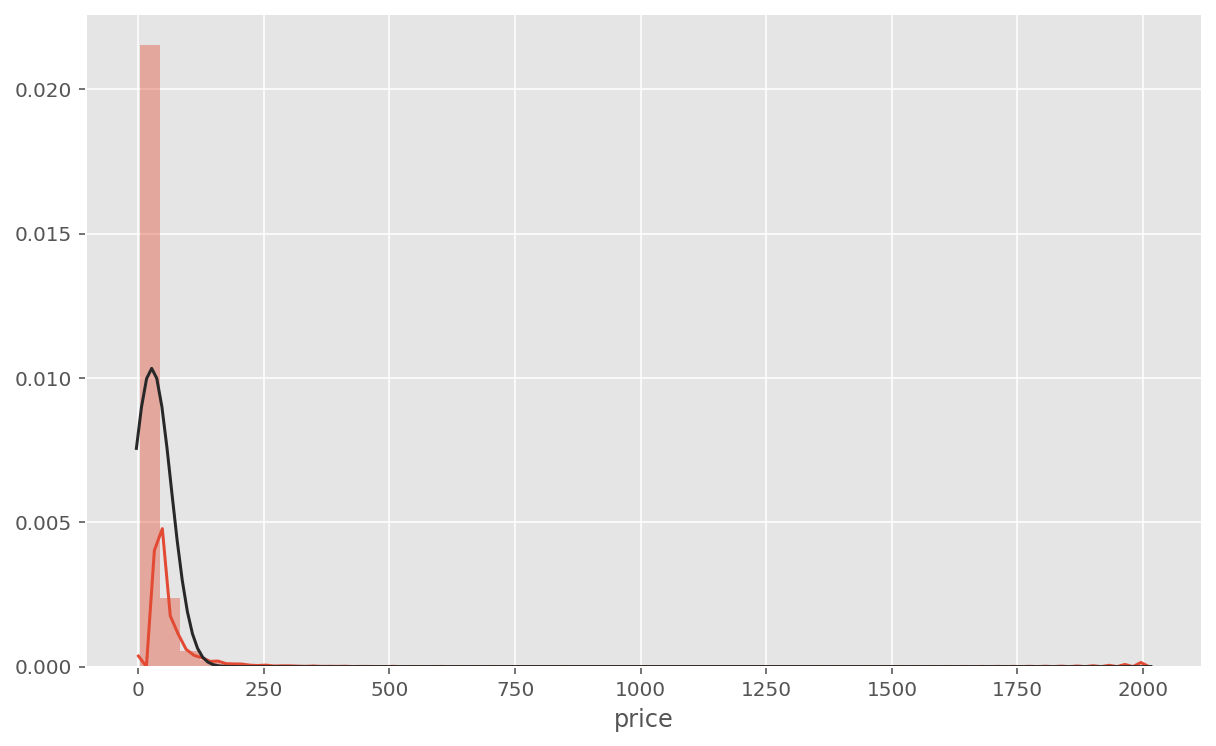

In [178]:
#lets look at the overall price distribution:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(data.price, fit =norm, ax=ax);

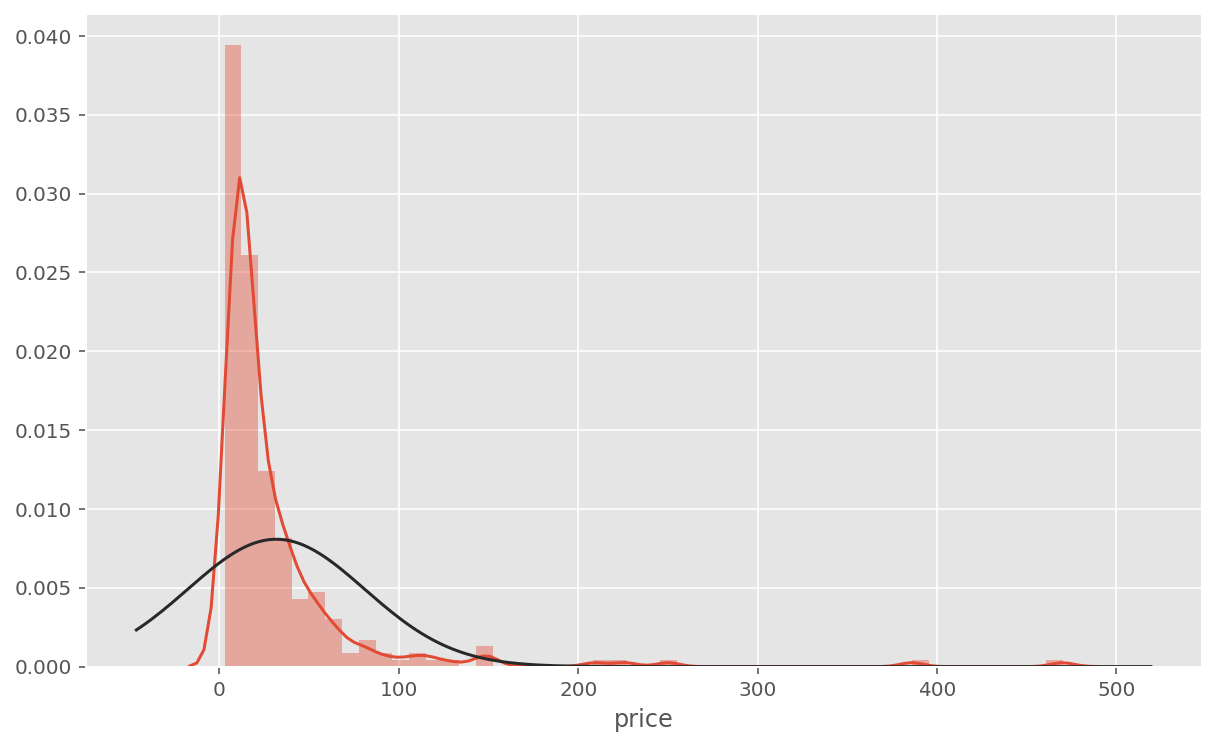

In [179]:
#take a closer look at first few values
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(data.price[:250], fit =norm, ax=ax);

In [180]:
#the price data is heavily skewed to the right (mean to the right of median and mode)
#we can take the log of the price column to obtain more normal distribution (otherwise we end up with 
#potential negative values predicted for price)

In [188]:
data['price_log'] = np.log(data['price'])

In [185]:
data.price_log

0          2.302585
1          3.951244
2          2.302585
3          3.555348
4          3.784190
             ...   
1482530    2.995732
1482531    2.639057
1482532    2.484907
1482533    3.806662
1482534    3.091042
Name: price_log, Length: 1475343, dtype: float64

In [186]:
data.price_log.min()

1.0986122886681098

In [187]:
data.price_log.max()

7.605392364814935

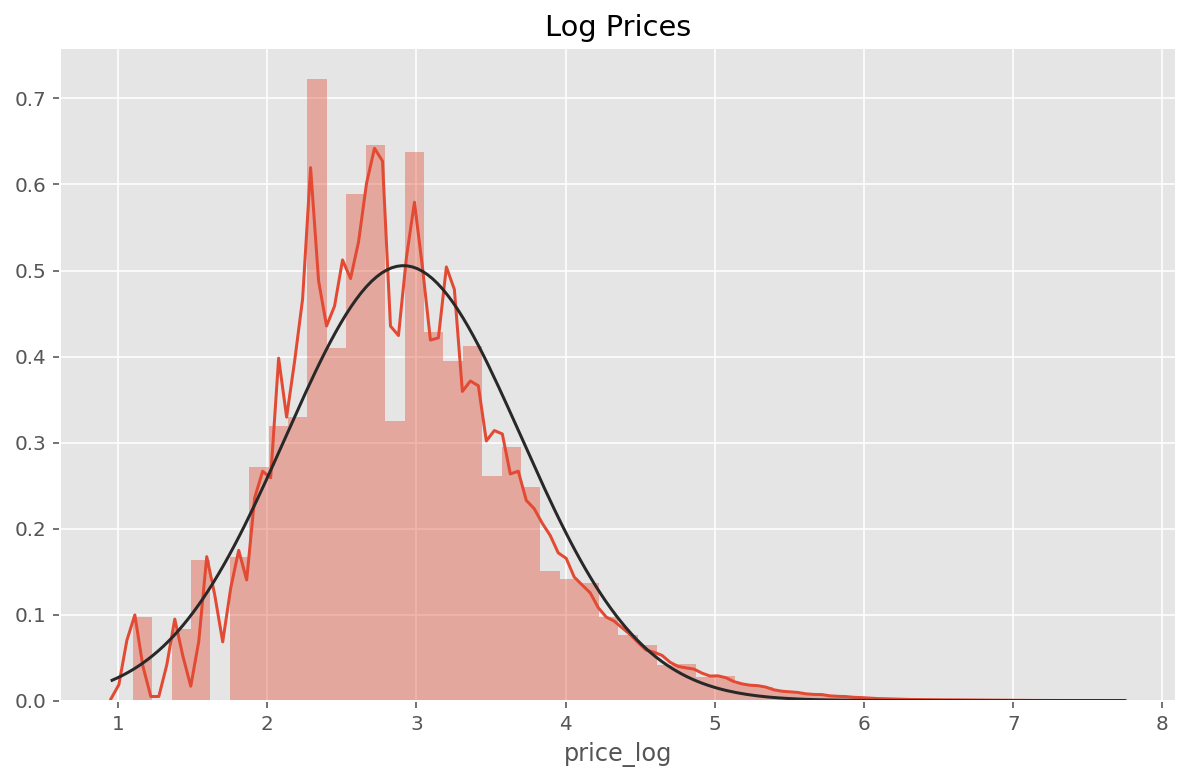

In [189]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(data.price_log, fit =norm);
ax.set_title('Log Prices');

BRAND NAME:

In [190]:
data.brand_name

0                  nan
1                razer
2               target
3                  nan
4                  nan
              ...     
1482530    free people
1482531         disney
1482532            nan
1482533            nan
1482534            nan
Name: brand_name, Length: 1475343, dtype: object

In [191]:
data.brand_name.unique()

array(['nan', 'razer', 'target', ..., 'astroglide', 'cumberland bay',
       'kids only'], dtype=object)

In [192]:
data.brand_name.value_counts()

nan                 628882
nike                 53923
pink                 53914
victorias secret     47910
lularoe              30844
                     ...  
notify                   1
joyce chen               1
mcguire denim            1
kristen blake            1
                         1
Name: brand_name, Length: 4772, dtype: int64

In [193]:
#top 10 most popular brands listed
top_10_brands = data.brand_name.value_counts()[1:].head(11)
top_10_brands

nike                53923
pink                53914
victorias secret    47910
lularoe             30844
apple               17285
forever             15097
nintendo            14974
lululemon           14540
michael kors        13883
american eagle      13178
rae dunn            12270
Name: brand_name, dtype: int64

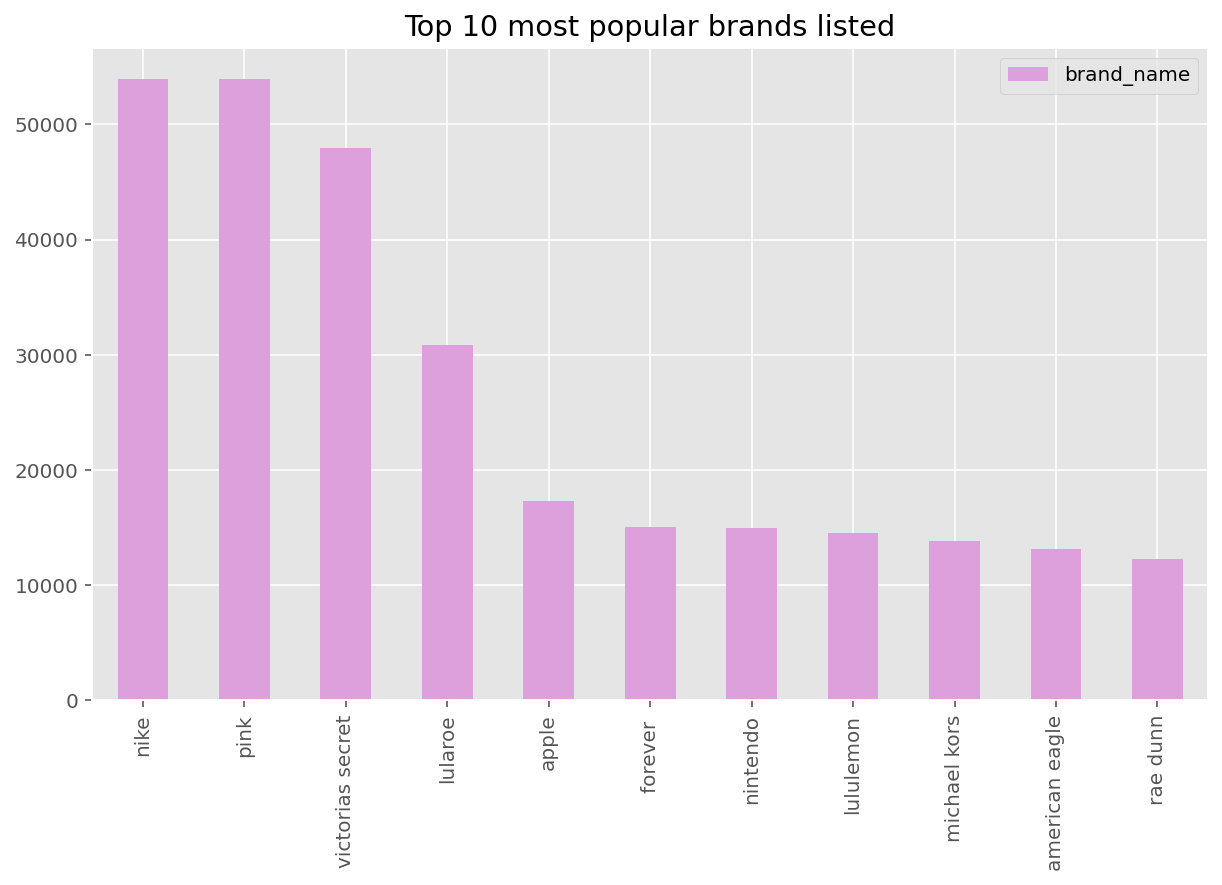

In [194]:
top_10_brands.plot(kind='bar', figsize=(10,6), color ='plum', title='Top 10 most popular brands listed')
plt.legend();

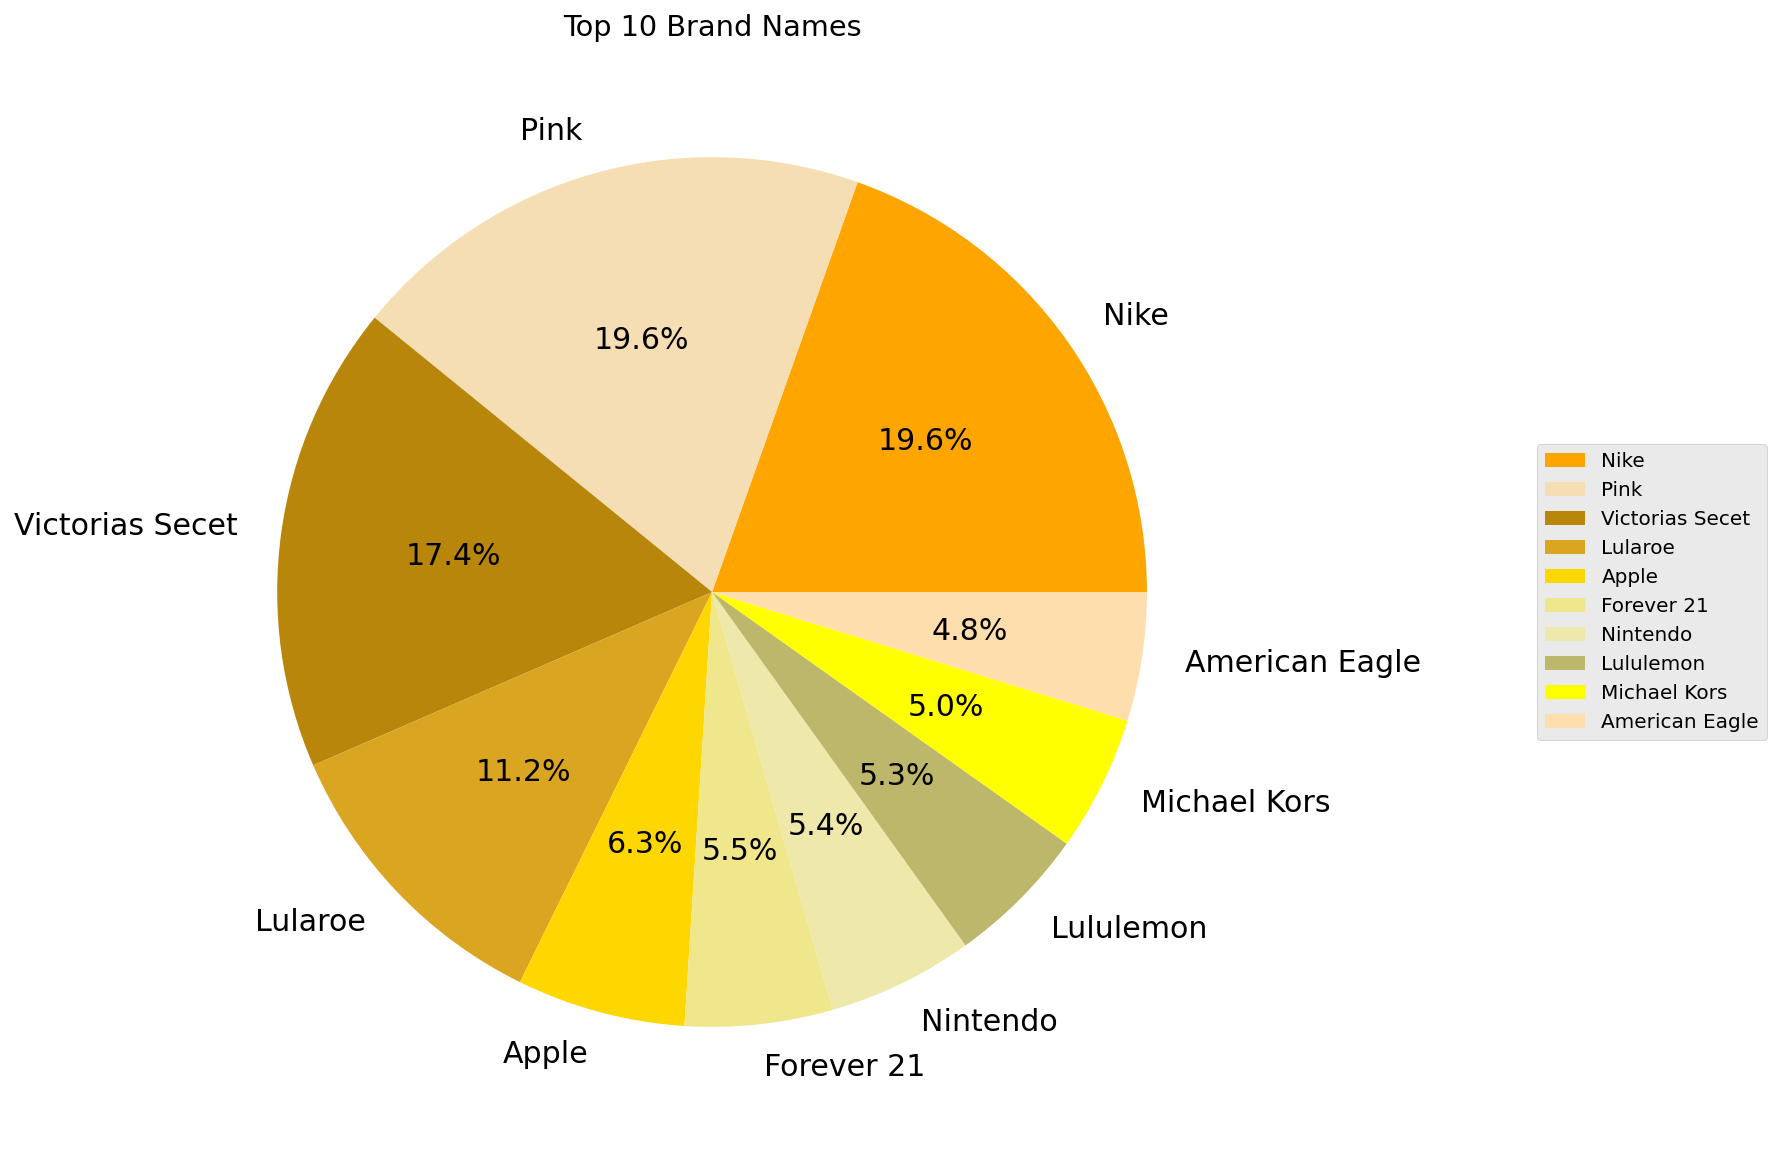

In [195]:
brands10 = data.brand_name.value_counts(normalize=True)[1:].head(10)*100
colors = ['orange', 'wheat', 'darkgoldenrod', 'goldenrod', 'gold', 'khaki', 'palegoldenrod',
         'darkkhaki', 'yellow', 'navajowhite']
brands10.plot(kind='pie', labels=['Nike', 'Pink', 'Victorias Secet', 'Lularoe', 'Apple', 
                                 'Forever 21', 'Nintendo', 'Lululemon', 'Michael Kors', 'American Eagle',
                                 'Rae Dunn'], fontsize=15, autopct="%.1f%%", title ='Top 10 Brand Names',
              colors=colors, legend=True, figsize=(10,10))
plt.ylabel('')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0, 1.5, 1))
plt.show();

In [196]:
#Most popularly sold brands on the app are Nike and Pink products

In [200]:
b = data[np.isin(data, ['nike', 'pink', 'victorias secret', 'lularoe', 'apple',
              'forever', 'nintendo', 'lululemon', 'michael kors', 'american eagle'])]

In [201]:
#mean and median price logs of each of the top 10 brands 
b_mean = pd.DataFrame(b.groupby('brand_name').mean().sort_values(by='price_log', ascending=False ))
b_median = pd.DataFrame(b.groupby('brand_name').median().sort_values(by='price_log', ascending=False ))


In [218]:
b_mean.iloc[:, [0,2]]

price  price_log
brand_name                                    
beats                     51.000000   3.931826
michael kors              62.242494   3.855451
customized  personalized  52.857143   3.776887
disney collection         42.000000   3.687315
lululemon                 46.993009   3.673599
puma                      31.000000   3.433987
independent               33.921569   3.428869
apple                     73.306691   3.411794
lularoe                   33.670361   3.387224
lululemon athletica       30.000000   3.312997
nan                       30.768977   3.183580
nike                      30.755386   3.176196
nintendo                  34.657509   3.110132
pink                      26.341370   3.060594
georgio armani            21.000000   3.044522
disney                    28.000000   2.975321
victorias secret          23.204390   2.947363
juicy couture             16.000000   2.772589
american eagle            15.947830   2.667947
forever                   11.730769   2.382630
aeropostale               10.000000   2.302585
abercrombie  fitch        10.000000   2.302585
samsung                    7.000000   1.945910

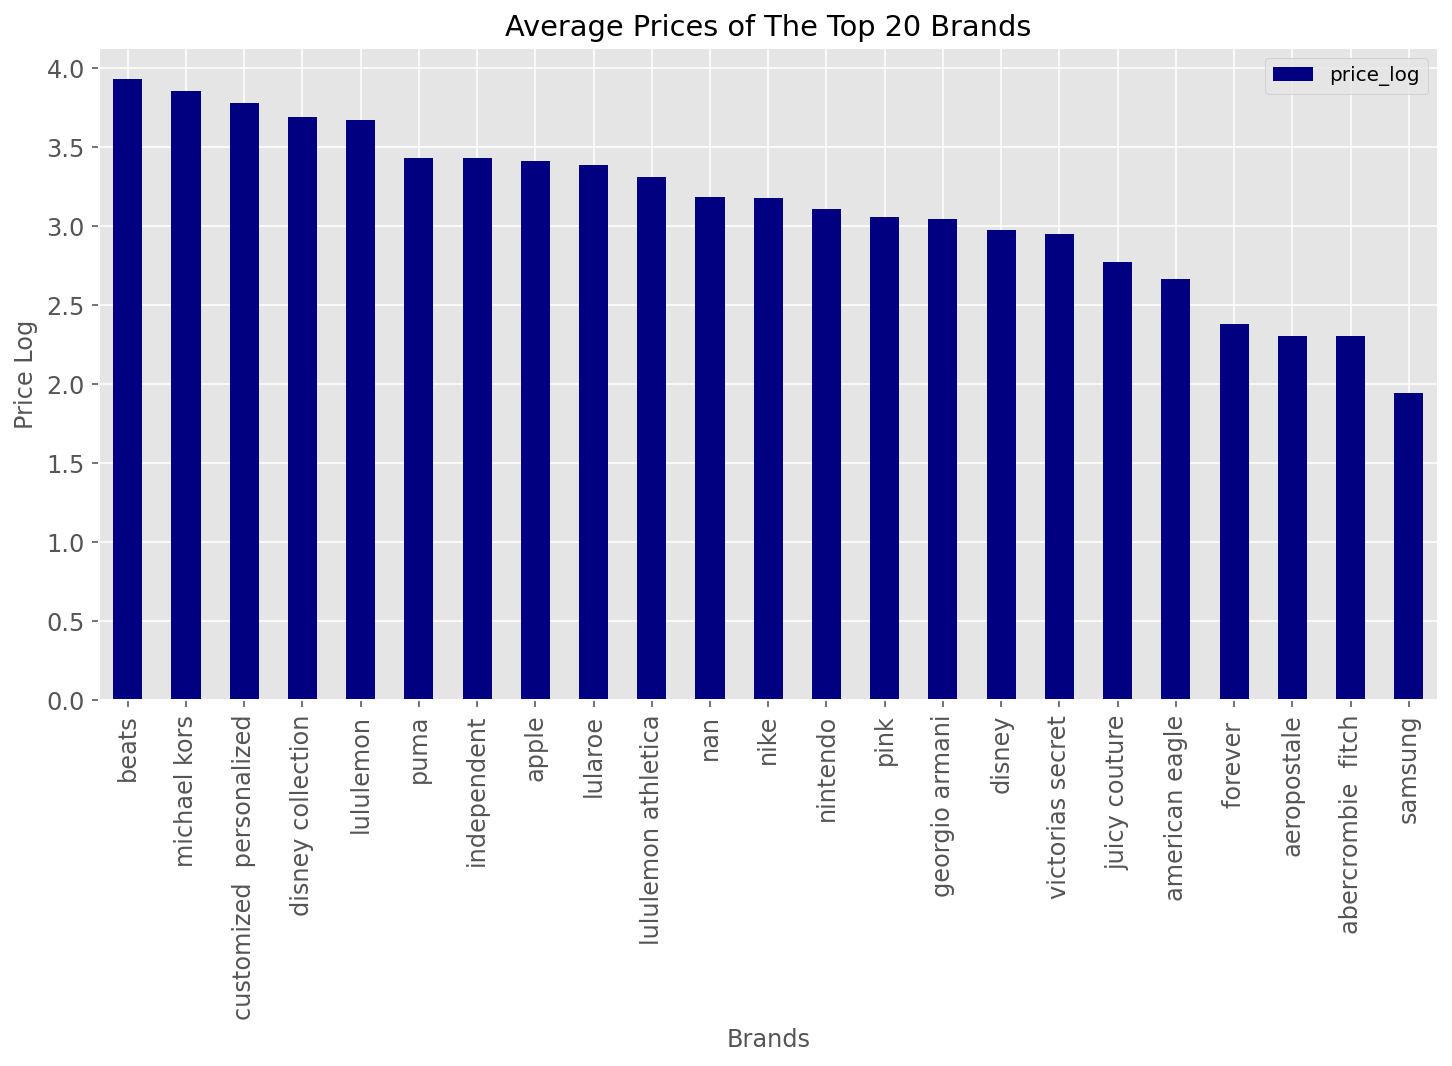

In [203]:
#plot mean prices
fig, ax = plt.subplots(figsize=(12,6))
b_mean['price_log'].plot(kind='bar', title='Average Prices of The Top 20 Brands', legend=True, ax=ax, color='navy', fontsize=12)
ax.set_xlabel('Brands')
ax.set_ylabel('Price Log');

In [219]:
b_median.iloc[:, [0, 2]]

price  price_log
brand_name                                
customized  personalized   60.0   4.094345
beats                      51.0   3.931826
michael kors               49.0   3.891820
disney collection          42.0   3.687315
lululemon                  39.0   3.663562
puma                       31.0   3.433987
lularoe                    29.0   3.367296
independent                28.0   3.332205
lululemon athletica        25.0   3.218876
nan                        24.0   3.178054
apple                      22.0   3.091042
nike                       22.0   3.091042
georgio armani             21.0   3.044522
pink                       20.0   2.995732
nintendo                   20.0   2.995732
disney                     28.0   2.975321
victorias secret           19.0   2.944439
juicy couture              16.0   2.772589
american eagle             14.0   2.639057
forever                    10.5   2.350240
aeropostale                10.0   2.302585
abercrombie  fitch         10.0   2.302585
samsung                     7.0   1.945910

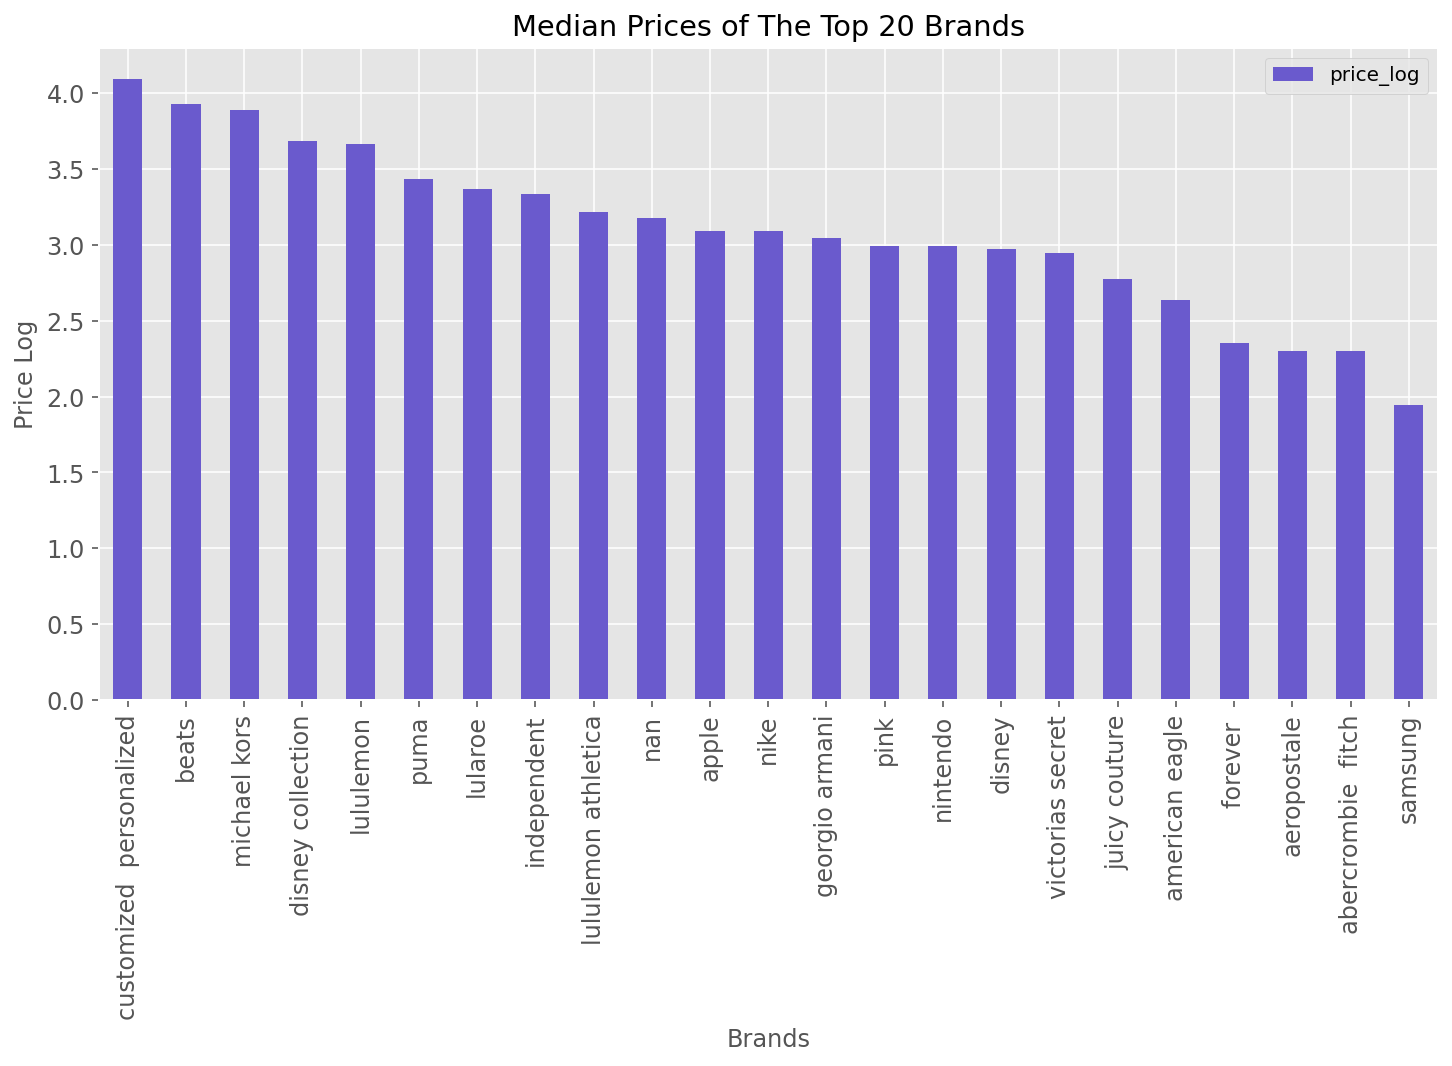

In [204]:
#plot median prices 
fig, ax = plt.subplots(figsize=(12,6))
b_median['price_log'].plot(kind='bar', title='Median Prices of The Top 20 Brands', legend=True, ax=ax, color='slateblue', fontsize=12)
ax.set_xlabel('Brands')
ax.set_ylabel('Price Log');

In [205]:
#least popularly sold brands on the app:
data.brand_name.value_counts().tail(10)

truly scrumptious          1
david brooks               1
arcona                     1
three seasons maternity    1
desitin                    1
notify                     1
joyce chen                 1
mcguire denim              1
kristen blake              1
                           1
Name: brand_name, dtype: int64

In [206]:
#lets look at the more expensive brands category:

In [220]:
data[data.price >= 1000].brand_name.unique() #list of product brand names which costs more than $1000

array(['chanel', 'celine', 'alexander mcqueen', 'tiffany  co',
       'saint laurent', 'louis vuitton', 'apple', 'mcm worldwide', 'dell',
       'nan', 'canon', 'gucci', 'burberry', 'bose', 'xbox',
       'michael kors', 'urban decay', 'microsoft', 'goyard', 'mary kay',
       'stamped', 'prada', 'benefit', 'victorias secret',
       'proenza schouler', 'oakley', 'pandora', 'vintage', 'david yurman',
       'cartier'], dtype=object)

In [222]:
data[data.price >= 1000].category_1.value_counts() #categories which contain products costing above 1000

women                     111
electronics                28
vintage & collectibles     27
beauty                      5
other                       2
men                         2
handmade                    1
Name: category_1, dtype: int64

In [223]:
b = data[data.price >= 1000].brand_name.value_counts()
b

louis vuitton        63
nan                  24
chanel               22
apple                17
saint laurent         8
mcm worldwide         6
celine                5
gucci                 4
urban decay           3
microsoft             2
canon                 2
michael kors          2
burberry              1
goyard                1
david yurman          1
pandora               1
cartier               1
benefit               1
dell                  1
bose                  1
oakley                1
mary kay              1
alexander mcqueen     1
victorias secret      1
stamped               1
prada                 1
xbox                  1
proenza schouler      1
vintage               1
tiffany  co           1
Name: brand_name, dtype: int64

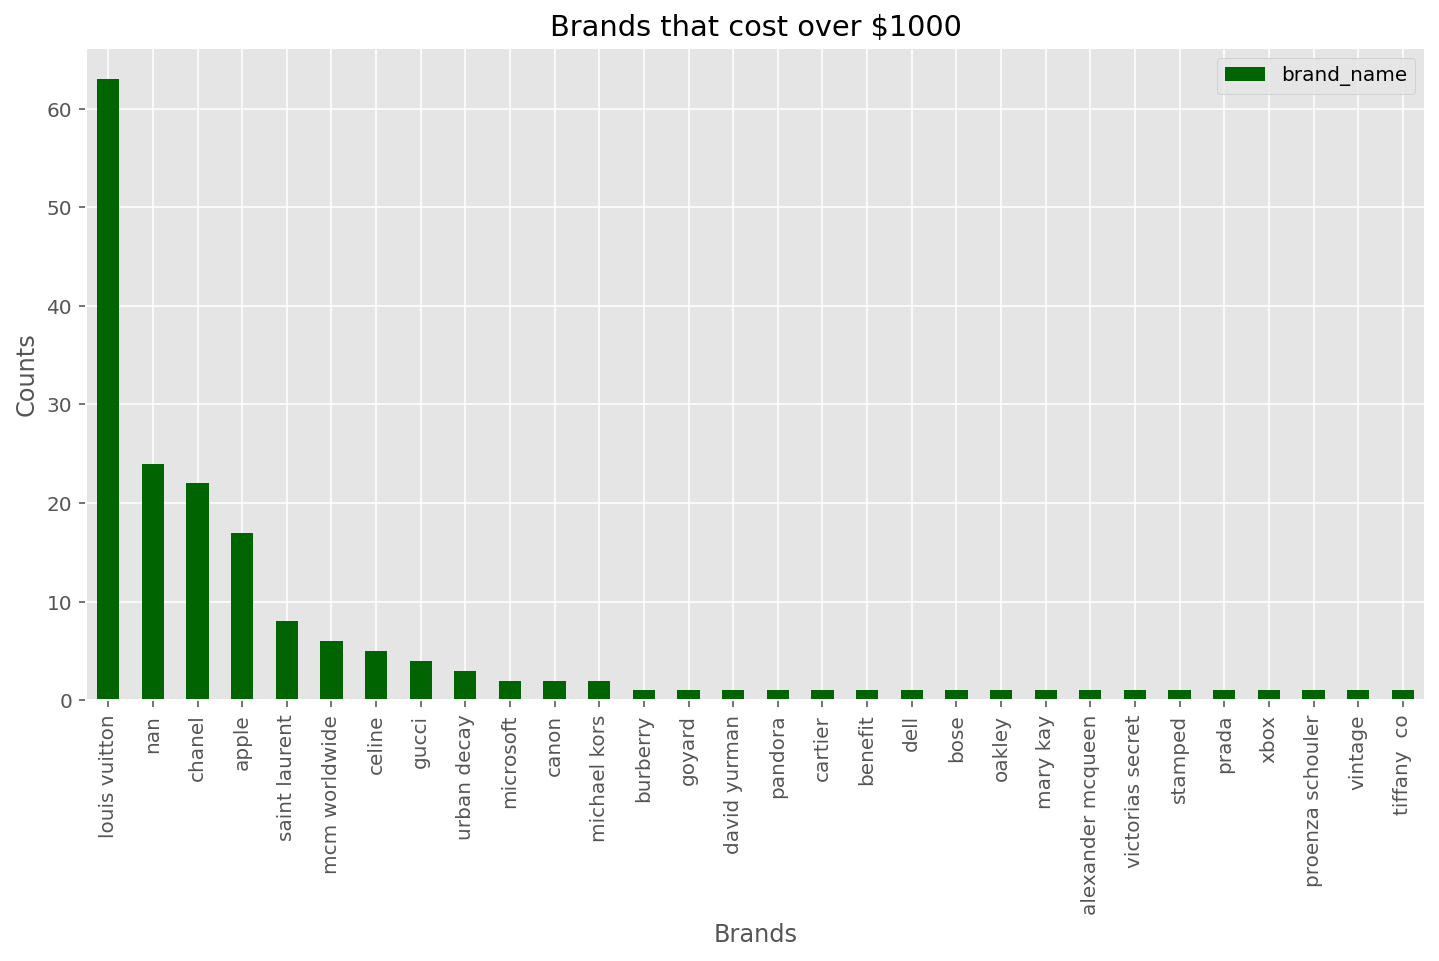

In [228]:
fig, ax = plt.subplots(figsize=(12,6))
b.plot(kind='bar', title= 'Brands that cost over $1000', legend=True, ax=ax, color='darkgreen');
ax.set_xlabel('Brands')
ax.set_ylabel('Counts');

In [224]:
#average prices of these brands
b2 = data[data.price >= 1000]
b3 = pd.DataFrame(b2.groupby('brand_name').mean().sort_values(by='price', ascending=False))
b3['price']

brand_name
david yurman         2004.000000
mary kay             2000.000000
chanel               1568.636364
michael kors         1540.000000
victorias secret     1400.000000
urban decay          1395.000000
celine               1370.800000
stamped              1354.000000
nan                  1353.625000
prada                1350.000000
goyard               1350.000000
microsoft            1345.000000
saint laurent        1330.125000
apple                1323.823529
oakley               1309.000000
louis vuitton        1259.857143
bose                 1250.000000
dell                 1215.000000
mcm worldwide        1166.666667
gucci                1151.250000
xbox                 1115.000000
alexander mcqueen    1109.000000
vintage              1054.000000
canon                1035.500000
benefit              1015.000000
burberry             1009.000000
proenza schouler     1006.000000
cartier              1006.000000
tiffany  co          1004.000000
pandora              1000.000000

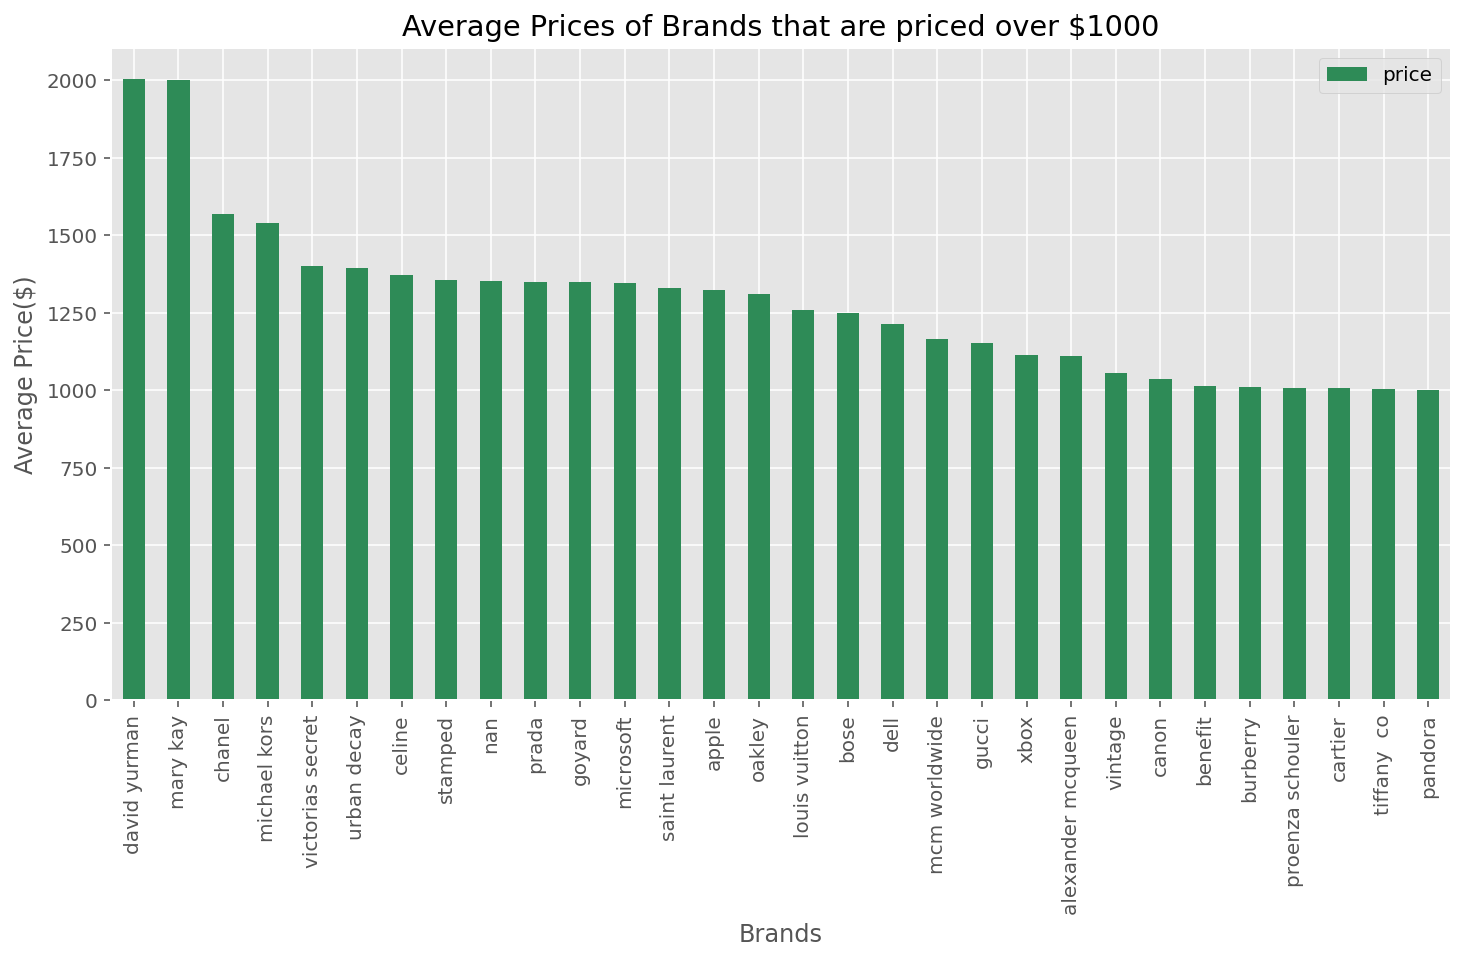

In [227]:
fig, ax = plt.subplots(figsize=(12,6))
b3['price'].plot(kind='bar', title='Average Prices of Brands that are priced over $1000', legend=True, ax=ax, color='seagreen')
ax.set_xlabel('Brands')
ax.set_ylabel('Average Price($)');

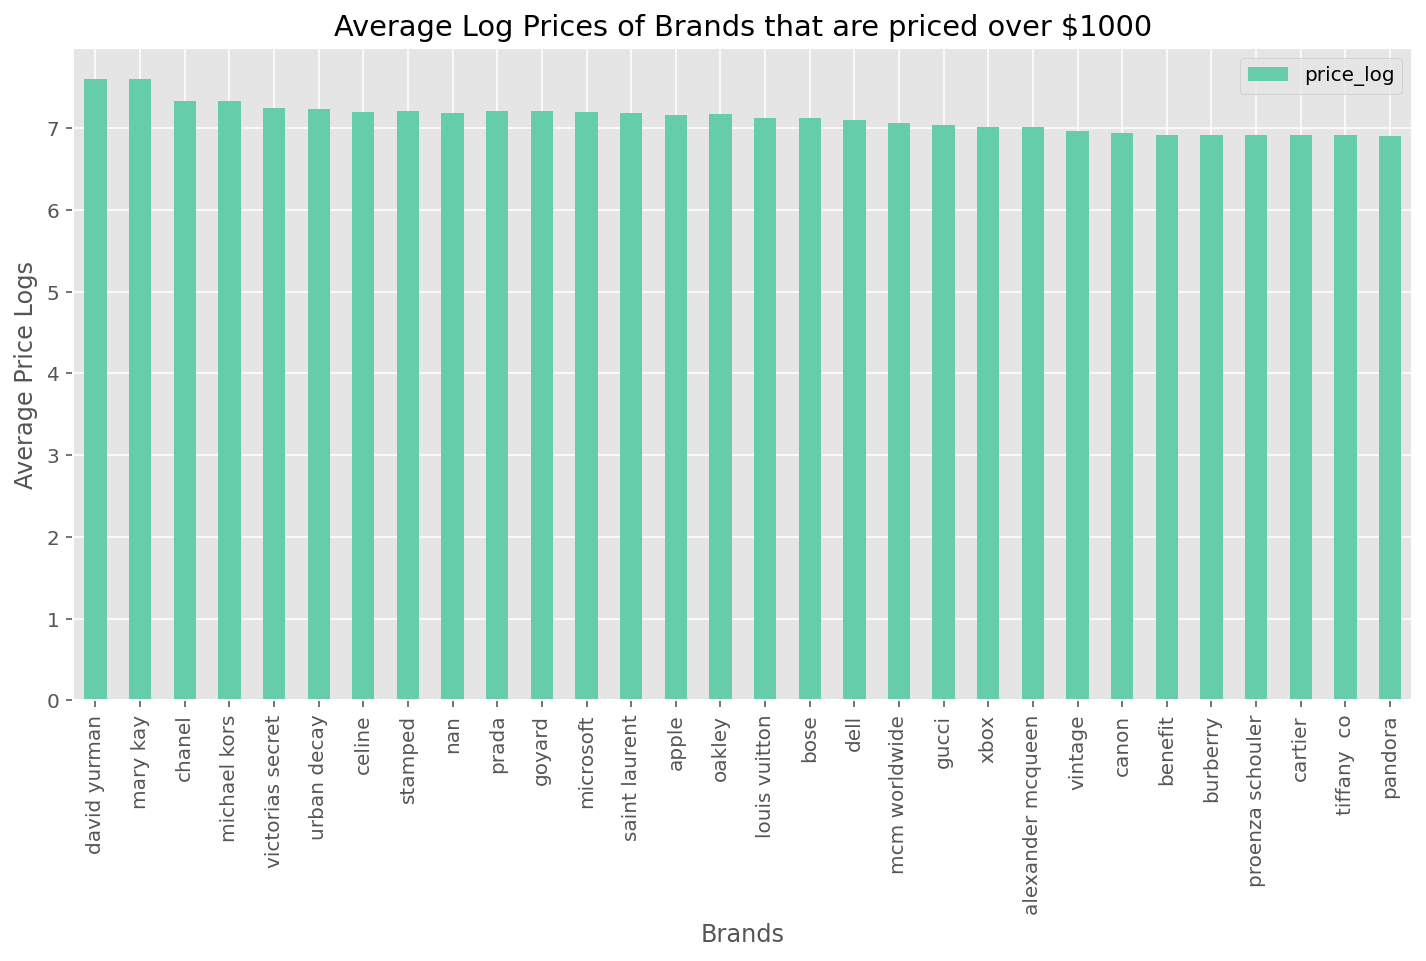

In [229]:
fig, ax = plt.subplots(figsize=(12,6))
b3['price_log'].plot(kind='bar', title='Average Log Prices of Brands that are priced over $1000', legend=True, ax=ax, color='mediumaquamarine')
ax.set_xlabel('Brands')
ax.set_ylabel('Average Price Logs');

In [230]:
#brands which cost much less((majority of the products listed)):
data[data.price <= 30]

name        brand_name  price  \
0           mlb cincinnati reds t shirt size xl               nan   10.0   
2                                 avaviv blouse            target   10.0   
7           girls cheer and tumbling bundle of              soffe    6.0   
8                         girls nike pro shorts              nike   19.0   
9        porcelain clown doll checker pants vtg               nan    8.0   
...                                         ...               ...    ...   
1482528       victorias secret tankini sz large  victorias secret   18.0   
1482530              free people inspired dress       free people   20.0   
1482531           little mermaid handmade dress            disney   14.0   
1482532      day fix containers and eating plan               nan   12.0   
1482534           brand new lux de ville wallet               nan   22.0   

        shipping                                   item_description  \
0         Seller                                                NaN   
2         Seller  adorable, top, hint, lace, key, hole, back, pa...   
7         Seller  get, three, pairs, sophie, cheer, shorts, size...   
8          Buyer  girls, size, small, plus, green, three, shorts...   
9          Buyer  realized, pants, backwards, picture, dirty, ha...   
...          ...                                                ...   
1482528   Seller  purple, paisley, victorias, secret, tankini, s...   
1482530   Seller  lace, says, size, small, fits, medium, perfect...   
1482531    Buyer  little, mermaid, handmade, dress, never, worn,...   
1482532    Buyer                   used, twice, still, great, shape   
1482534    Buyer  new, tag, red, sparkle, firm, price, free, shi...   

                     category_1           category_2           category_3  \
0                           men                 tops             t-shirts   
2                         women       tops & blouses               blouse   
7             sports & outdoors              apparel                girls   
8             sports & outdoors              apparel                girls   
9        vintage & collectibles         collectibles                 doll   
...                         ...                  ...                  ...   
1482528                   women     athletic apparel          sports bras   
1482530                   women              dresses             mid-calf   
1482531                    kids          girls 2t-5t              dresses   
1482532       sports & outdoors             exercise  fitness accessories   
1482534                   women  women's accessories              wallets   

        category_4 brand_p/a description_p/a  desc_len item_condition  \
0              nan    Absent          Absent       NaN           Good   
2              nan   Present         Present      84.0            New   
7              nan   Present         Present     221.0           Good   
8              nan   Present         Present      53.0           Good   
9              nan    Absent         Present     214.0           Good   
...            ...       ...             ...       ...            ...   
1482528        nan   Present         Present     116.0       Like New   
1482530        nan   Present         Present     113.0       Like New   
1482531        nan   Present         Present      51.0       Like New   
1482532        nan    Absent         Present      32.0       Like New   
1482534        nan    Absent         Present      51.0            New   

         price_log  
0         2.302585  
2         2.302585  
7         1.791759  
8         2.944439  
9         2.079442  
...            ...  
1482528   2.890372  
1482530   2.995732  
1482531   2.639057  
1482532   2.484907  
1482534   3.091042  

[1133969 rows x 14 columns]

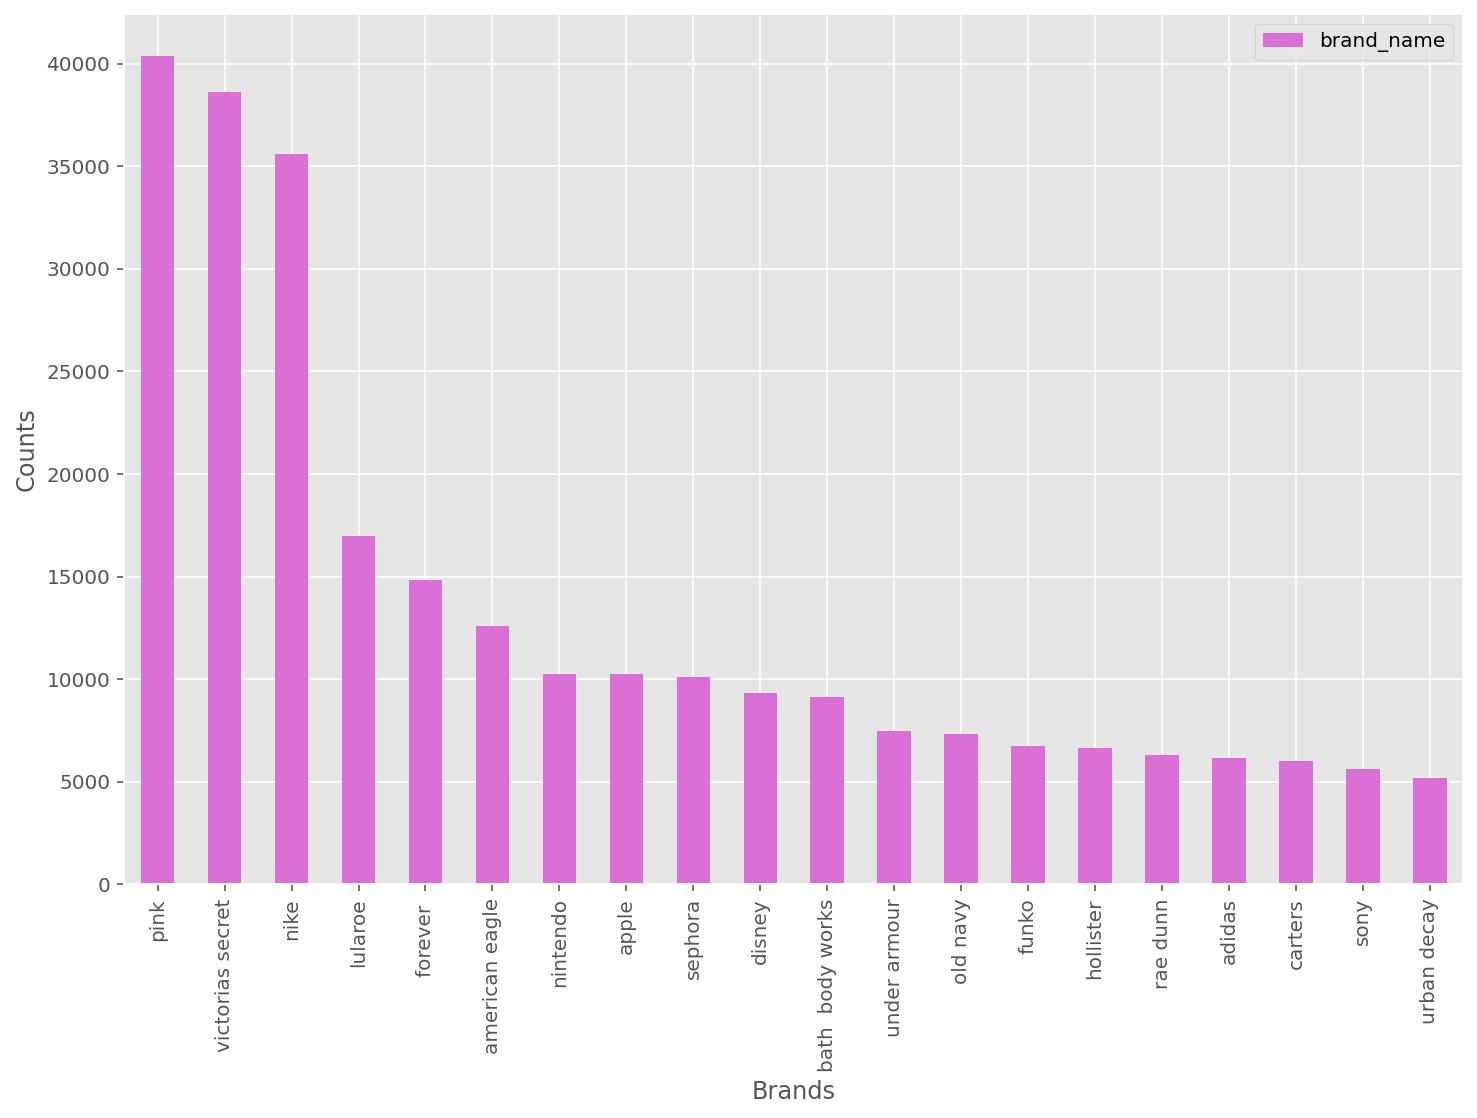

In [231]:
#counts of the top 20 brands priced under $30
b1 = data[data.price <= 30].brand_name.value_counts()[1:21] 
fig, ax= plt.subplots(figsize=(12,8))
b1.plot(kind='bar', color='orchid', legend=True )
ax.set_xlabel('Brands')
ax.set_ylabel('Counts');

In [233]:
#average prices of brands under $30
b1 = data[data.price <= 30]
b2 = pd.DataFrame(b1.groupby('brand_name').mean().sort_values(by='price', ascending=False))
b2.drop(labels='nan', axis=0, inplace=True)
b2.iloc[:, [0,2]]

price  price_log
brand_name                                 
together                    30.0   3.401197
dri duck                    30.0   3.401197
beretta                     30.0   3.401197
luichiny                    30.0   3.401197
tieks                       30.0   3.401197
...                          ...        ...
kids only                    3.0   1.098612
duo                          3.0   1.098612
genica                       3.0   1.098612
twilight gypsy collective    3.0   1.098612
ask                          3.0   1.098612

[4436 rows x 2 columns]

SHIPPING:

In [236]:
data.shipping.value_counts()

Buyer     814862
Seller    660481
Name: shipping, dtype: int64

In [237]:
data.shipping.value_counts(normalize=True)*100

Buyer     55.232038
Seller    44.767962
Name: shipping, dtype: float64

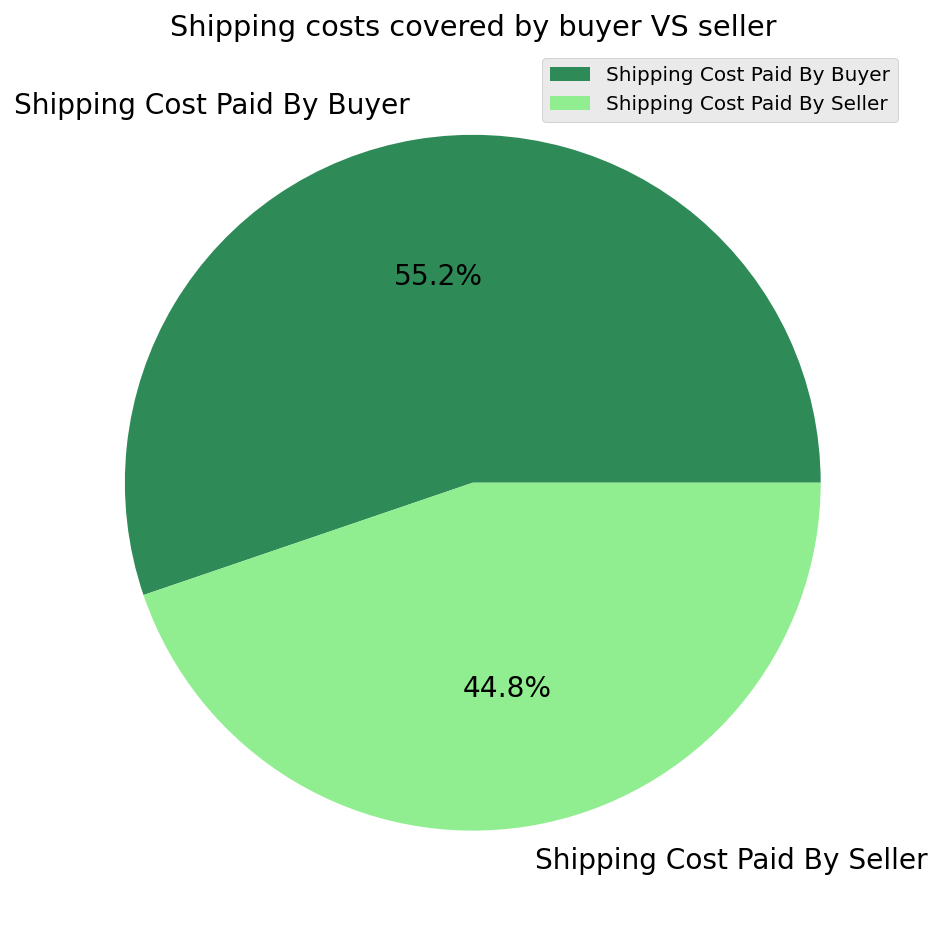

In [238]:
s = data.shipping.value_counts(normalize=True)*100
colors = ['seagreen', 'lightgreen']
s.plot(kind='pie', labels=['Shipping Cost Paid By Buyer', 'Shipping Cost Paid By Seller'], autopct="%.1f%%", colors=colors,
       fontsize =14, title ='Shipping costs covered by buyer VS seller', legend=True, figsize=(8,8))
plt.ylabel('')
plt.show();

In [239]:
#changes in the average price if buyer pays for shipping vs seller pays for shipping:

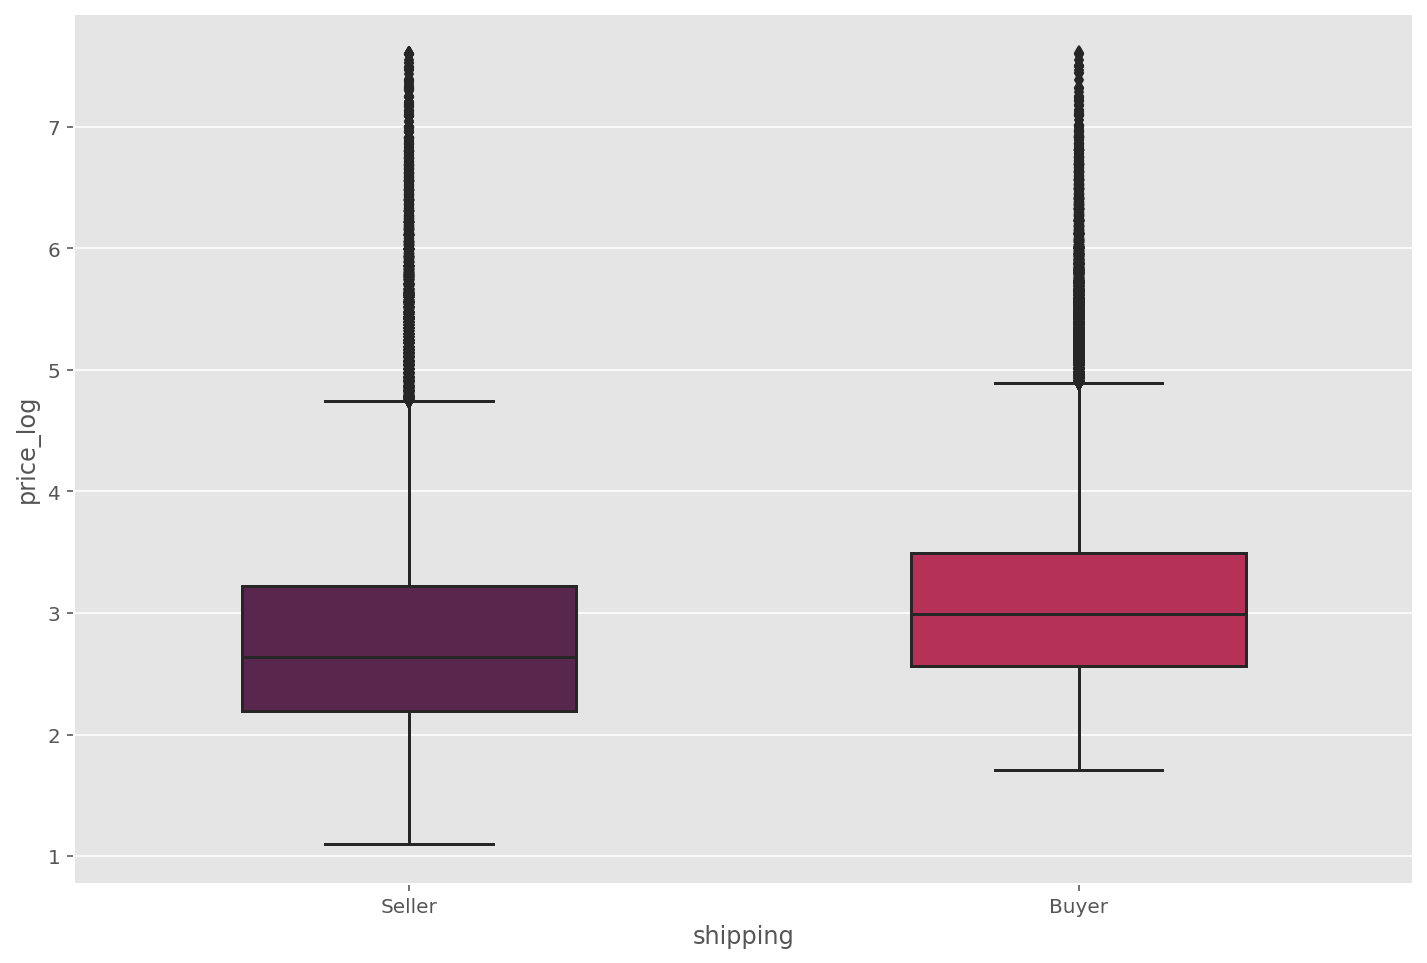

In [241]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'shipping', y = 'price_log',
            data = data, palette = sns.color_palette('rocket', 3),
           fliersize=5, width=0.5);
plt.show();

In [242]:
#The median price drops lower if the seller pays the shipping costs, as compared to the buyer, as expected.

ITEM DESCRIPTION:

In [243]:
data.item_description

0                                                        NaN
1          keyboard, great, condition, works, like, came,...
2          adorable, top, hint, lace, key, hole, back, pa...
3          new, tags, leather, horses, retail, rm, stand,...
4                        complete, certificate, authenticity
                                 ...                        
1482530    lace, says, size, small, fits, medium, perfect...
1482531    little, mermaid, handmade, dress, never, worn,...
1482532                     used, twice, still, great, shape
1482533    one, see, red, orange, big, red, orange, ones,...
1482534    new, tag, red, sparkle, firm, price, free, shi...
Name: item_description, Length: 1475343, dtype: object

In [253]:
data.item_description.isnull().sum()

81819

In [254]:
#convert to unicode string 
data.item_description.dtype

dtype('O')

In [258]:
desc = data.item_description.astype(str)

In [259]:
#look at the most frequently appearing words:
cv = CountVectorizer()

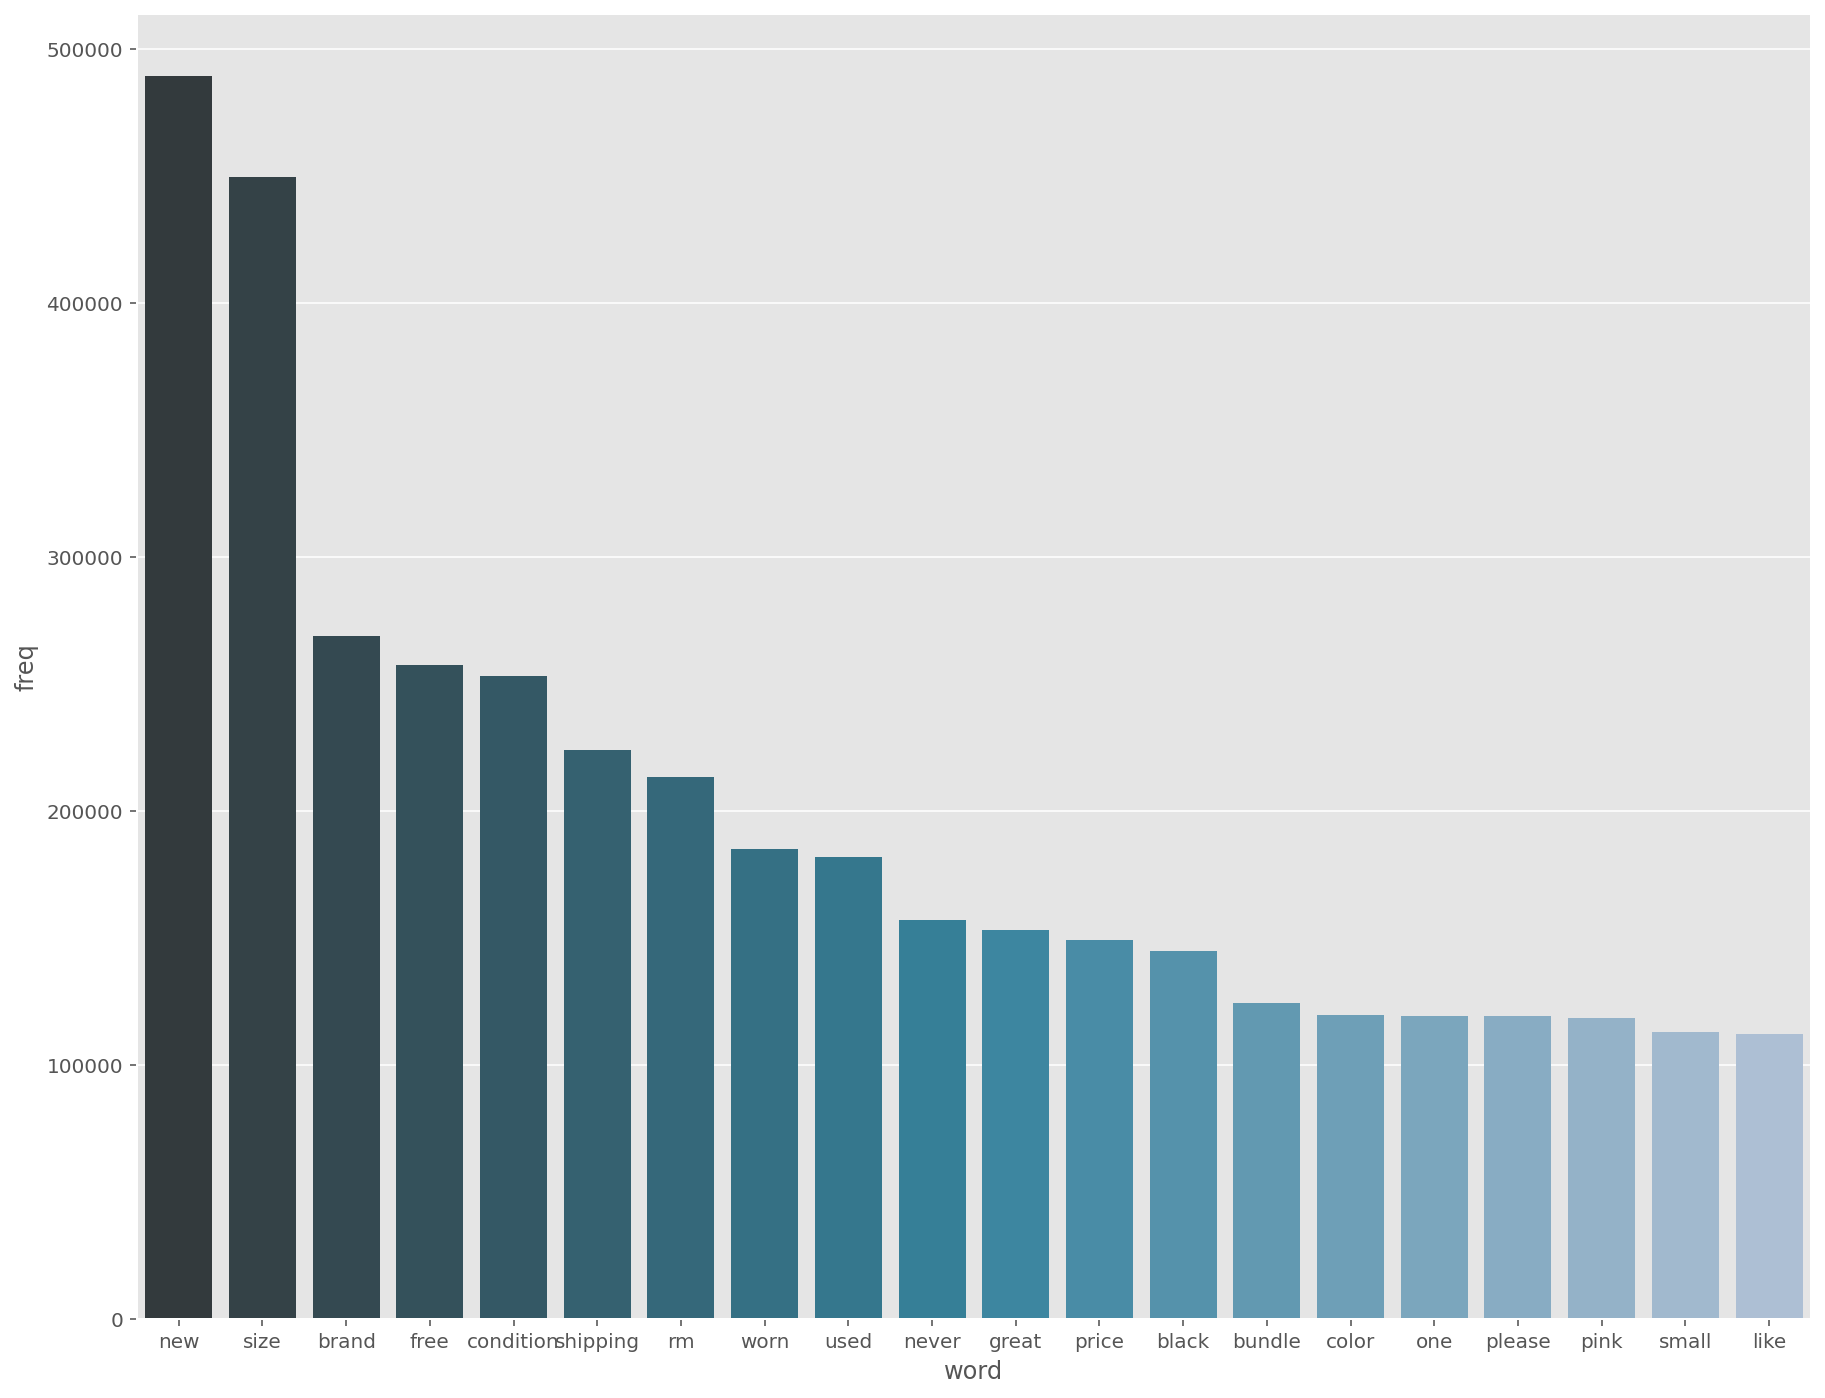

In [263]:
bow = cv.fit_transform(desc)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [264]:
#we can see that the most frequently appearing words in the item descriptions are "new", "size", "brand" and "free" 
#among others. 
#indicates that the word "new" has the most powerful impact in creating a desireable listings online. 

In [265]:
#as part of my further actions for this project, I will be carrying out sentiment analysis on the descriptions 
#to be able to classify the sentiment/mood of the description and look at how they are correlated with price. 

CATEGORY 1

In [266]:
data.category_1

0                        men
1                electronics
2                      women
3                       home
4                      women
                 ...        
1482530                women
1482531                 kids
1482532    sports & outdoors
1482533                 home
1482534                women
Name: category_1, Length: 1475343, dtype: object

In [268]:
data.category_1.describe()

count     1475343
unique         10
top         women
freq       663988
Name: category_1, dtype: object

In [269]:
data.category_1.value_counts()

women                     663988
beauty                    207724
kids                      171554
electronics               122632
men                        93609
home                       67831
vintage & collectibles     46519
other                      45329
handmade                   30835
sports & outdoors          25322
Name: category_1, dtype: int64

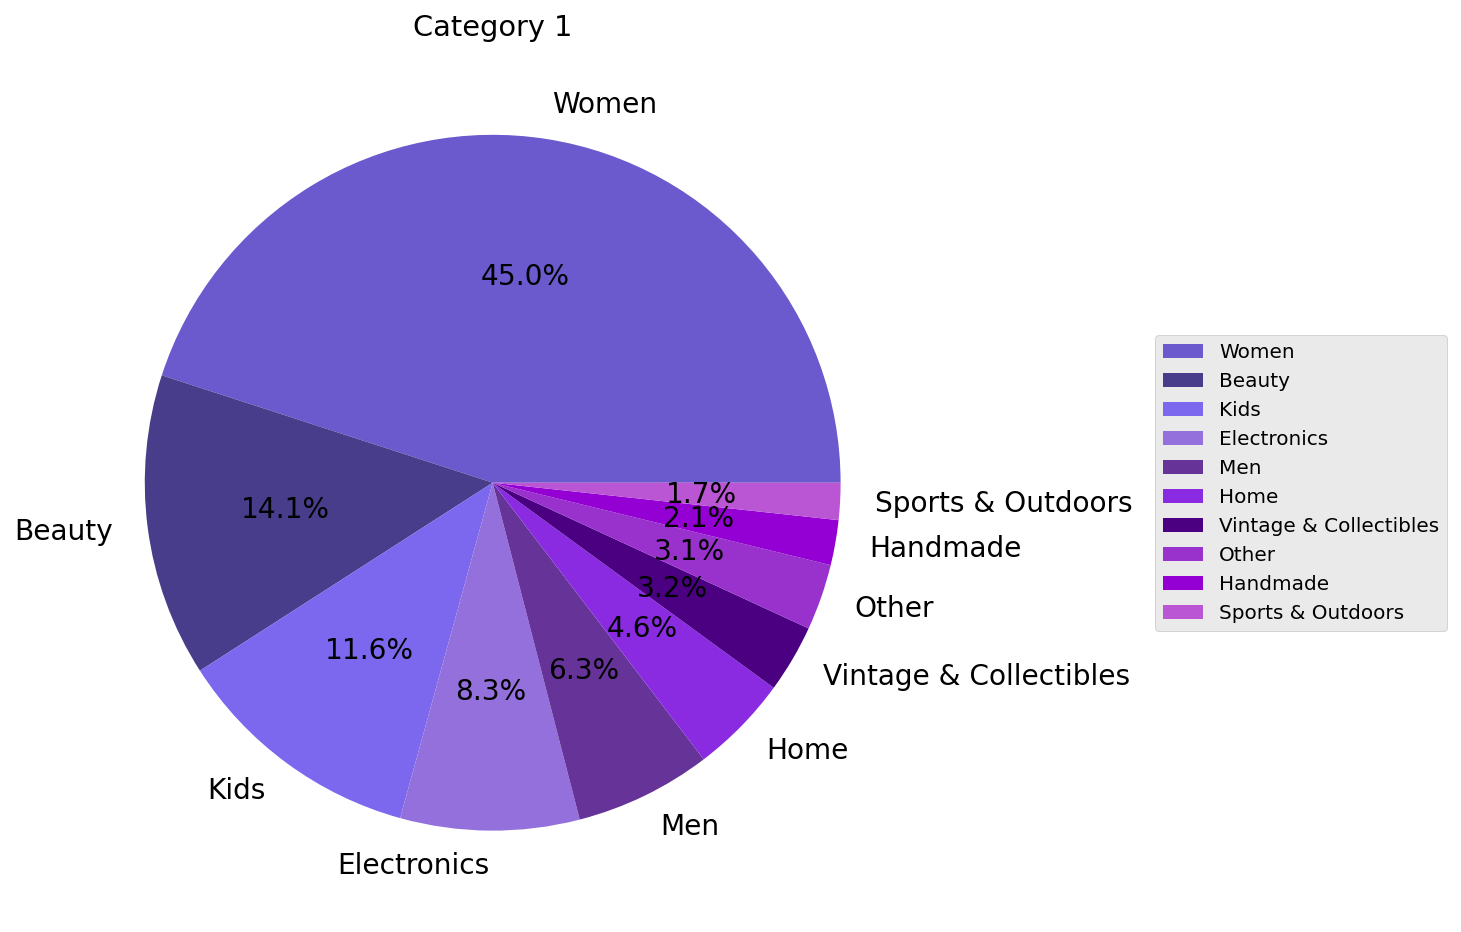

In [271]:
p = data.category_1.value_counts(normalize=True)*100
colors = ['slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid']
p.plot(kind='pie', labels=['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home', 'Vintage & Collectibles',
                          'Other', 'Handmade', 'Sports & Outdoors'], autopct="%.1f%%", colors= colors,
       fontsize =14, title ='Category 1', legend=True, figsize=(8,8))
plt.ylabel('')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0, 1.5, 1));

In [272]:
#womens items are the most popularly sold items on the app
#sports and outdoor items are least popularly sold items on the app
#we can dummify this column to see which categories have highest correlation with sale price
#it is important to note that what is classified as 'other' may be subjective to users of the app. 

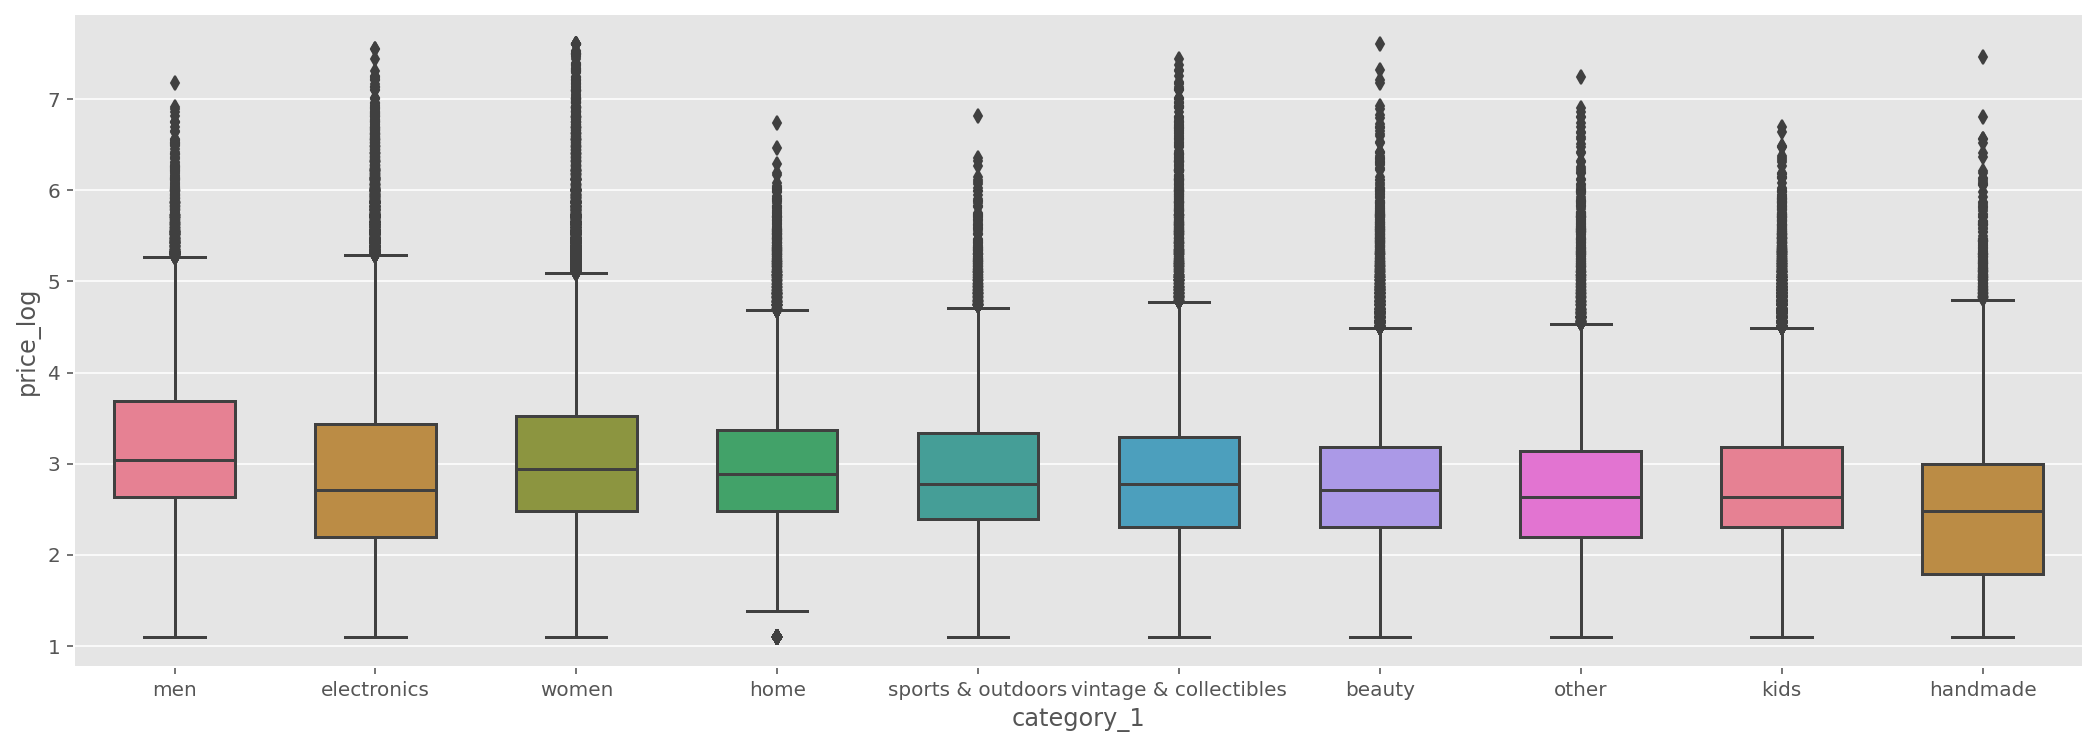

In [274]:
plt.figure(figsize=(18,6))
sns.boxplot(x = 'category_1', y = 'price_log',
            data = data, palette = sns.color_palette("husl", 8),
           fliersize=5, width=0.6);
plt.show();

In [275]:
#average price for each category
data.groupby('category_1')[['price', 'price_log']].mean().sort_values(by='price_log', ascending=False)

price  price_log
category_1                                  
men                     34.734940   3.178455
women                   28.902738   3.022089
home                    24.551068   2.928220
electronics             35.190558   2.913169
sports & outdoors       25.552385   2.907715
vintage & collectibles  27.345891   2.820114
kids                    20.658507   2.737521
beauty                  19.681149   2.724829
other                   20.819917   2.670069
handmade                18.160694   2.473166

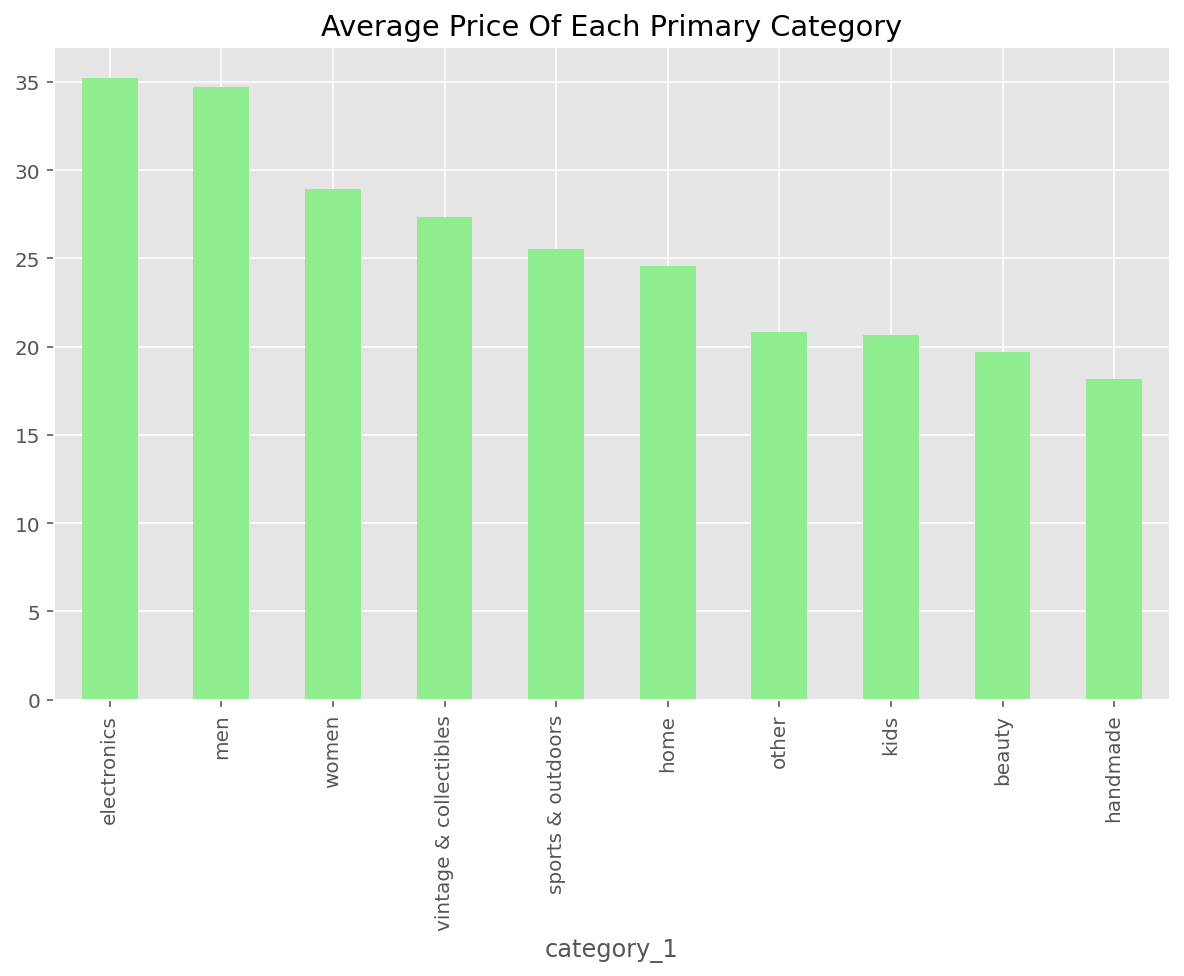

In [279]:
pc = data.groupby('category_1').mean().sort_values(by='price', ascending=False)
pc['price'].plot(kind='bar', color='lightgreen', figsize=(10,6), title='Average Price Of Each Primary Category');

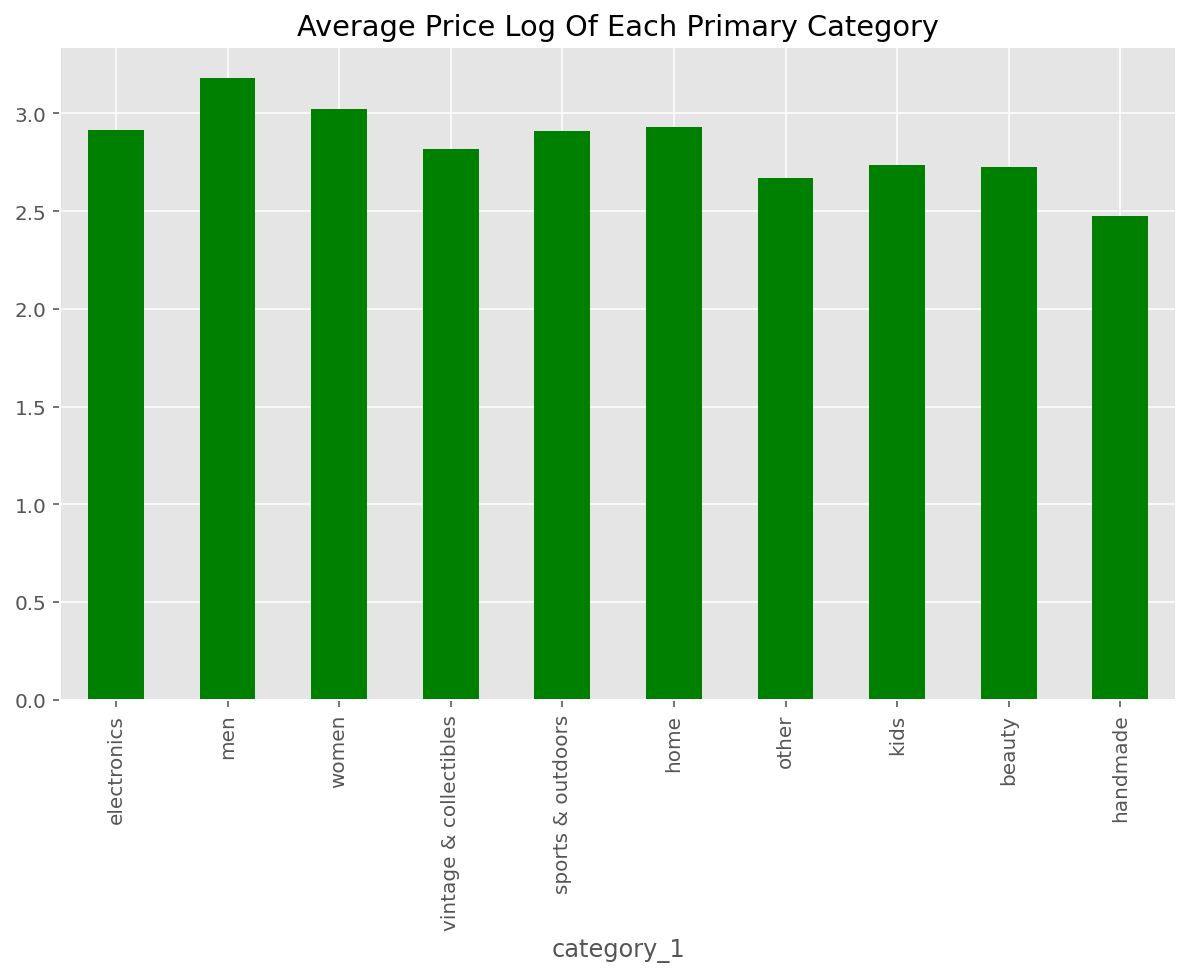

In [280]:
pc['price_log'].plot(kind='bar', color='green', figsize=(10,6), title='Average Price Log Of Each Primary Category');

In [282]:
#highest average price for category 1 is 'Electronics'. 
#highest average price_log for category 1 is 'Men'

In [283]:
#median price for each category
data.groupby('category_1')[['price', 'price_log']].median().sort_values(by='price_log', ascending=False)

price  price_log
category_1                              
men                      21.0   3.044522
women                    19.0   2.944439
home                     18.0   2.890372
sports & outdoors        16.0   2.772589
vintage & collectibles   16.0   2.772589
beauty                   15.0   2.708050
electronics              15.0   2.708050
kids                     14.0   2.639057
other                    14.0   2.639057
handmade                 12.0   2.484907

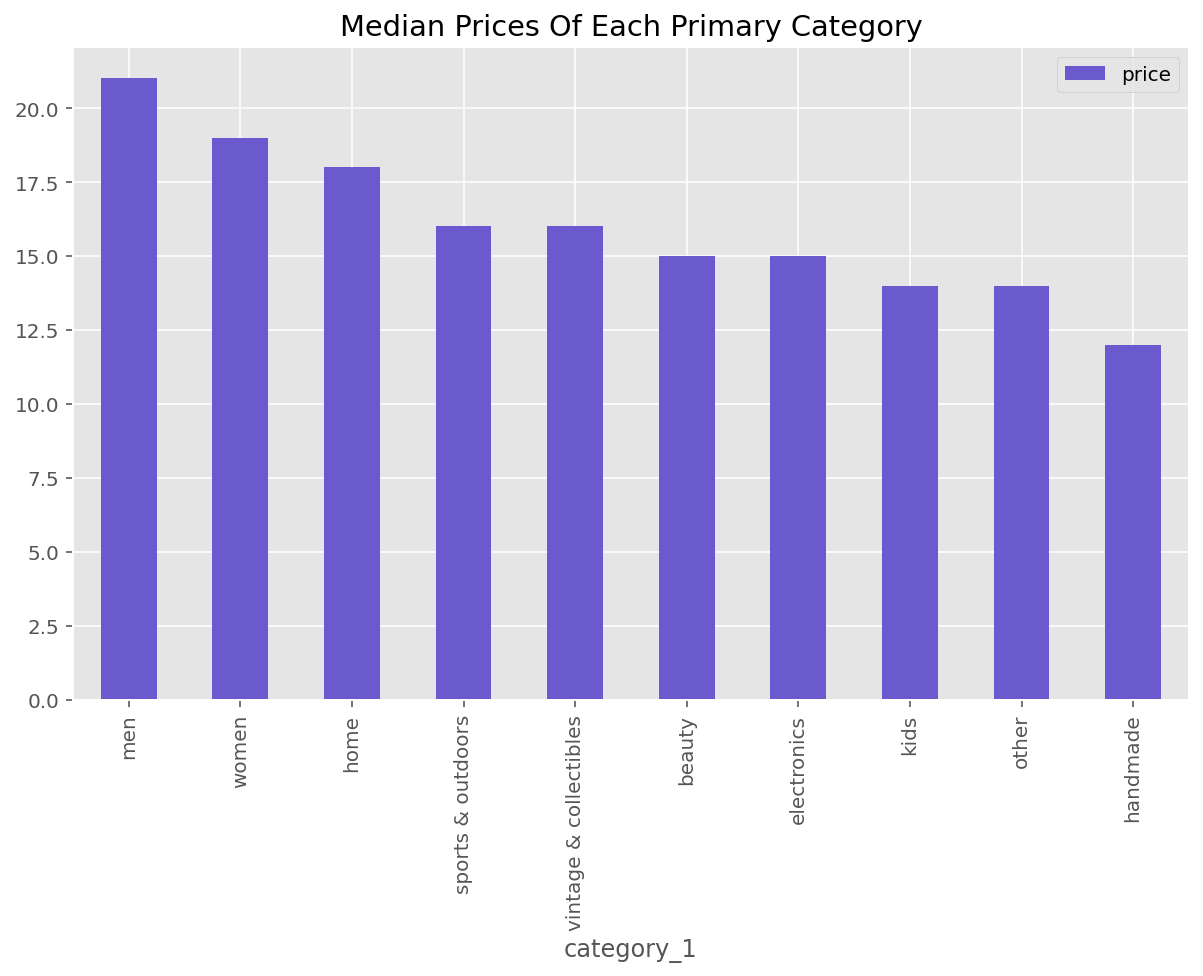

In [284]:
pc2 = data.groupby('category_1').median().sort_values(by='price_log', ascending=False)
pc2['price'].plot(kind='bar', figsize=(10,6), color='slateblue', title='Median Prices Of Each Primary Category', legend=True);

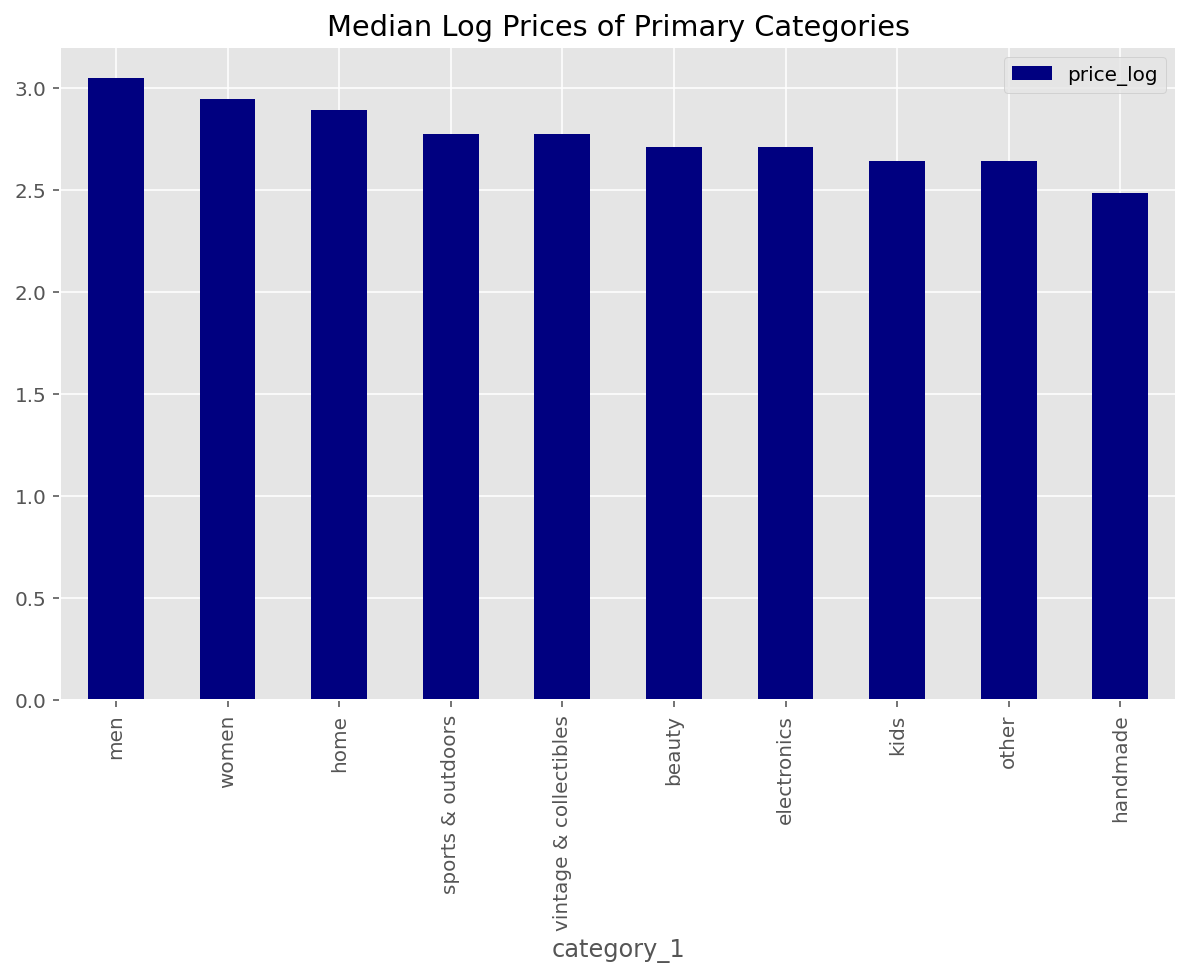

In [285]:
pc2['price_log'].plot(kind='bar', figsize=(10,6), color='navy', title='Median Log Prices of Primary Categories', legend=True);

In [286]:
#the median price and price log is highest for men's category
#this indicates that men's products tend to cost more than any other category in this app

CATEGORY 2

In [287]:
data.category_2.value_counts()

athletic apparel        134321
makeup                  124567
tops & blouses          106891
shoes                   100384
jewelry                  61730
                         ...  
candles                     64
ceramics and pottery        57
dolls and miniatures        49
books and zines             46
quilts                      31
Name: category_2, Length: 113, dtype: int64

In [310]:
#mean price and price log of category 2
data.groupby('category_2')[['price', 'price_log']].mean().sort_values(by='price', ascending=False)

price  price_log
category_2                                 
computers & tablets    87.970533   3.775360
cameras & photography  71.361761   3.706455
strollers              67.280922   3.674315
bags and purses        61.810448   3.448856
women's handbags       58.244828   3.542687
...                          ...        ...
children               12.664251   2.272665
quilts                 12.258065   2.147604
magazines              12.200913   2.293990
geekery                11.990909   2.327005
paper goods            10.776059   1.935908

[113 rows x 2 columns]

In [311]:
#mean price and price log of top 20 in category 2
data.groupby('category_2')[['price', 'price_log']].mean().sort_values(by='price', ascending=False).head(20)

price  price_log
category_2                                    
computers & tablets       87.970533   3.775360
cameras & photography     71.361761   3.706455
strollers                 67.280922   3.674315
bags and purses           61.810448   3.448856
women's handbags          58.244828   3.542687
musical instruments       46.729389   3.357915
tv, audio & surveillance  44.183757   3.336076
footwear                  42.998148   3.485085
shoes                     41.839546   3.425765
golf                      41.658750   3.276521
car audio, video & gps    37.874031   3.274059
home appliances           37.812838   3.246732
suits                     37.151515   3.436065
safety                    36.982412   3.147657
coats & jackets           34.164073   3.291354
men's accessories         33.837478   3.114367
furniture                 33.837079   3.199574
video games & consoles    32.018413   3.020791
diapering                 31.408938   3.134300
women's accessories       30.949083   2.995415

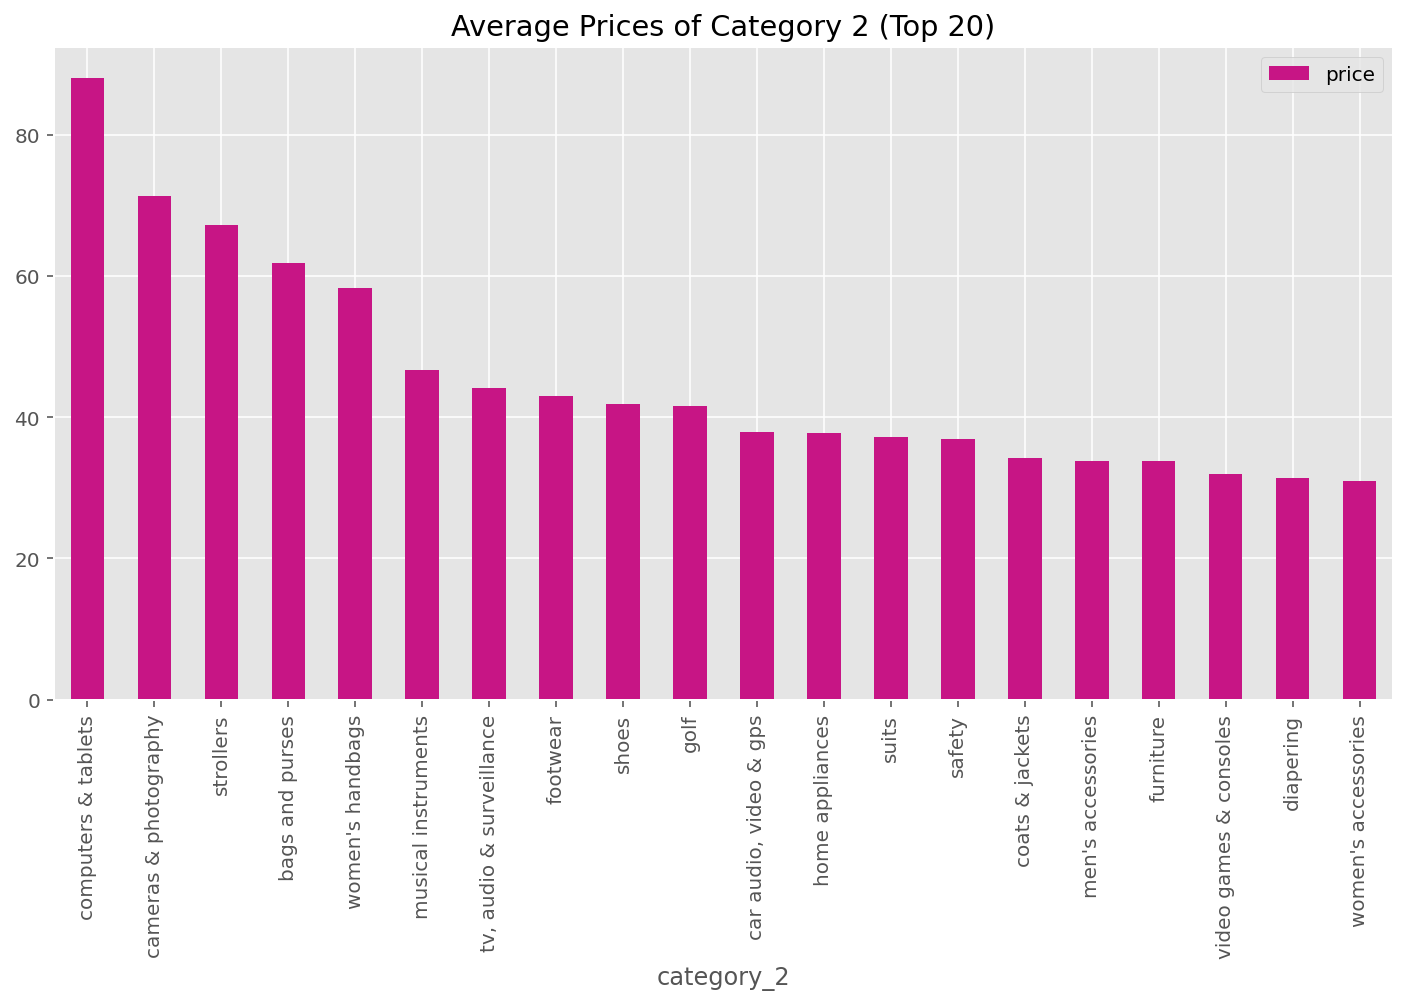

In [307]:
sc = data.groupby('category_2').mean().sort_values(by='price', ascending=False).head(20)
sc['price'].plot(kind='bar', color = 'mediumvioletred', figsize=(12,6), y='price', title='Average Prices of Category 2 (Top 20)',
                 legend=True);

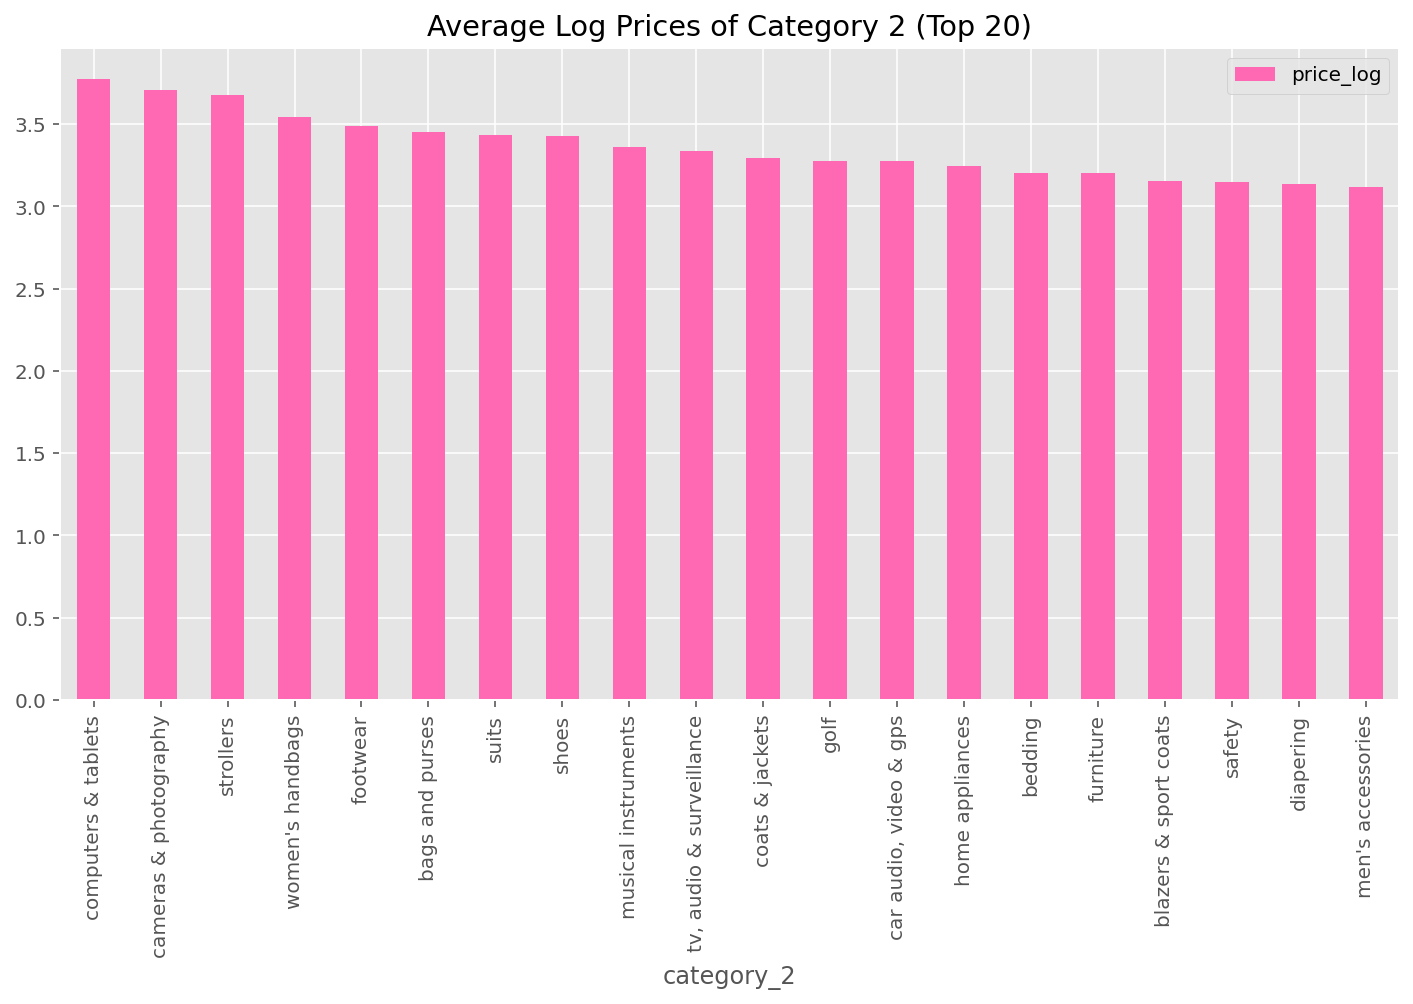

In [296]:
sc['price_log'].plot(kind='bar', color = 'hotpink', figsize=(12,6), y='price', title='Average Log Prices of Category 2 (Top 20)',
                 legend=True);

In [292]:
#median prices of category 2:

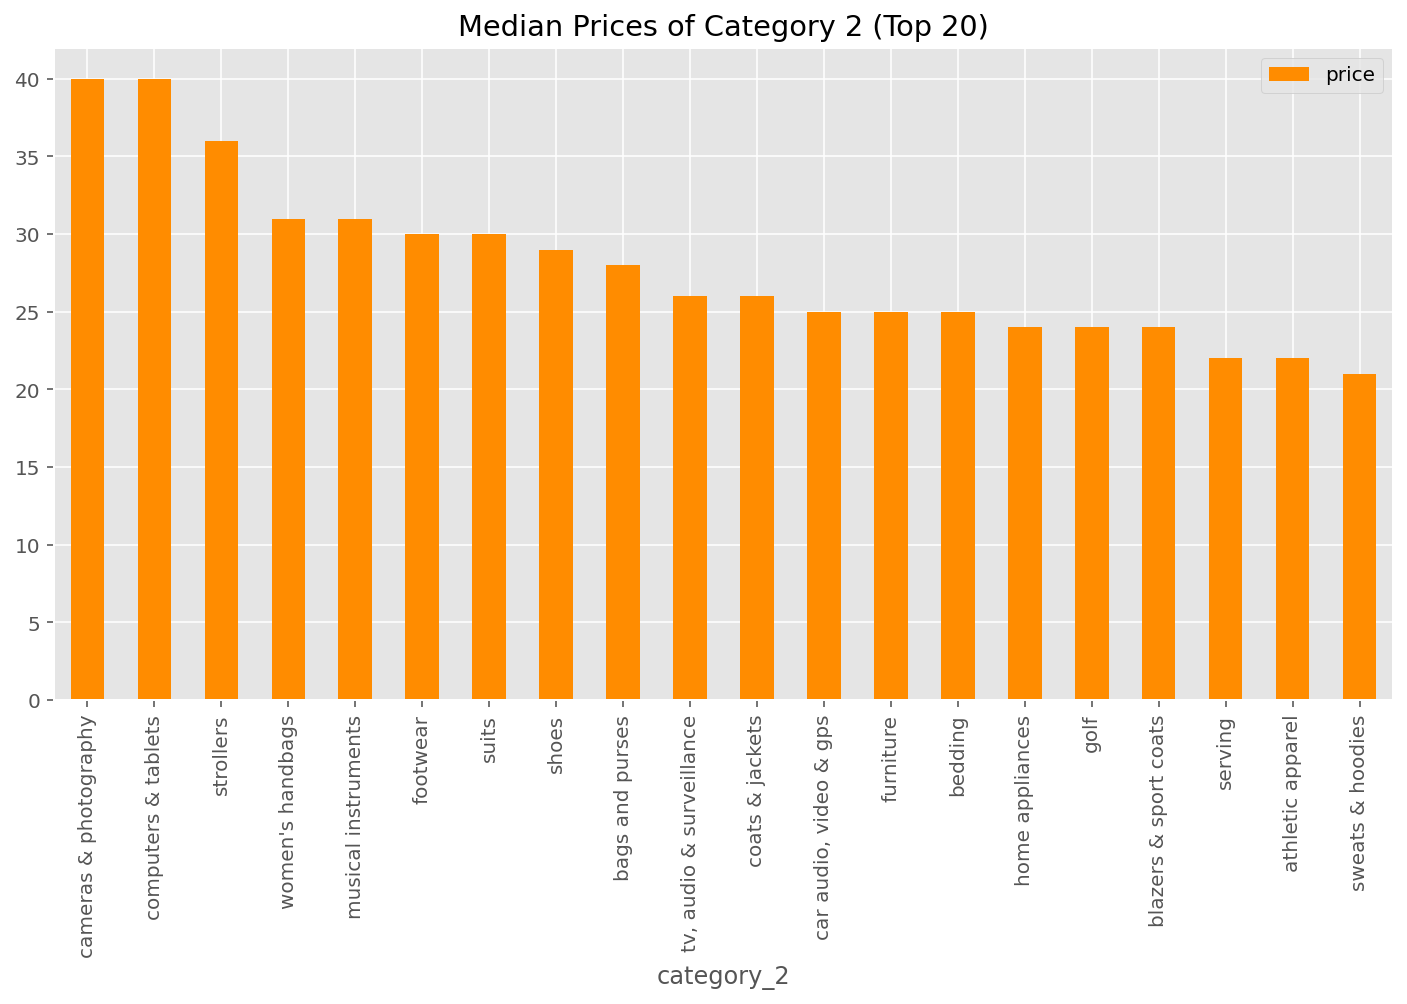

In [312]:
sc = data.groupby('category_2')[['price', 'price_log']].median().sort_values(by='price', ascending=False).head(20)
sc['price'].plot(kind='bar', color = 'darkorange', figsize=(12,6), y='price', title='Median Prices of Category 2 (Top 20)',
                 legend=True);

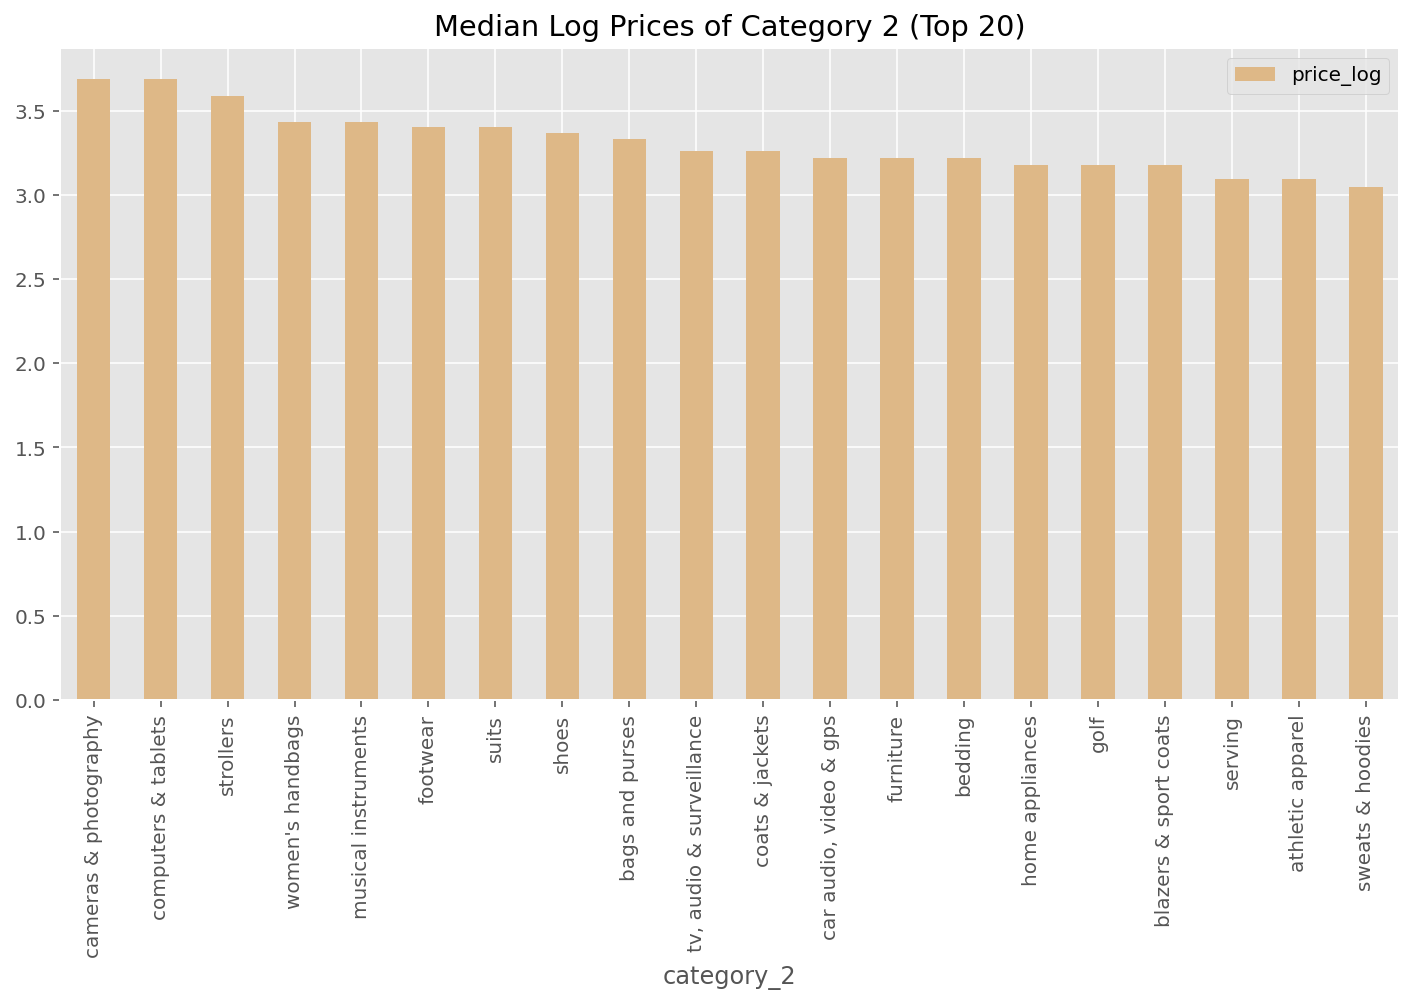

In [298]:
sc['price_log'].plot(kind='bar', color = 'burlywood', figsize=(12,6), y='price', title='Median Log Prices of Category 2 (Top 20)',
                 legend=True);

CATEGORY 3

In [299]:
data.category_3

0                     t-shirts
1           components & parts
2                       blouse
3           home décor accents
4                    necklaces
                  ...         
1482530               mid-calf
1482531                dresses
1482532    fitness accessories
1482533     home décor accents
1482534                wallets
Name: category_3, Length: 1475343, dtype: object

In [300]:
data.category_3.value_counts()

t-shirts                   61444
pants, tights, leggings    60152
other                      50198
face                       50145
shoes                      32137
                           ...  
child friendly                 1
primitive                      1
videogame                      1
st patricks                    1
seasonal                       1
Name: category_3, Length: 869, dtype: int64

In [301]:
#top 20 categories:
data.category_3.value_counts().head(20)

t-shirts                   61444
pants, tights, leggings    60152
other                      50198
face                       50145
shoes                      32137
games                      30894
lips                       30860
athletic                   27037
eyes                       26021
cases, covers & skins      24668
shorts                     21805
bras                       21254
blouse                     20273
tank, cami                 20270
boots                      20258
above knee, mini           20068
necklaces                  19750
makeup palettes            19091
women                      18961
shirts & tops              16867
Name: category_3, dtype: int64

In [313]:
data.groupby('category_3')[['price', 'price_log']].mean().sort_values(by='price', ascending=False)

price  price_log
category_3                                   
laptops & netbooks      177.089176   4.518004
standard                163.666667   4.713334
desktops & all-in-ones  149.329412   4.423975
handbag                 139.664714   4.158803
travel systems          124.600000   4.384675
...                            ...        ...
graphic design            6.000000   1.757519
patch                     5.560917   1.580645
books and zines           5.500000   1.589027
artist bears              5.000000   1.609438
mirror                    5.000000   1.609438

[869 rows x 2 columns]

In [314]:
data.groupby('category_3')[['price', 'price_log']].mean().sort_values(by='price', ascending=False).head(20)

price  price_log
category_3                                        
laptops & netbooks           177.089176   4.518004
standard                     163.666667   4.713334
desktops & all-in-ones       149.329412   4.423975
handbag                      139.664714   4.158803
travel systems               124.600000   4.384675
air conditioners             121.142857   4.575701
lightweight                  117.111111   4.479247
digital cameras              112.305349   4.174575
satchel                      111.720292   4.349088
cell phones & smartphones    109.184825   4.105680
brass instruments             97.833333   3.837206
wind & woodwind instruments   94.753425   3.998720
consoles                      90.219448   4.129797
oils & fluids                 87.333333   4.361865
vacuums & floor care          86.523148   3.932989
women's golf clubs            85.750000   4.048138
lenses & filters              82.832487   4.073217
men's golf clubs              81.226667   4.001643
music                         78.500000   3.473585
car subwoofers                76.095238   4.091624

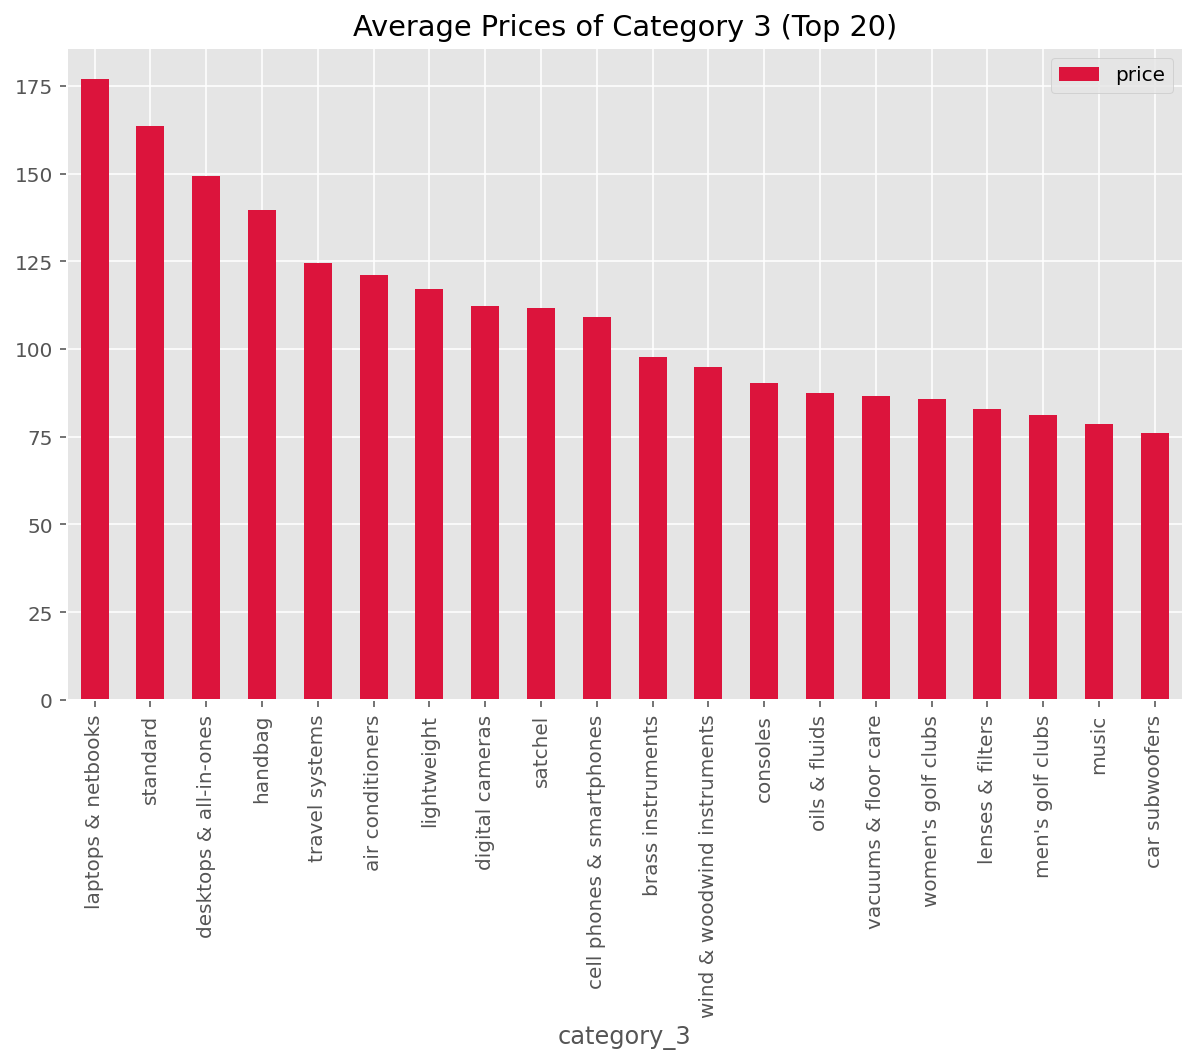

In [305]:
tc = data.groupby('category_3').mean().sort_values(by='price', ascending=False).head(20)
tc['price'].plot(kind='bar', color = 'crimson', figsize=(10,6), y='price', title='Average Prices of Category 3 (Top 20)',
                 legend=True);

In [306]:
#highest average price is for laptops and netbooks

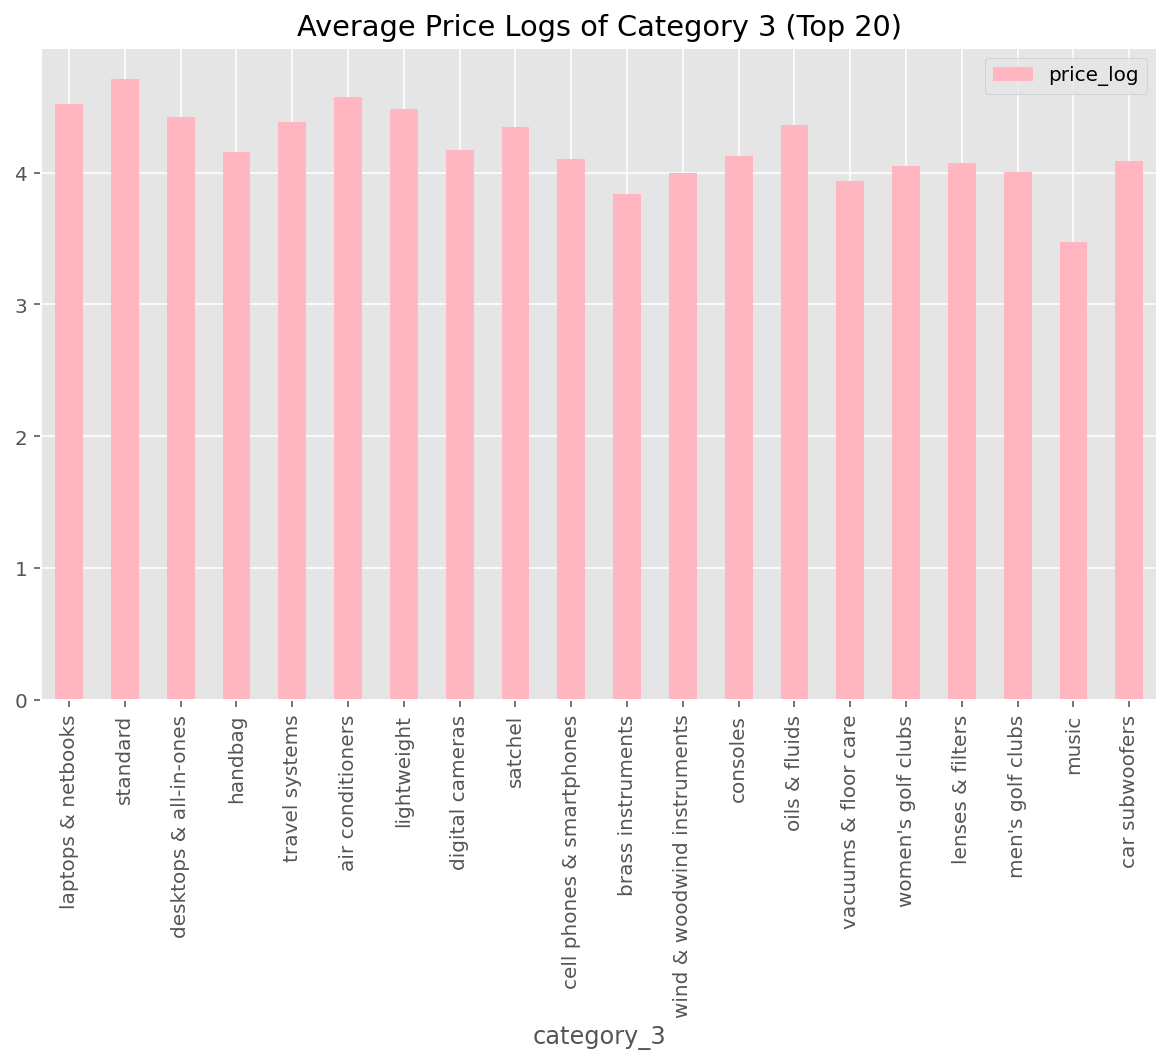

In [316]:
tc['price_log'].plot(kind='bar', color = 'lightpink', figsize=(10,6), y='price', title='Average Price Logs of Category 3 (Top 20)',
                 legend=True);

In [317]:
#highest average log price is for standard category of products

In [318]:
#median for category 3
data.groupby('category_3')[['price', 'price_log']].median().sort_values(by='price', ascending=False).head(20)

price  price_log
category_3                                   
standard                     145.0   4.976734
air conditioners             131.0   4.875197
lightweight                  105.0   4.653960
laptops & netbooks           100.0   4.605170
women's golf clubs           100.0   4.603919
travel systems                95.0   4.553877
satchel                       91.0   4.510860
desktops & all-in-ones        89.5   4.494223
oils & fluids                 85.0   4.442651
lenses & filters              70.0   4.248495
track & sweat suits           66.0   4.189655
cell phones & smartphones     65.0   4.174387
wind & woodwind instruments   64.0   4.158883
digital cameras               61.0   4.110874
feather beds                  60.0   4.094345
garbage disposals             60.0   4.094345
car subwoofers                59.0   4.077537
consoles                      56.0   4.025352
handbag                       55.5   4.016342
electronics for kids          55.0   4.007333

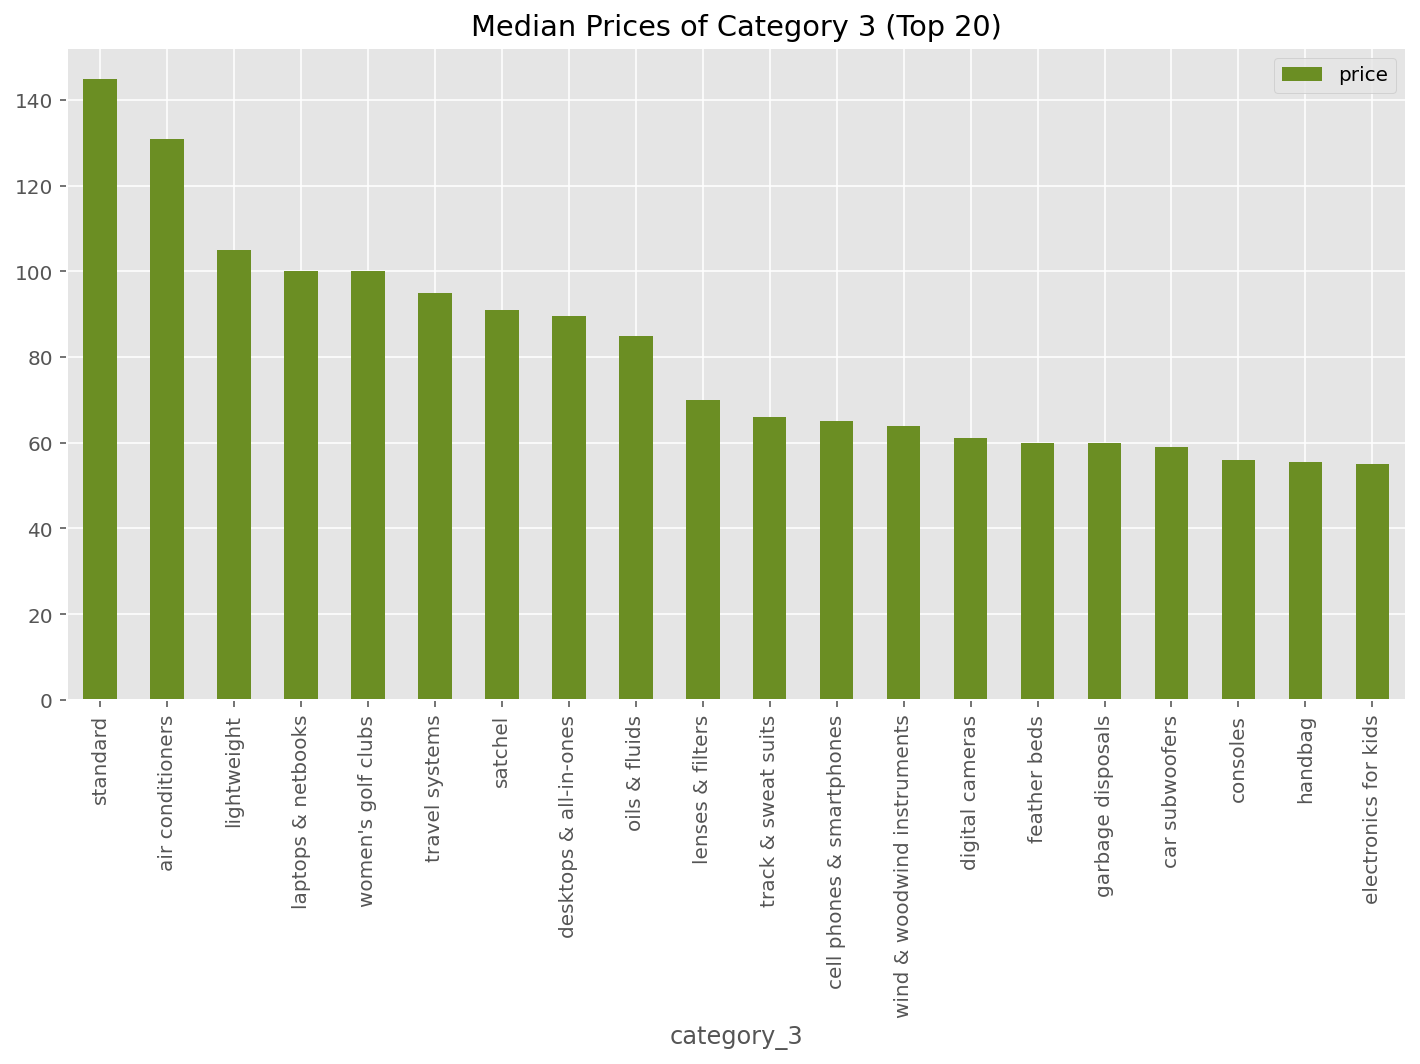

In [319]:
tc = data.groupby('category_3').median().sort_values(by='price', ascending=False).head(20)
tc['price'].plot(kind='bar', color = 'olivedrab', figsize=(12,6), y='price', title='Median Prices of Category 3 (Top 20)',
                 legend=True);

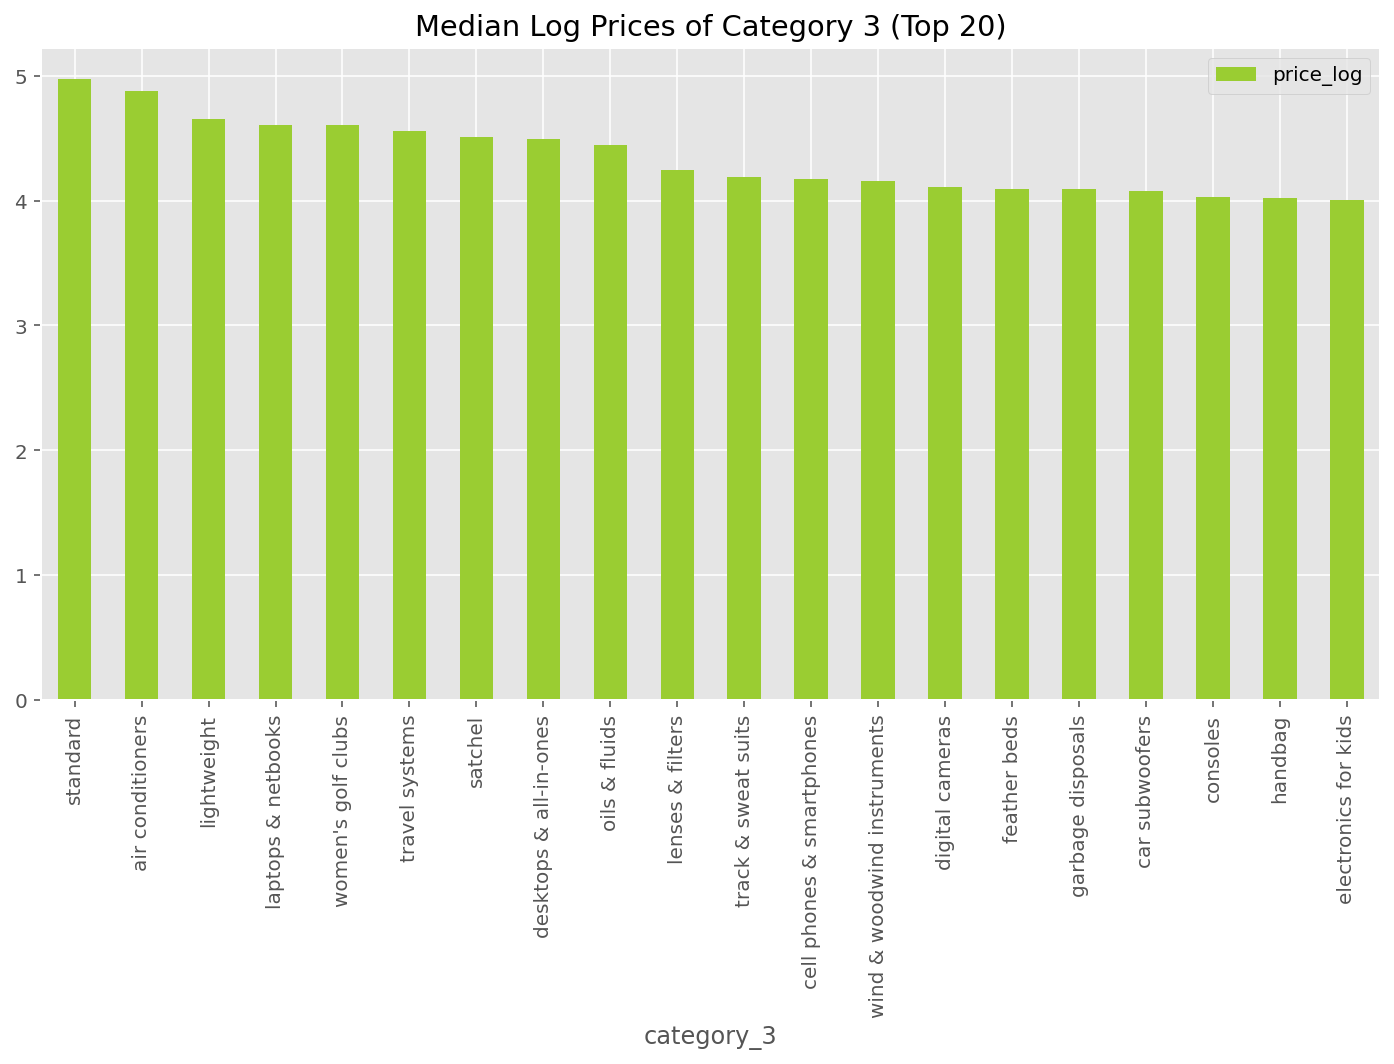

In [320]:
tc['price_log'].plot(kind='bar', color = 'yellowgreen', figsize=(12,6), y='price', title='Median Log Prices of Category 3 (Top 20)',
                 legend=True);

CATEGORY 4

In [322]:
data.category_4.unique()

array(['nan', 'tablet', 'ballet', 'outdoor games', 'baseball', 'bomber',
       'serving'], dtype=object)

In [323]:
data.category_4.value_counts()

nan              1470958
tablet              3055
ballet               598
outdoor games        413
bomber               273
baseball              44
serving                2
Name: category_4, dtype: int64

In [325]:
data.groupby('category_4')[['price', 'price_log']].mean().sort_values(by='price_log', ascending=False)

price  price_log
category_4                         
tablet         73.680196   3.776486
serving        51.500000   3.619248
bomber         40.117216   3.463713
baseball       33.545455   3.376230
outdoor games  39.772397   3.339472
nan            26.659615   2.911173
ballet         15.602007   2.605873

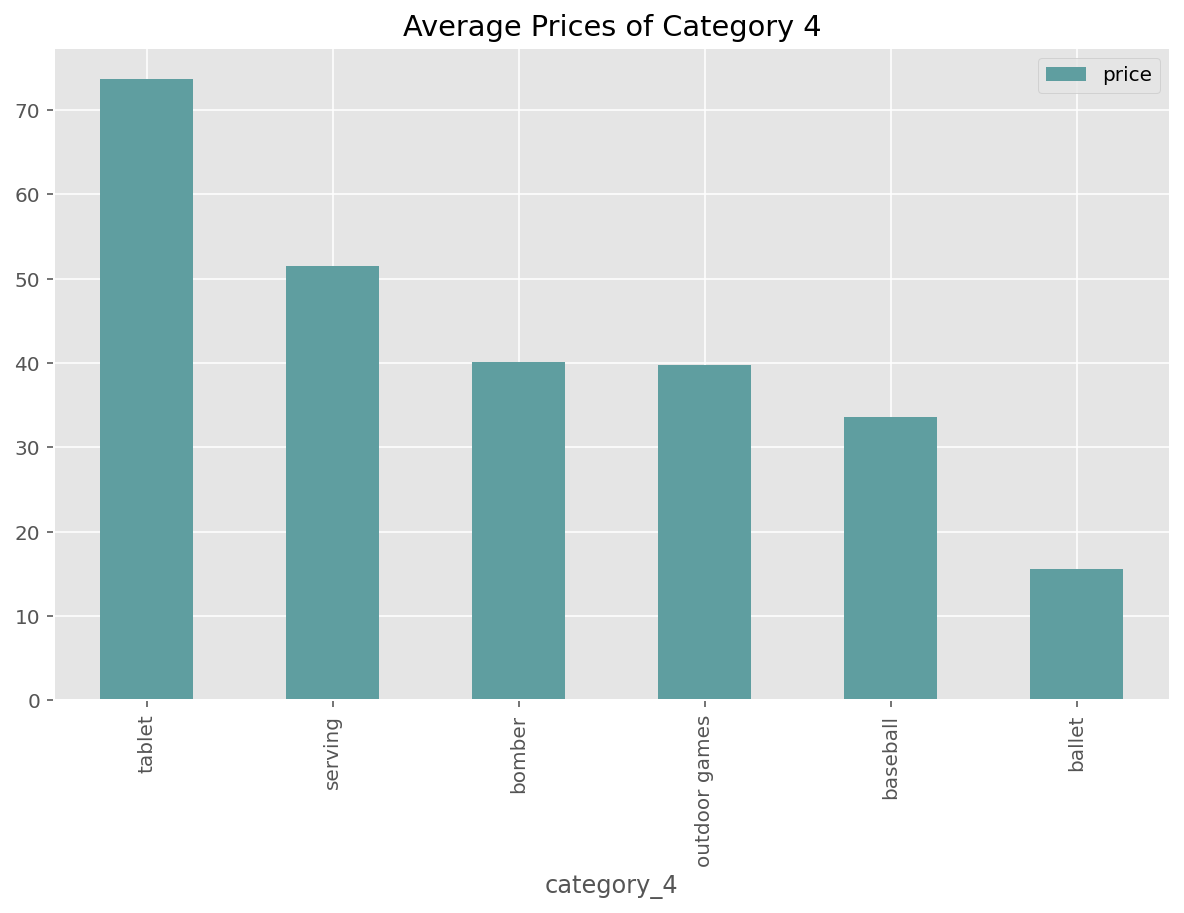

In [328]:
qc = data.groupby('category_4').mean().sort_values(by='price', ascending=False).iloc[[0,1,2,3,4,6], :]
qc['price'].plot(kind='bar', color = 'cadetblue', figsize=(10,6), y='price', title='Average Prices of Category 4',
                 legend=True);

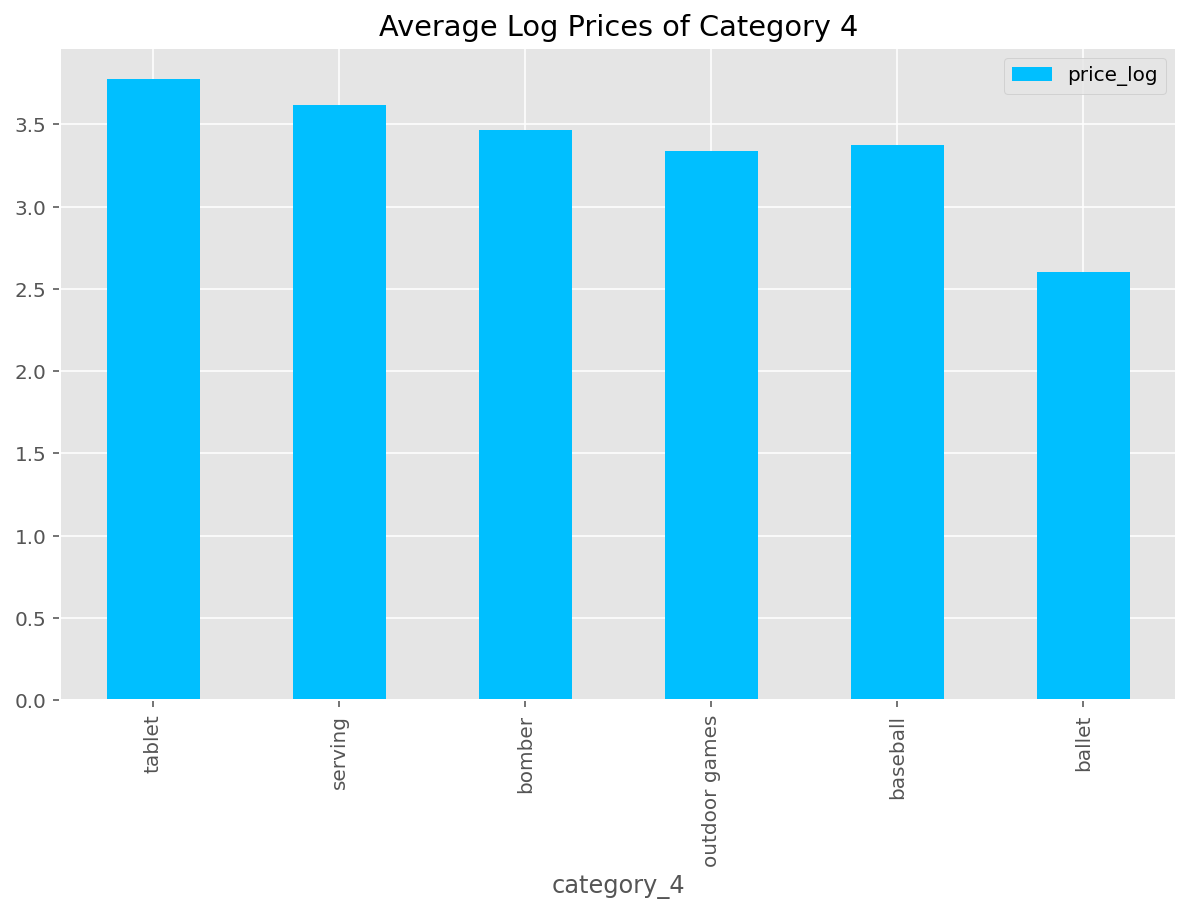

In [329]:
qc['price_log'].plot(kind='bar', color = 'deepskyblue', figsize=(10,6), y='price_log', title='Average Log Prices of Category 4',
                 legend=True);

In [330]:
#median
data.groupby('category_4')[['price', 'price_log']].median().sort_values(by='price', ascending=False)

price  price_log
category_4                     
serving         51.5   3.619248
tablet          44.0   3.784190
baseball        30.0   3.401197
bomber          30.0   3.401197
outdoor games   26.0   3.258097
nan             17.0   2.833213
ballet          12.0   2.484907

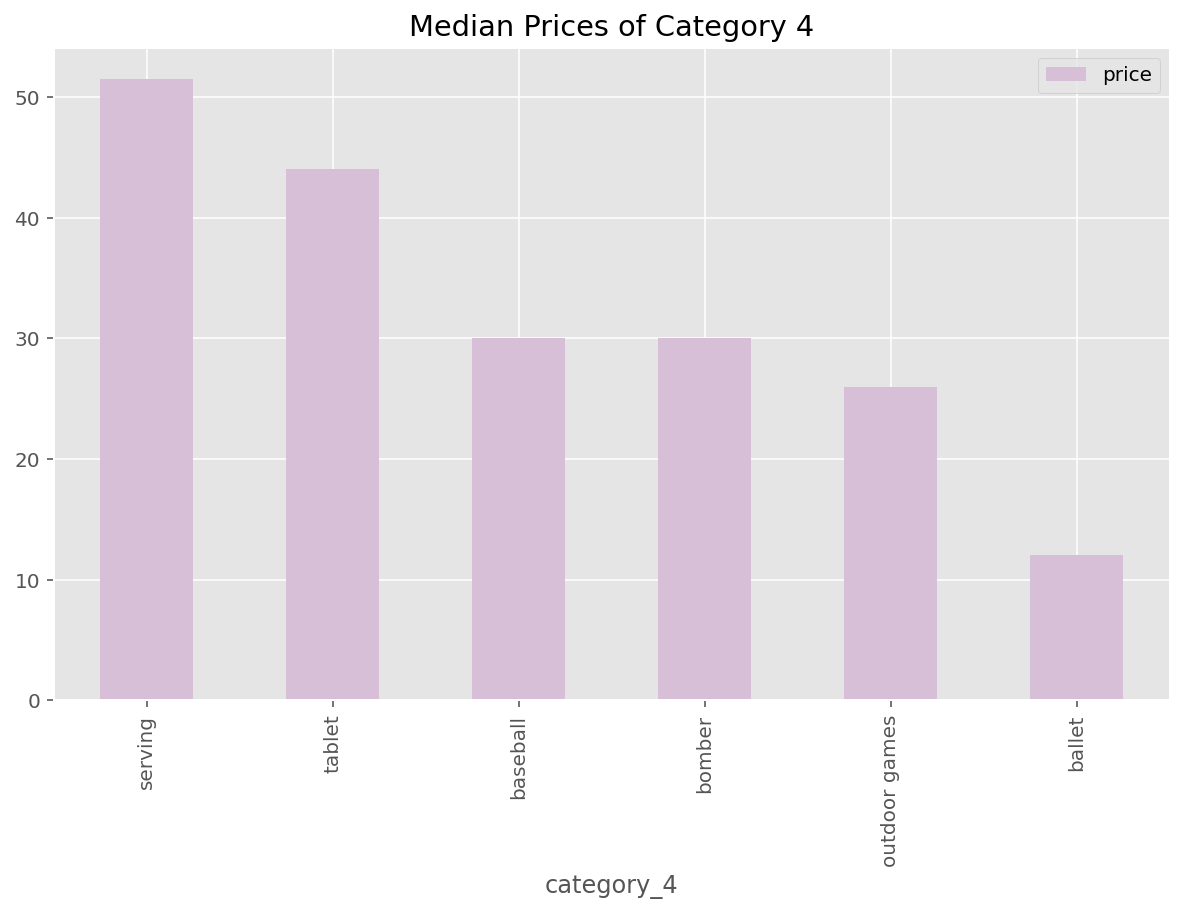

In [332]:
qc = data.groupby('category_4').median().sort_values(by='price', ascending=False).iloc[[0,1,2,3,4,6], :]
qc['price'].plot(kind='bar', color = 'thistle', figsize=(10,6), y='price', title='Median Prices of Category 4',
                 legend=True);

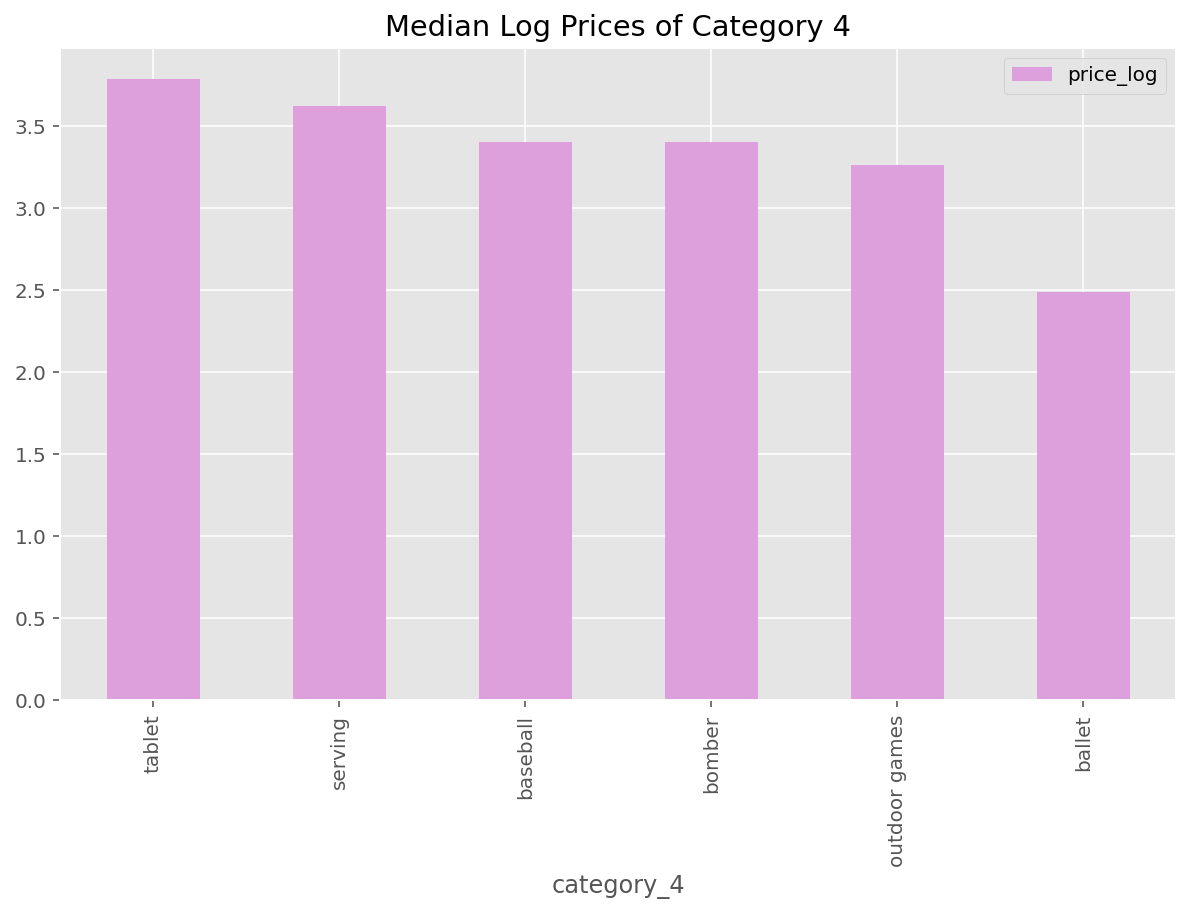

In [334]:
qc = data.groupby('category_4').median().sort_values(by='price_log', ascending=False).iloc[[0,1,2,3,4,6], :]
qc['price_log'].plot(kind='bar', color = 'plum', figsize=(10,6), y='price_log', title='Median Log Prices of Category 4',
                 legend=True);

In [335]:
#the highest average price is for tablets, whereas highest median price value is for serving products (price), and 
#tablets (price_log)

PRESENCE OR ABSENCE OF BRAND NAME 

In [337]:
data['brand_p/a'].value_counts()

Present    846461
Absent     628882
Name: brand_p/a, dtype: int64

In [338]:
#the presence or absence of a brand name in a listing may have an influence on the pricing set by sellers.

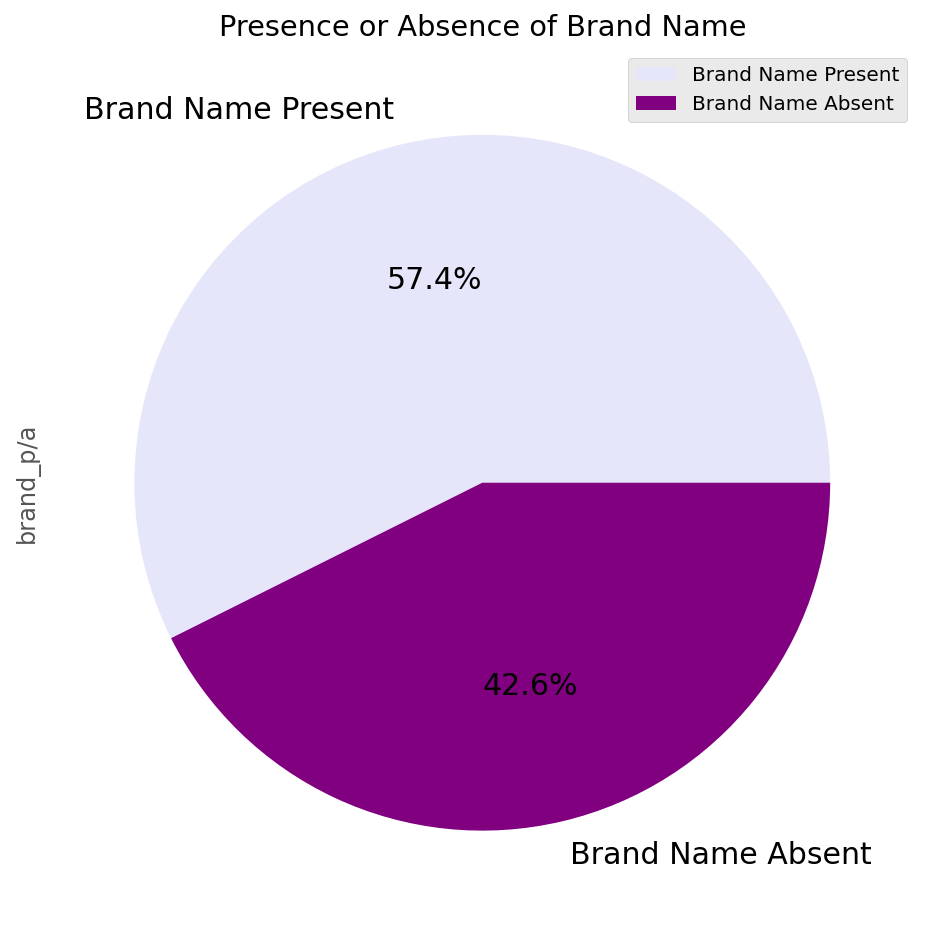

In [339]:
b = data['brand_p/a'].value_counts(normalize=True)*100
colors = ['lavender', 'purple']
b.plot(kind='pie', labels=['Brand Name Present', 'Brand Name Absent'], fontsize=15, autopct="%.1f%%", colors=colors,
       title ='Presence or Absence of Brand Name', legend=True, figsize=(8,8));

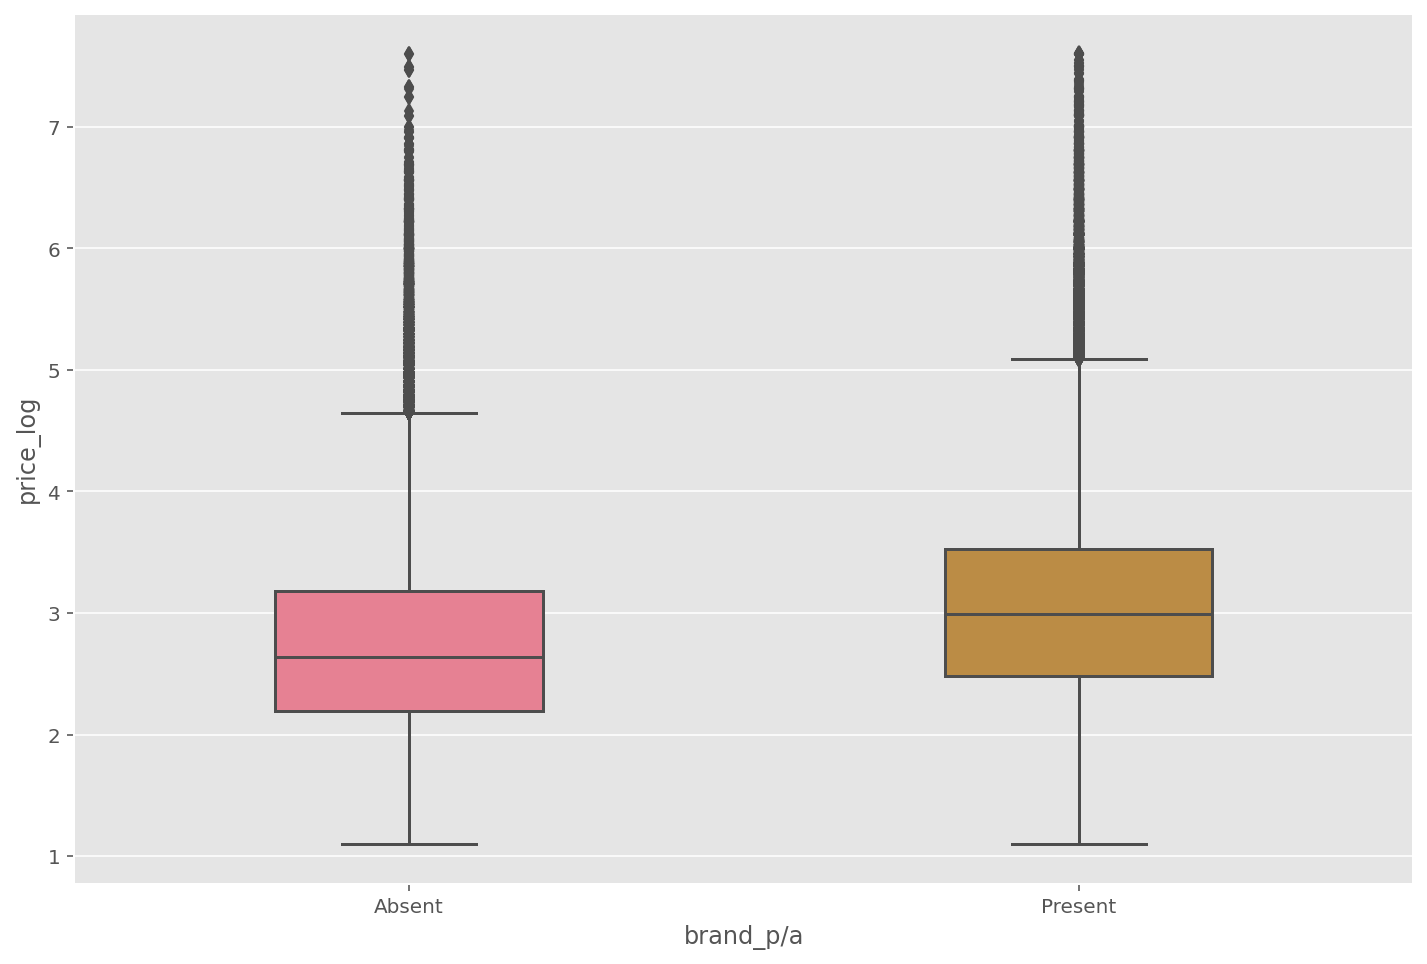

In [340]:
#changes in average price if brand name is present or not:

plt.figure(figsize=(12,8))
sns.boxplot(x = 'brand_p/a', y = 'price_log',
            data = data, palette = sns.color_palette("husl", 8),
           fliersize=5, width=0.4)
plt.show();

In [341]:
#we can see that having the brand name present in the product listing increases the average price listed for the product
#sellers choose to price their listings higher if there is a clear brand name establshed. 
#sellers can be adviced to include brand name in their listing in order to increase their prices. 

PRESENCE OR ABSENCE OF ITEM DESCRIPTION

In [344]:
data['description_p/a'].value_counts()

Present    1393524
Absent       81819
Name: description_p/a, dtype: int64

In [345]:
data['description_p/a'].value_counts(normalize=True)*100

Present    94.454239
Absent      5.545761
Name: description_p/a, dtype: float64

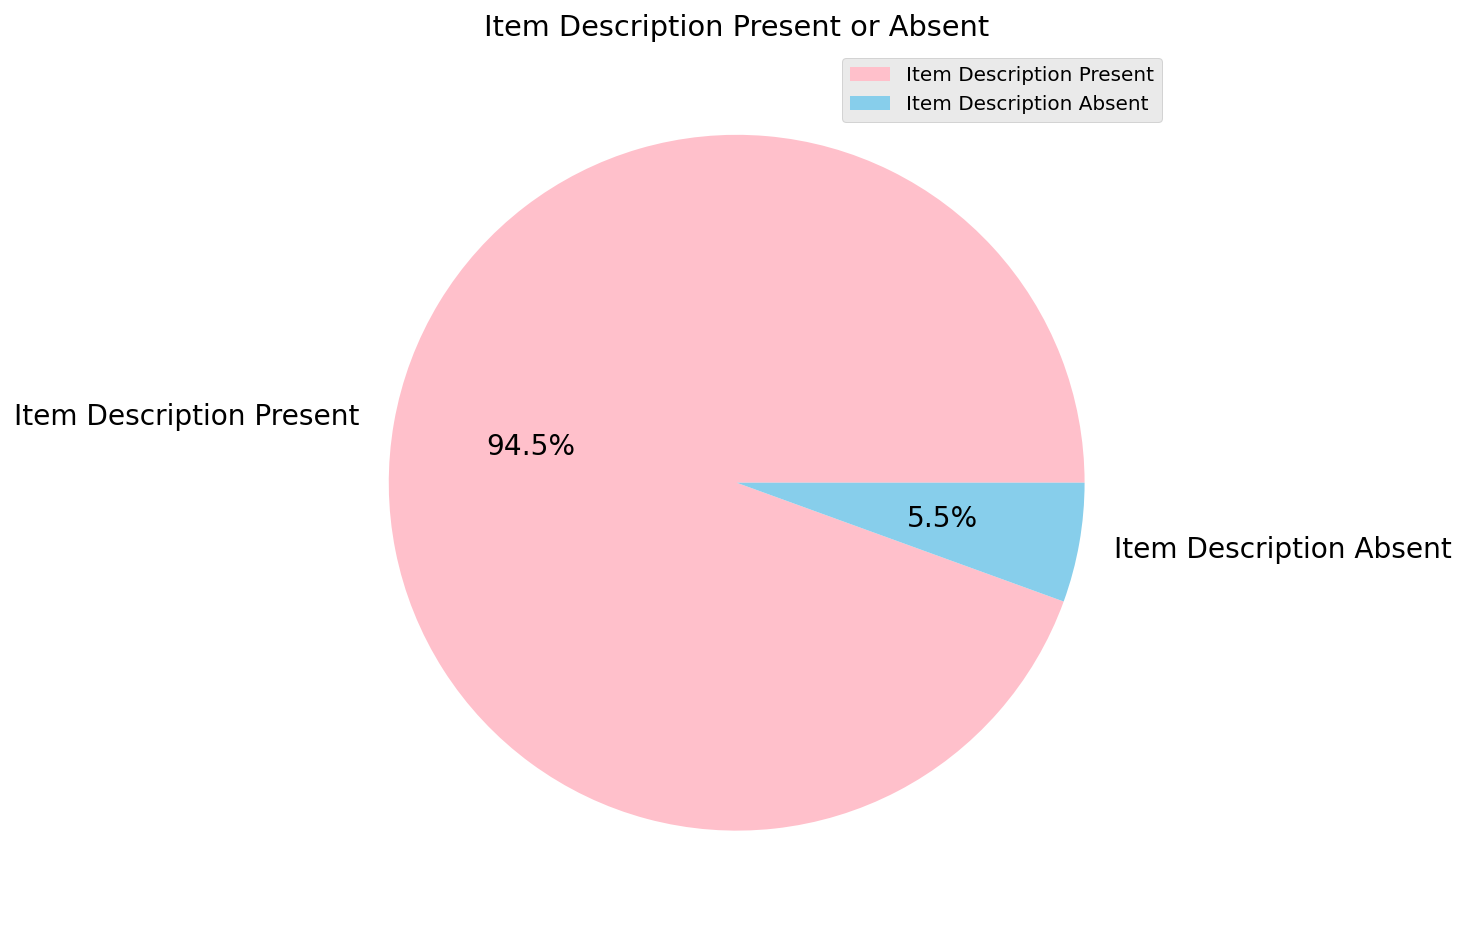

In [346]:
d = data['description_p/a'].value_counts(normalize=True)*100
colors = ['pink', 'skyblue']
d.plot(kind='pie', labels=['Item Description Present', 'Item Description Absent'], autopct="%.1f%%", colors=colors,
       fontsize =14, title ='Item Description Present or Absent', legend=True, figsize=(8,8))
plt.ylabel('')
plt.show()

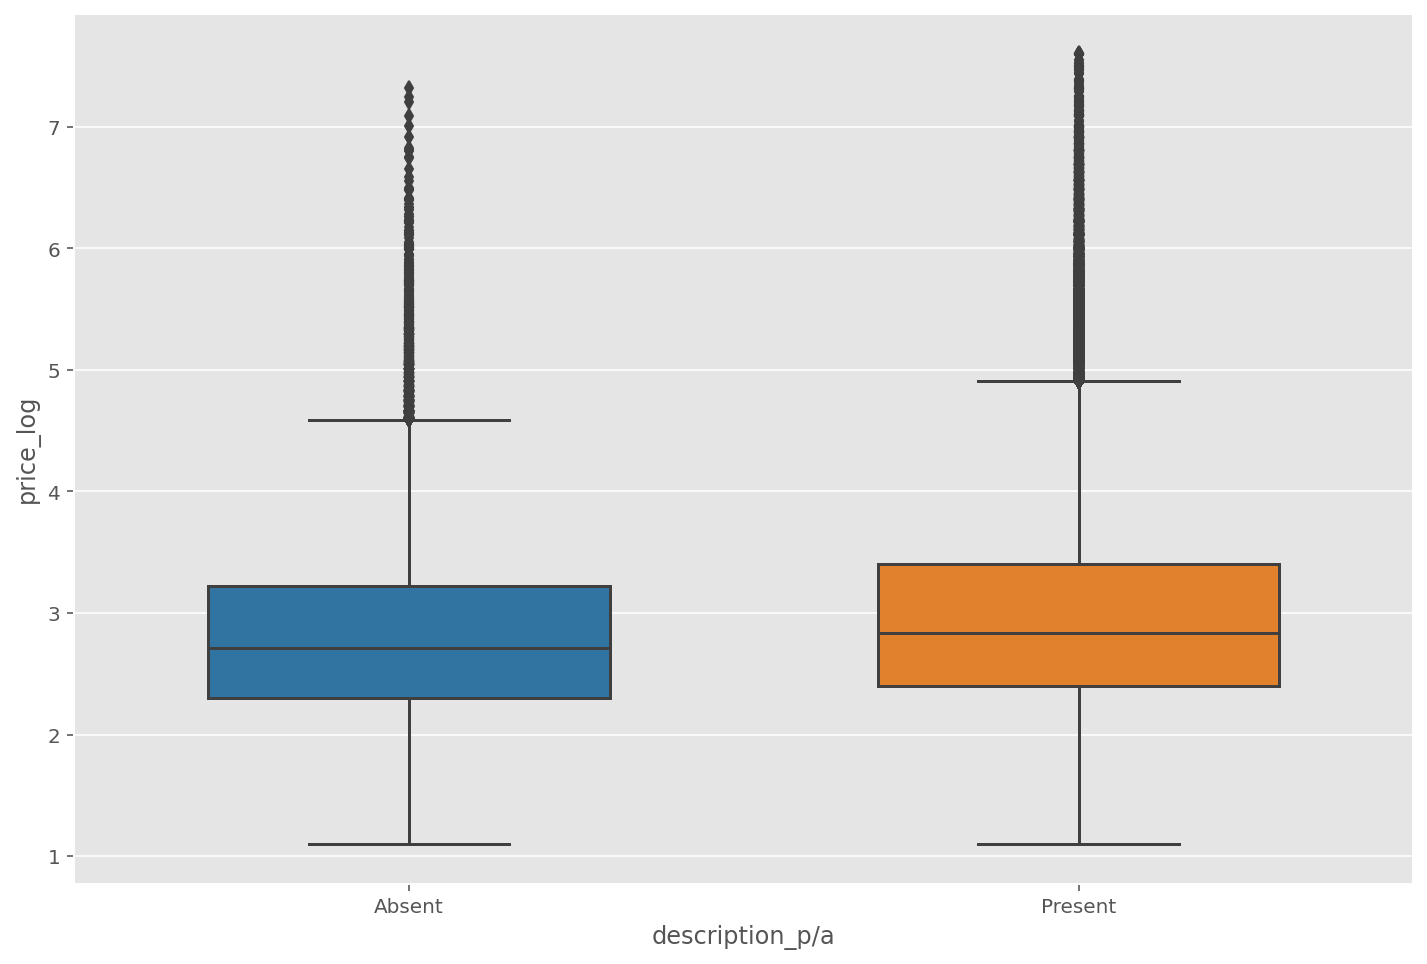

In [347]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'description_p/a', y = 'price_log',
            data = data, palette = sns.color_palette('tab10'),
           fliersize=5, width=0.6);
plt.show();

In [348]:
#the presence of item description has an impact of the median price set for the product. 
#indicates the importance of including an item description in your product listing

LENGTH OF ITEM DESCRIPTION 

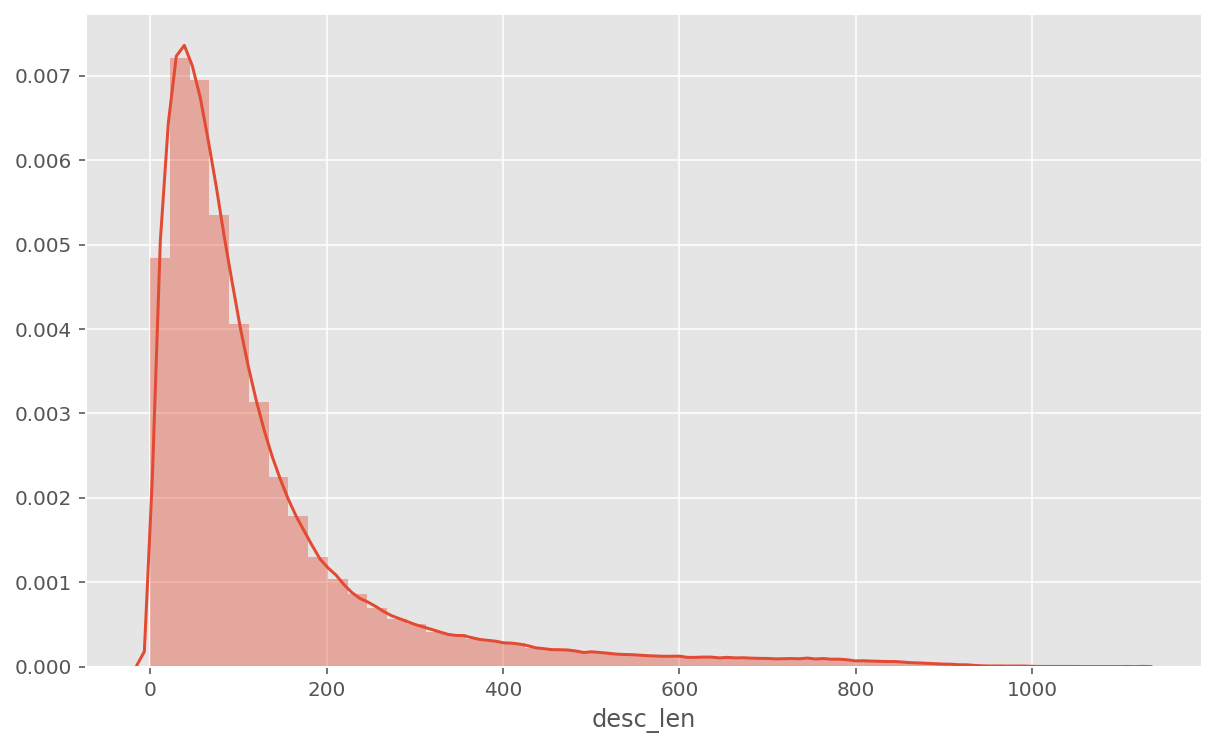

In [352]:
#distribution of item description lengths 
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(data.desc_len);

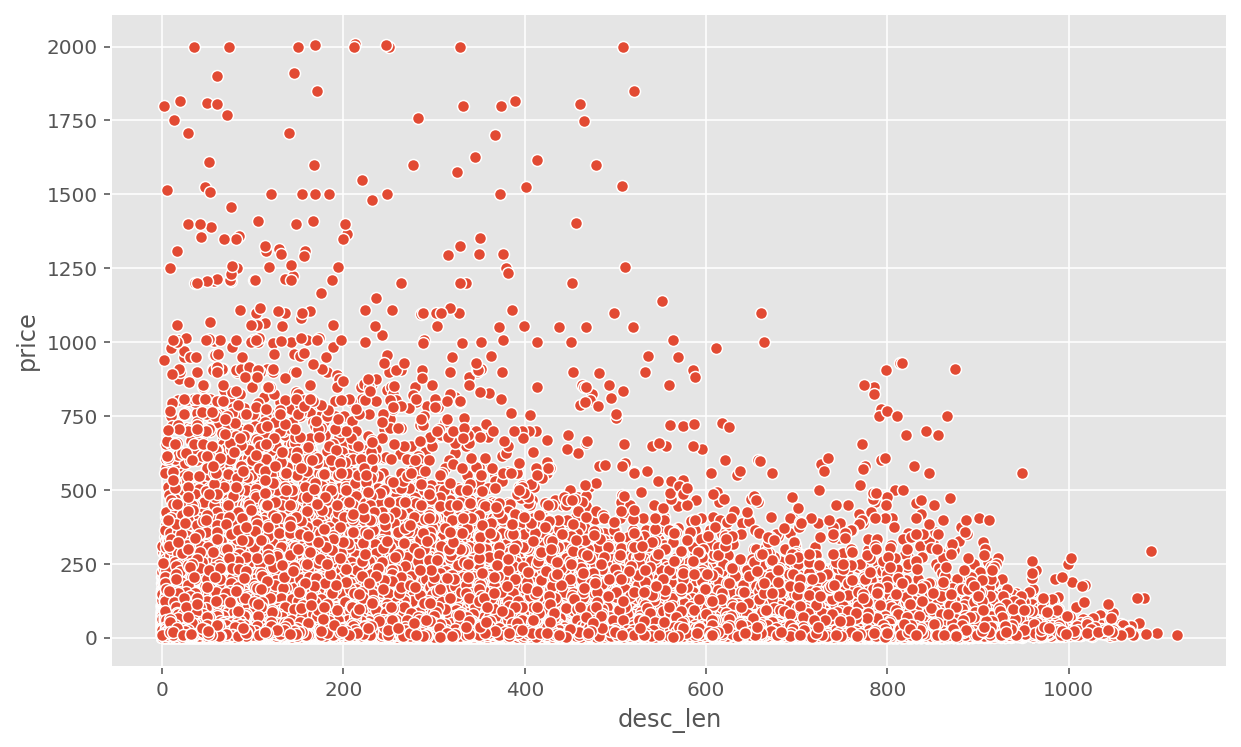

In [350]:
fig, ax = plt.subplots(figsize=(10,6))
len_ = data['desc_len']
sns.scatterplot(x= len_ , y= data['price']);

In [351]:
#there does not seem to be clear pattern between the two variales, however, we can see that generally that 
#price decreases as the length of description increases. 

In [354]:
data.desc_len.describe()

count    1.393524e+06
mean     1.302186e+02
std      1.478922e+02
min      0.000000e+00
25%      4.200000e+01
50%      8.100000e+01
75%      1.540000e+02
max      1.119000e+03
Name: desc_len, dtype: float64

In [356]:
#most listings contain description lengths of between 0 to 154 characters

In [358]:
data[['price', 'desc_len']].corr()  #weak correlation between price log and length of description

price  desc_len
price     1.000000  0.042677
desc_len  0.042677  1.000000

In [359]:
#we can categorise lengths into short, medium, long and very long:
short_len = data[data.desc_len <=250]
medium_len = data[(data['desc_len'] >250) & (data['desc_len'] <=500)]
long_len= data[(data['desc_len'] >500) & (data['desc_len'] <=750)]
vlong_len = data[data.desc_len > 750]

In [360]:
print("Average Price Logs for different description lengths:")
print("Short:", short_len['price_log'].mean())
print("Medium:", medium_len['price_log'].mean())
print("Long:", long_len['price_log'].mean())
print("Very Long:", vlong_len['price_log'].mean())

Average Price Logs for different description lengths:
Short: 2.919417019389108
Medium: 2.983581855634174
Long: 2.84257047246478
Very Long: 2.854925081681435


In [361]:
#descriptions which are of medium length tend to have slightly higher prices than other lengths

ITEM CONDITION

In [362]:
data.item_condition.value_counts()

New         638026
Good        430138
Like New    373021
Fair         31787
Poor          2371
Name: item_condition, dtype: int64

In [363]:
#keys: (e.g. clothing)
#1. New - New with tags (NWT), unworn, unaltered, and includes the original tags
#2. Like New - New without tags (NWOT) or very lightly used with no flaws or damage
#3. Good - Gently used, but still may have minor flaws such as pilling, stretching, loose threads
#4. Fair - Multiple minor flaws, defects, or damage such as rips, light stains, pilling
#5. Poor - Heavily used and has major cosmetic flaws or damage such as holes, stains, fading, or missing button/beads

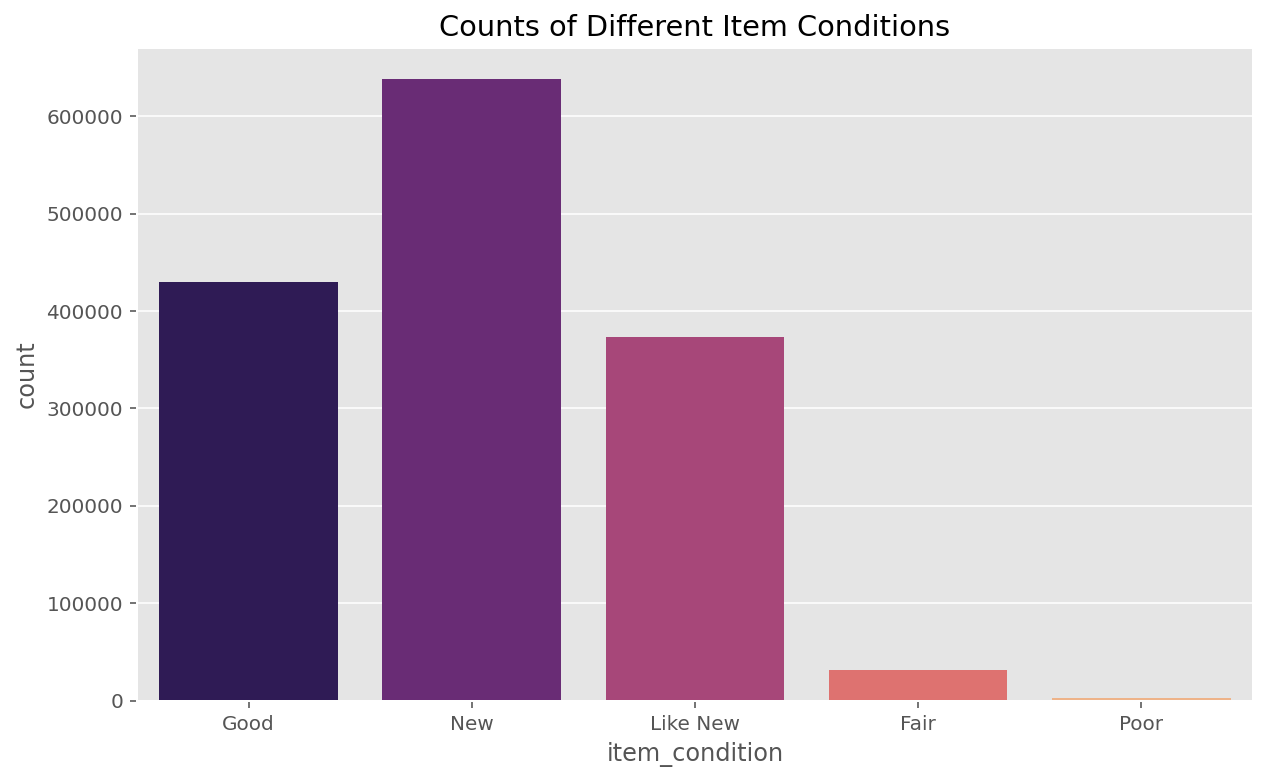

In [366]:
fig, ax =plt.subplots(figsize=(10,6))
sns.countplot(data=data, x = 'item_condition', ax=ax, palette='magma')
ax.set_title('Counts of Different Item Conditions')
plt.show();


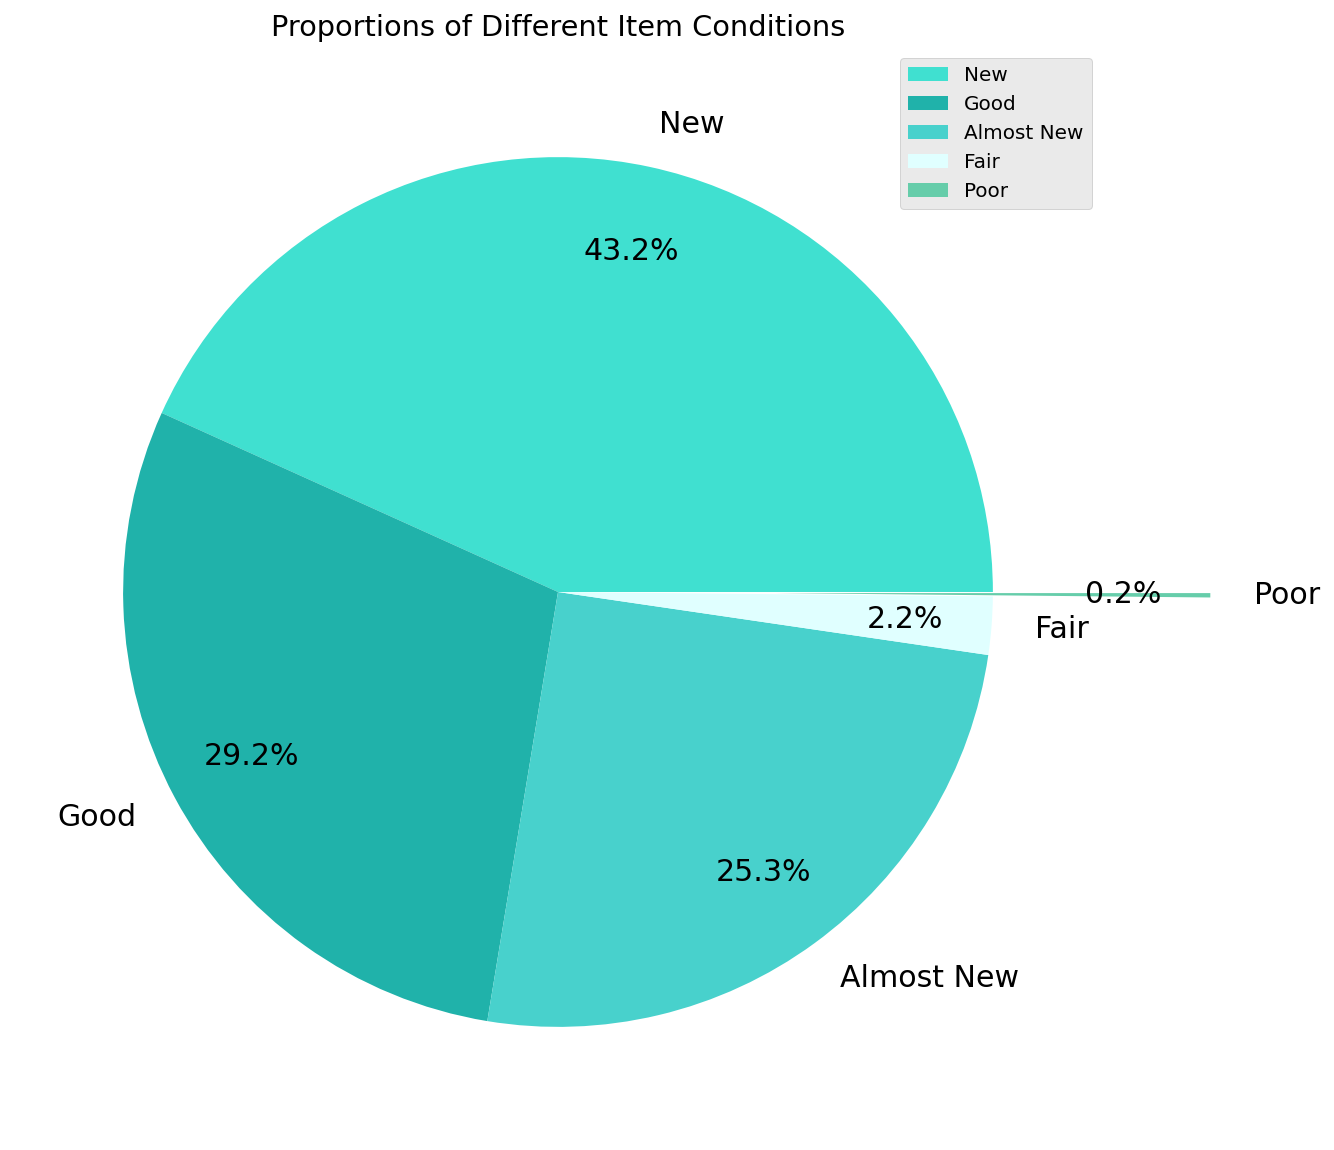

In [367]:
con = data['item_condition'].value_counts(normalize=True)*100
colors = ['turquoise', 'lightseagreen', 'mediumturquoise', 'lightcyan', 'mediumaquamarine']
explodeTuple = [0.0, 0.0, 0.0, 0.0, 0.5]
con.plot(kind='pie', labels=['New', 'Good', 'Almost New', 'Fair', 'Poor' ], fontsize=15, autopct="%.1f%%", pctdistance=0.80,
         labeldistance=1.1, colors=colors, title ='Proportions of Different Item Conditions', legend=True, figsize=(10,10), explode=explodeTuple)
plt.ylabel('')
plt.show();


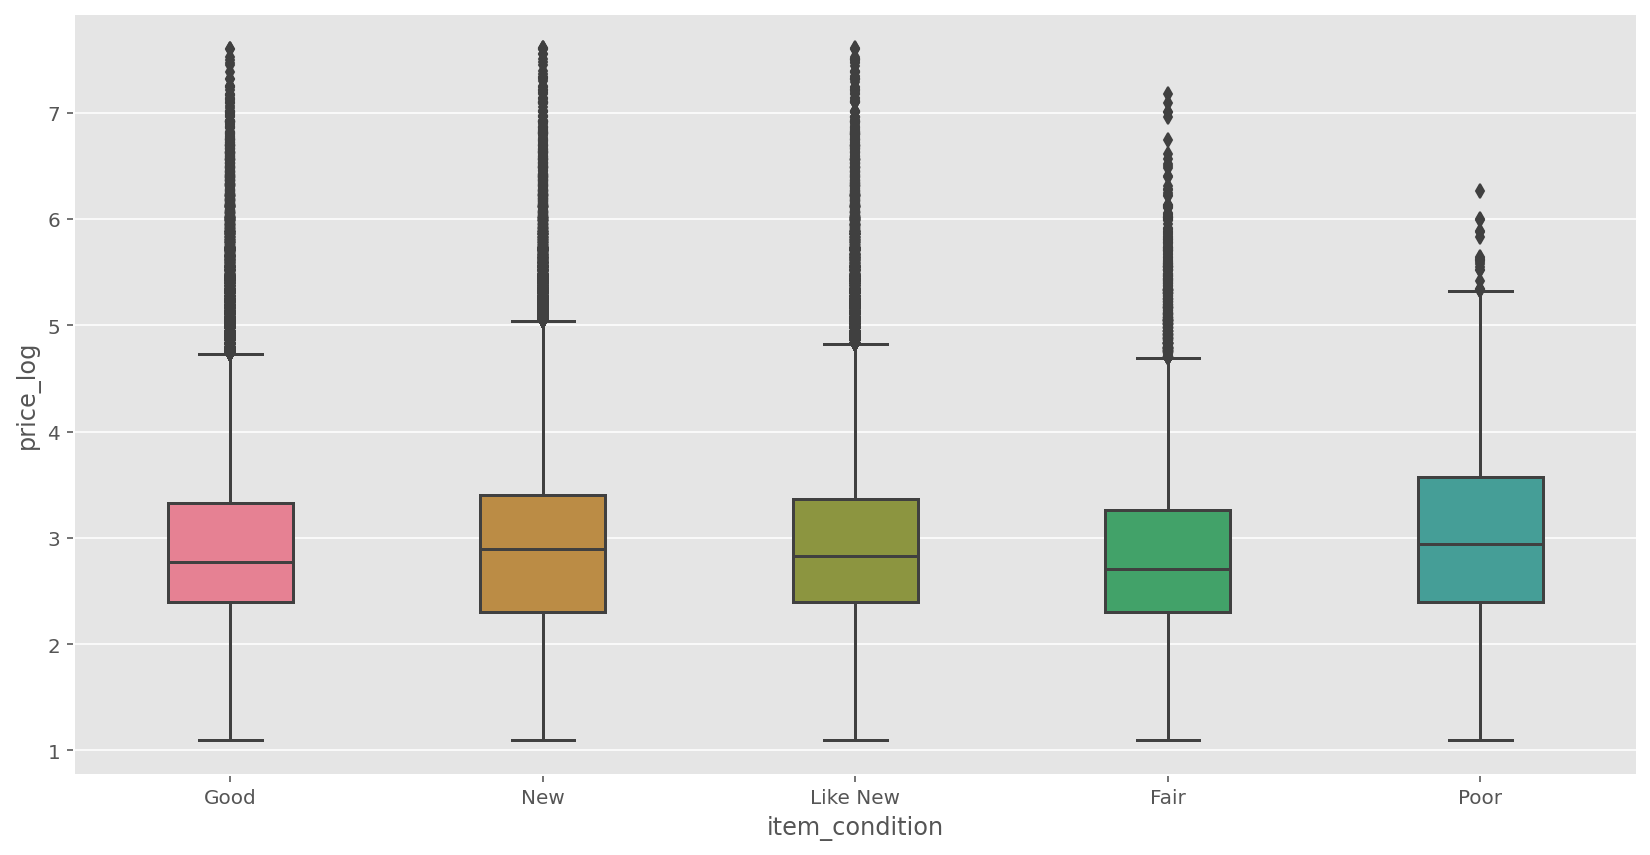

In [368]:
#lets look at the changes in price for each condition:
plt.figure(figsize=(14,7))
sns.boxplot(x = 'item_condition', y = 'price_log',
            data = data, palette = sns.color_palette("husl", 8),
           fliersize=5, width=0.4)
plt.show();

In [369]:
#the median price_log values for product conditions New and Poor at at $3
#slighly lower for 'Good', 'Almost New' and 'Fair' (around $2.75)
#majority of the items in each category are priced between $2.5 and $3.5
#we have quite a lot of outlier values within each category; could be explained due to some very expensive products listed

<b> Save dataframe as a CSV file: <b>

In [372]:
data.to_csv('retailprice.csv', encoding='utf-8', index=True)

<b> Modelling and Evalution: <b>

In [374]:
#since most of our data is in text form, we need to transform these into numeric values using encoding methods. 

In [375]:
categories = data[['category_1', 'category_2', 'category_3', 'category_4']]

In [376]:
#replace null values
categories = categories.replace(np.nan, '', regex=True)

In [377]:
#convert categories into a sparse matrix by applying count vectoriser:
cv = CountVectorizer()
cat1 = cv.fit_transform(categories['category_1'])
cat2 = cv.fit_transform(categories['category_2'])
cat3 = cv.fit_transform(categories['category_3'])
cat4 = cv.fit_transform(categories['category_4'])

In [378]:
cat1

<1475343x12 sparse matrix of type '<class 'numpy.int64'>'
	with 1547184 stored elements in Compressed Sparse Row format>

In [379]:
cat2

<1475343x141 sparse matrix of type '<class 'numpy.int64'>'
	with 2391760 stored elements in Compressed Sparse Row format>

In [380]:
cat3

<1475343x965 sparse matrix of type '<class 'numpy.int64'>'
	with 2351312 stored elements in Compressed Sparse Row format>

In [381]:
cat4

<1475343x8 sparse matrix of type '<class 'numpy.int64'>'
	with 1475756 stored elements in Compressed Sparse Row format>

In [382]:
#apply labelbinarizer to product name and brand name:
brand = data['brand_name'].replace(np.nan, '', regex=True) #replace null values

In [385]:
lb = LabelBinarizer(sparse_output=True)
brand_x = lb.fit_transform(brand)
brand_x

<1475343x4772 sparse matrix of type '<class 'numpy.int64'>'
	with 1475343 stored elements in Compressed Sparse Row format>

In [388]:
#dummify categorical data
cat_cols = data[['shipping','brand_p/a', 'description_p/a', 'item_condition']]

In [389]:
cat_cols = cat_cols.astype('category')

In [390]:
dummies = csr_matrix(pd.get_dummies(cat_cols, sparse=True).values)

In [391]:
dummies

<1475343x11 sparse matrix of type '<class 'numpy.uint8'>'
	with 5901372 stored elements in Compressed Sparse Row format>

In [392]:
#combine all matrices using hstack
merged_matrix = hstack((dummies, brand_x, cat1, cat2, cat3, cat4)).tocsr()

In [393]:
merged_matrix

<1475343x5909 sparse matrix of type '<class 'numpy.int64'>'
	with 15142727 stored elements in Compressed Sparse Row format>

SET TARGET AND PREDICTOR VARIABLES 

In [395]:
y = data.price_log
X = merged_matrix

TRAIN/TEST SPLIT

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

STANDARDIZE 

In [397]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

In [398]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LINEAR REGRESSION

In [399]:
lr = LinearRegression() #instantiate the model

In [400]:
lr.fit(X_train, y_train) #fit model on training set

LinearRegression()

In [401]:
print("Training Score:", lr.score(X_train, y_train)) #training score
print("Test Score:", lr.score(X_test, y_test)) #fit and evaluate on test data

Training Score: 0.413524257888755
Test Score: 0.41152320530647646


In [402]:
#cross validation scores
scores = cross_val_score(lr, X_train, y_train, cv=5)
print("Cross Validated Training Scores:", scores)
print("Mean Cross-Validated Training Score:", scores.mean())

Cross Validated Training Scores: [0.40483754 0.40826128 0.40933402 0.40931143 0.40774526]
Mean Cross-Validated Training Score: 0.40789790579895124


RIDGE REGRESSION 

In [403]:
model = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)# create a RidgeCV model instance
model.fit(X_train, y_train) #fit the model
print('Best alpha:', model.alpha_)# get the best alpha
print('Training score:', model.score(X_train, y_train))# evaluate on the training set
print("Test Score:", model.score(X_test, y_test))# evaluate on the test set

Best alpha: 0.046415888336127774
Training score: 0.41349121845280823
Test Score: 0.4114754805325592


In [404]:
#run model with best alpha
alpha = model.alpha_
model = Ridge(alpha=alpha)

In [405]:
# fit and evaluate the data on the whole training set and evaluate on test size
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Training Score: 0.41349121845280823
Test Score: 0.4114754805325592


In [406]:
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated Training scores:", scores)
print("Mean cross-validated Training score:", scores.mean())

Cross-validated Training scores: [0.40484344 0.4082223  0.40933574 0.40933664 0.40771538]
Mean cross-validated Training score: 0.4078907000437825


RANDOM FOREST REGRESSOR 

In [410]:
rf = RandomForestRegressor(random_state = 42)

In [411]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [412]:
print("Training Score:", rf.score(X_train, y_train))
print("Test Score:", rf.score(X_test, y_test))

Training Score: 0.5165392654725567
Test Score: 0.45708299270640684


In [414]:
scores = cross_val_score(rf, X_train, y_train, cv=5)
print("Cross-validated Training scores:", scores)
print("Mean cross-validated Training score:", scores.mean())

Cross-validated Training scores: [0.44879791 0.45146338 0.45234079 0.45170365 0.45011165]
Mean cross-validated Training score: 0.4508834766217068


GRADIENT BOOSTING REGRESSOR 

In [415]:
from sklearn import ensemble
params = {'n_estimators': 2000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'huber'}
GBR = ensemble.GradientBoostingRegressor(**params)

In [416]:
GBR.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=4,
                          min_samples_split=5, n_estimators=2000)

In [417]:
#training and testing scores
print("Training Score:", GBR.score(X_train, y_train))
print("Test Score:", GBR.score(X_test, y_test))

Training Score: 0.3450105187103225
Test Score: 0.3475746943239618


In [418]:
#cross validation scores 
scores = cross_val_score(GBR, X_train, y_train, cv=5)
print("Cross-validated Training scores:", scores)
print("Mean cross-validated Training score:", scores.mean())

Cross-validated Training scores: [0.34206983 0.34328447 0.34615026 0.34493843 0.34464289]
Mean cross-validated Training score: 0.344217177343735


RMSLE scores:

In [419]:
#predictions made by each model 
pred_lr = lr.predict(X_test)
pred_model = model.predict(X_test)
pred_rf = rf.predict(X_test)
pred_GBR = GBR.predict(X_test)

In [422]:
#rmsle scores:
print("Linear Regression:", np.sqrt(mean_squared_log_error(y_test, pred_lr)))
print("Ridge Regression:", np.sqrt(mean_squared_log_error(y_test, pred_model)))
print("Random Forest Regressor:", np.sqrt(mean_squared_log_error(y_test, pred_rf)))
print("Gradient Boosting Regressor:", np.sqrt(mean_squared_log_error(y_test, pred_GBR)))

Linear Regression: 0.15654902460129833
Ridge Regression: 0.15655584715763815
Random Forest Regressor: 0.15041173323450105
Gradient Boosting Regressor: 0.1634789734449772


In [ ]:
#as we can see, random forest regressor has scored the lowest RMSLE scores, which indicates that it is the best model
#in predicting price, as compared the rest. 

ACTUAL vs. PREDICTED:

In [423]:
linear = pd.DataFrame({'y_test': y_test,
                      'y_pred': pred_lr})
linear.head(20)

y_test    y_pred
115097   2.772589  2.967663
681631   2.944439  2.789458
1108820  2.890372  3.431582
833510   2.708050  2.786339
148756   2.564949  2.896627
299773   2.708050  3.012802
1049267  4.060443  3.569214
774020   2.079442  2.407193
1197470  3.401197  2.772521
1282161  2.944439  3.247375
1338114  2.397895  2.704444
1068687  2.302585  2.821450
37331    3.091042  3.335221
147093   1.791759  2.469927
1064147  3.526361  3.458418
1376391  4.369448  4.046749
994003   2.772589  2.878111
278646   3.135494  2.875062
1359047  2.484907  3.088241
344572   3.583519  3.595194

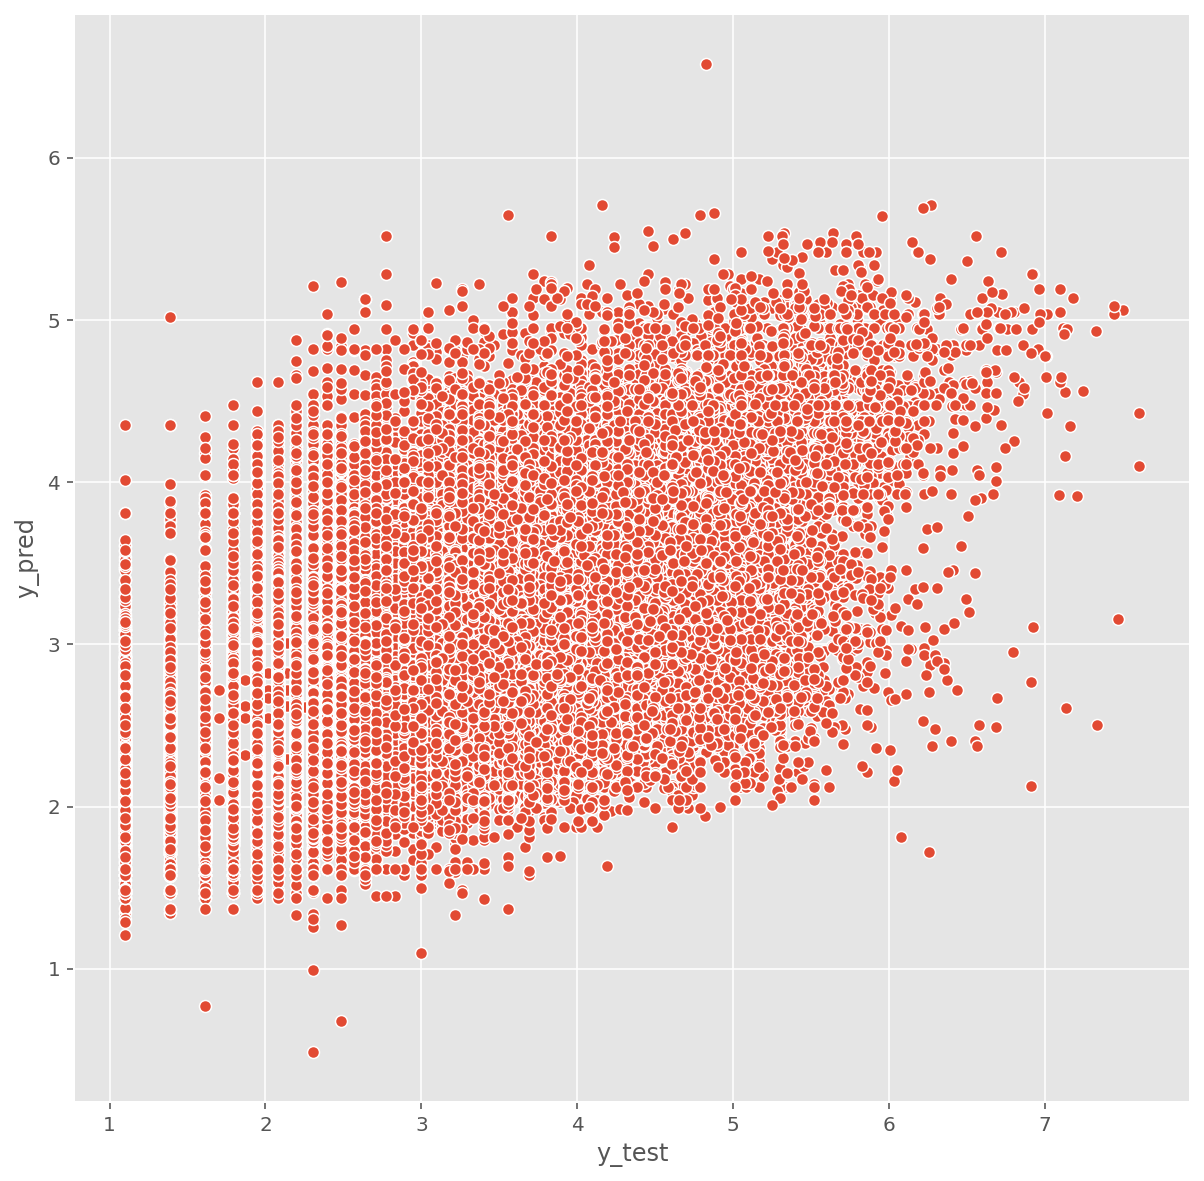

In [425]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = 'y_test', y = 'y_pred', data=linear, palette = ['red']);

In [426]:
ridge = pd.DataFrame({'y_test': y_test,
                      'y_pred': pred_model})
ridge.head(20)

y_test    y_pred
115097   2.772589  2.967707
681631   2.944439  2.783446
1108820  2.890372  3.430863
833510   2.708050  2.800399
148756   2.564949  2.895822
299773   2.708050  3.012693
1049267  4.060443  3.568913
774020   2.079442  2.407109
1197470  3.401197  2.771745
1282161  2.944439  3.246866
1338114  2.397895  2.705458
1068687  2.302585  2.820707
37331    3.091042  3.335819
147093   1.791759  2.469986
1064147  3.526361  3.458268
1376391  4.369448  4.046126
994003   2.772589  2.878343
278646   3.135494  2.875123
1359047  2.484907  3.088212
344572   3.583519  3.594982

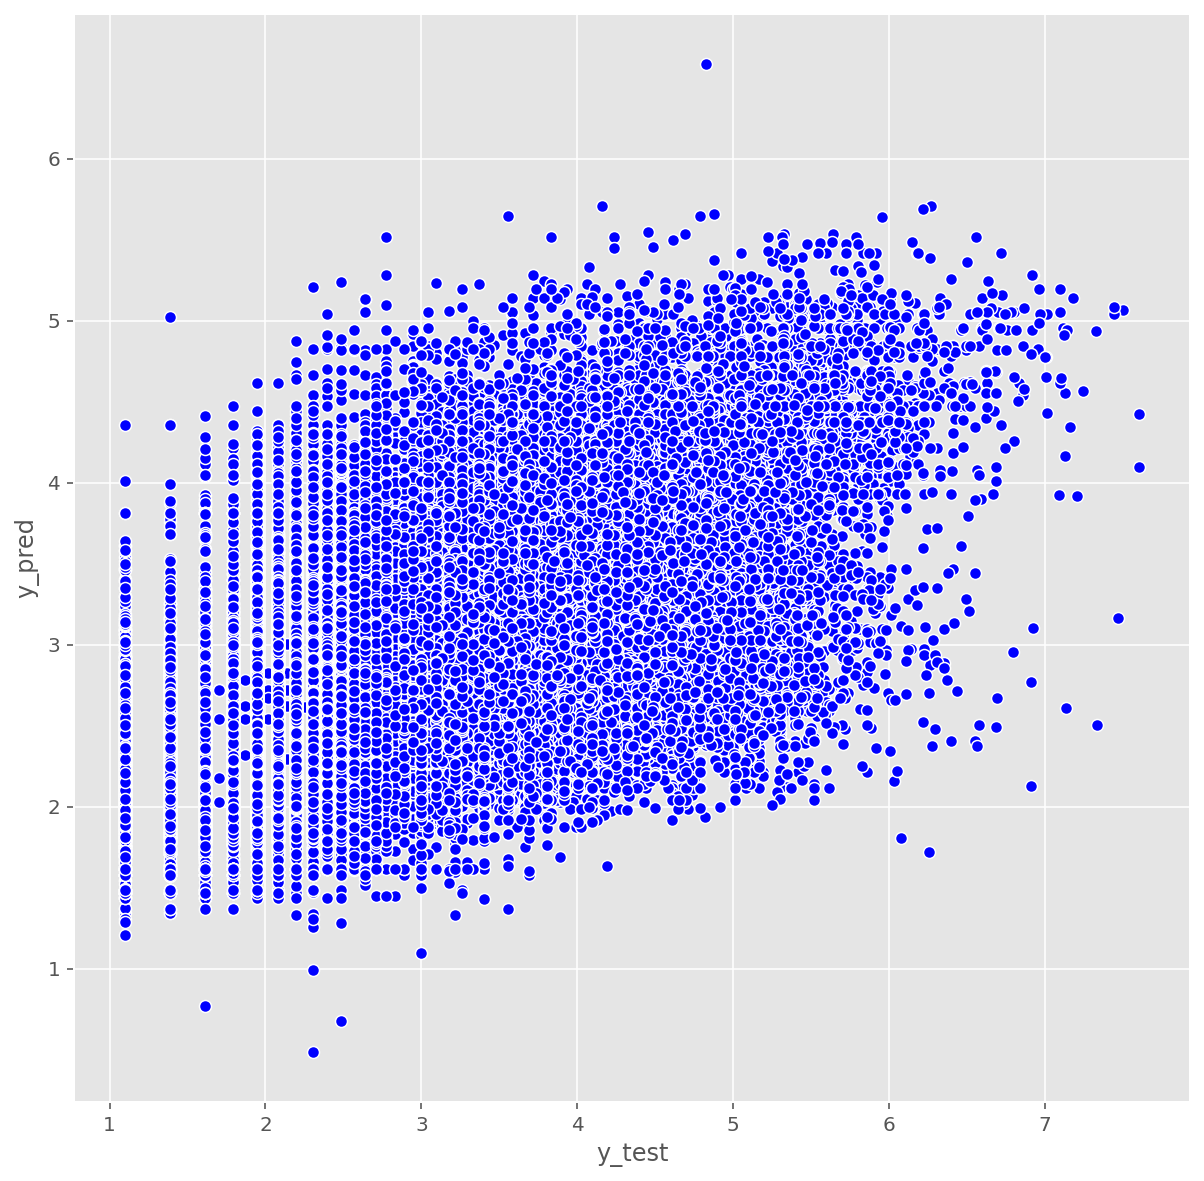

In [433]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = 'y_test', y = 'y_pred', data=ridge, color = ['blue']);

In [434]:
random = pd.DataFrame({'y_test': y_test,
                      'y_pred': pred_rf})
random.head(20)

y_test    y_pred
115097   2.772589  2.900707
681631   2.944439  2.510507
1108820  2.890372  3.051207
833510   2.708050  2.609956
148756   2.564949  2.637681
299773   2.708050  3.124648
1049267  4.060443  3.492964
774020   2.079442  2.397521
1197470  3.401197  2.912990
1282161  2.944439  3.242643
1338114  2.397895  2.721617
1068687  2.302585  3.060519
37331    3.091042  3.205054
147093   1.791759  2.455821
1064147  3.526361  3.393466
1376391  4.369448  4.042131
994003   2.772589  2.531391
278646   3.135494  3.014136
1359047  2.484907  2.830291
344572   3.583519  3.601265

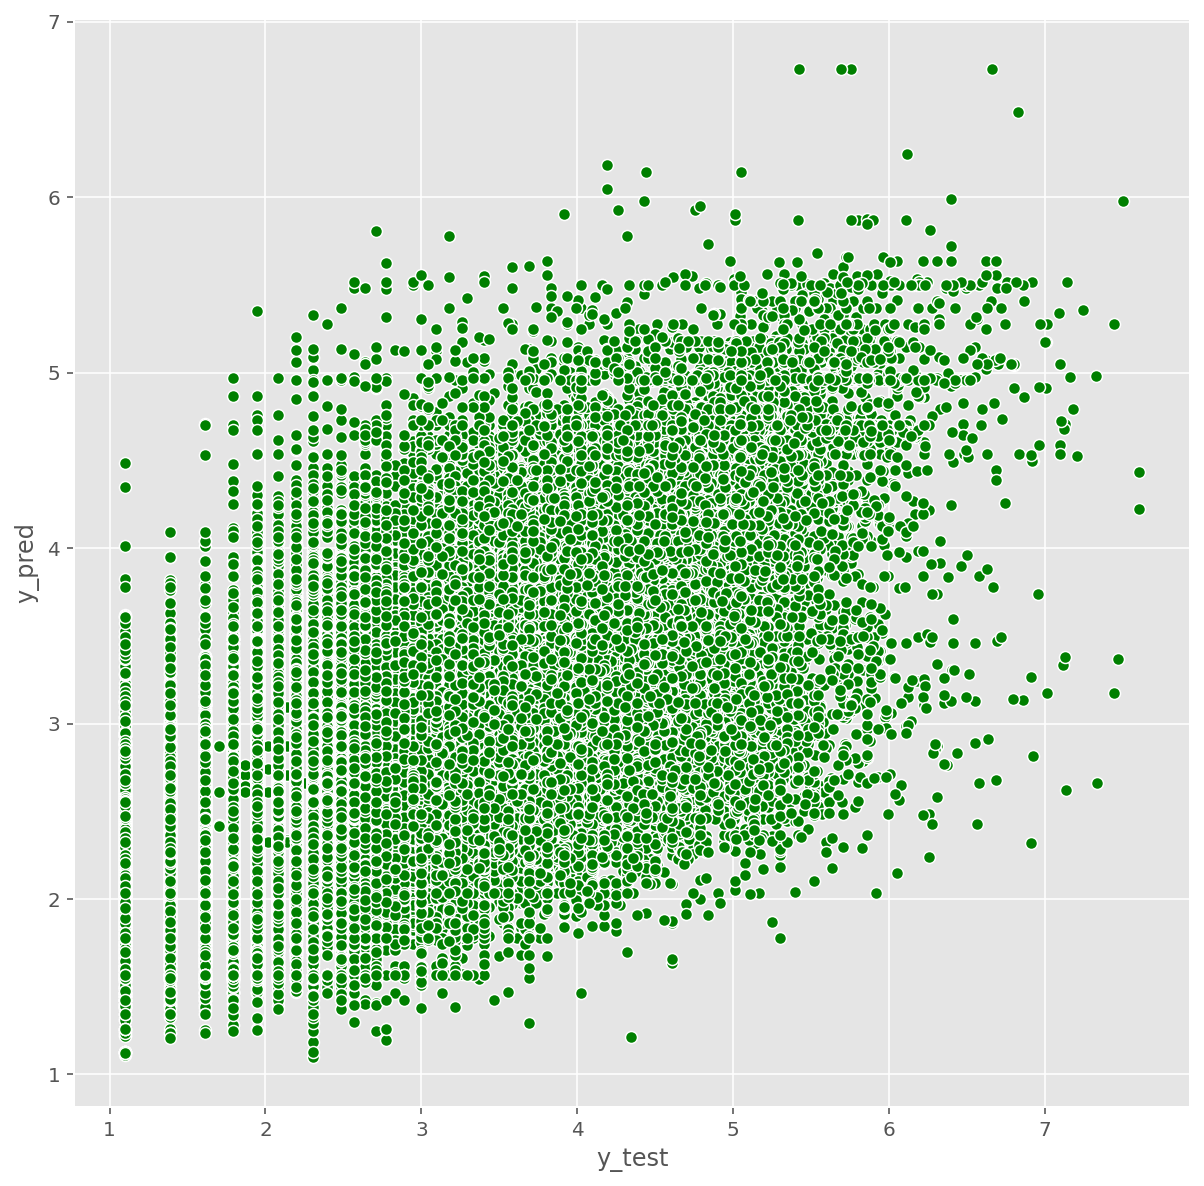

In [435]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = 'y_test', y = 'y_pred', data=random, color = ['green']);

In [436]:
gradient = pd.DataFrame({'y_test': y_test,
                      'y_pred': pred_GBR})
gradient.head(20)

y_test    y_pred
115097   2.772589  2.837689
681631   2.944439  2.665876
1108820  2.890372  3.006659
833510   2.708050  2.965568
148756   2.564949  2.948005
299773   2.708050  2.864573
1049267  4.060443  3.292039
774020   2.079442  2.705262
1197470  3.401197  2.485533
1282161  2.944439  3.127309
1338114  2.397895  2.840745
1068687  2.302585  2.779620
37331    3.091042  3.452727
147093   1.791759  2.466124
1064147  3.526361  3.103642
1376391  4.369448  3.759909
994003   2.772589  3.002012
278646   3.135494  3.004915
1359047  2.484907  2.861911
344572   3.583519  3.067790

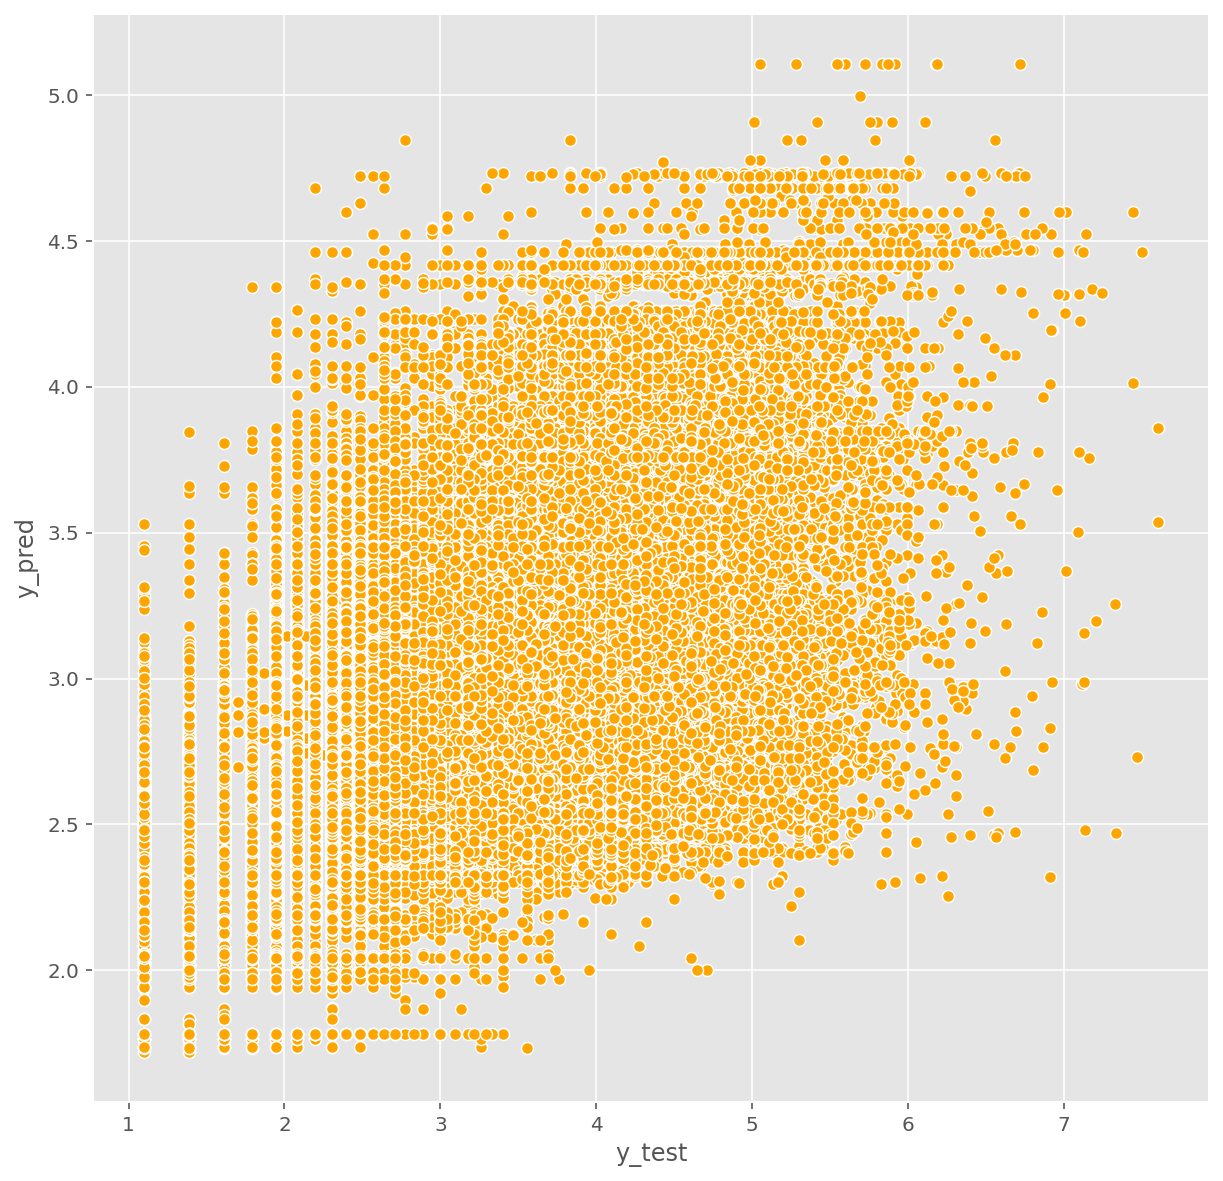

In [438]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = 'y_test', y = 'y_pred', data=gradient, color = ['orange']);